In [2]:
import  numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
from sklearn.metrics import accuracy_score
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

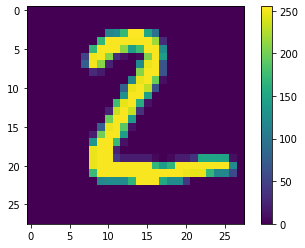

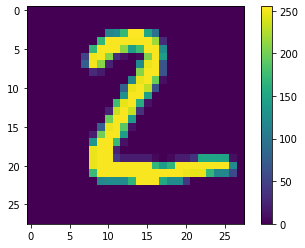

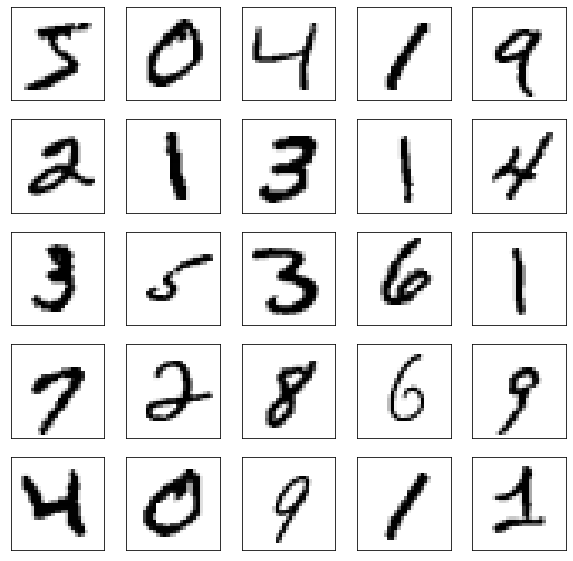

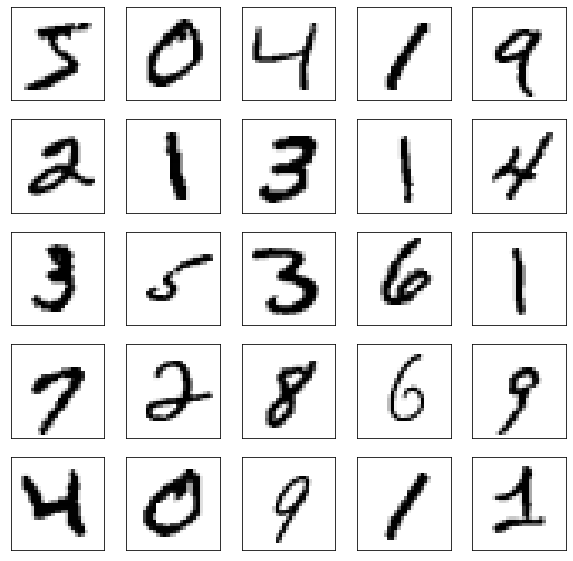

In [5]:
#data preperation
(x_train, y_train1),(x_test, y_test1)= mnist.load_data()
image_size=x_train.shape[1]

plt.figure()
plt.imshow(x_test[1])
plt.colorbar()
plt.show()

#Display the first 25 images from the training set and display the class name below each image. 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

x_train=x_train.reshape((-1,image_size*image_size)).astype('float32')/255
x_test=x_test.reshape((-1,image_size*image_size)).astype('float32')/255
n_input= image_size*image_size     #features
n_output=len(np.unique(y_train1))
#np.unique(y_train)   # array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
#when I run my code using tf.one_hot at initialization of variables (for loop) we have error relevant to
# feed_dict input that shouldn't  be tensor :x_batch ,y_batch and after convert to ndarray we have error:too many indice :|
#so finally I use to_categorical
#y_train=tf.one_hot(y_train,depth=n_output)
#y_test=tf.one_hot(y_test,depth=n_output)
y_train=to_categorical(y_train1)
y_test=to_categorical(y_test1)

batch_size=32
n_hiden_layers=[256,256]
n_epochs=10

In [6]:
#defining parameters
with tf.name_scope('placeholders'):
    x_tensor=tf.placeholder(name='x_tensor',dtype=tf.float32,shape=[None,n_input])  #(60000,784)
    y_tensor=tf.placeholder(name='y_tensor',dtype=tf.float32,shape=[None,n_output])   #(60000,1)
    keep_prob_p=tf.placeholder(name='keep_prob',dtype=tf.float32) #we want to set with probability of 1 at begining  

In [8]:
with tf.name_scope('hidden_layer1'):
    weight_1=tf.Variable(tf.random_normal(shape=[n_input,n_hiden_layers[0]],stddev=0.01),name='weight_1',dtype=tf.float32)  #(784,256)
   #input args for tf.variable should be a tensor so using tf.random_normal_initializer causes error
    bias_1=tf.Variable(tf.random_normal(shape=[1,n_hiden_layers[0]],stddev=0.01),name='bias_1',dtype=tf.float32)  #(256,)
   #buiold the model with RELU activation
    hidden_layer_1_model=tf.nn.relu(tf.matmul(x_tensor,weight_1)+bias_1)
    #apply DropOut to hidden layer as a regularization technique to improve accuracy and reduce overfitting
    hidden_layer_1_model=tf.nn.dropout(hidden_layer_1_model,keep_prob=keep_prob_p)

In [9]:
with tf.name_scope('hidden_layer2'):
    weight_2=tf.Variable(tf.random_normal(shape=[n_hiden_layers[0],n_hiden_layers[1]],stddev=0.01),name='weight_2',dtype=tf.float32)  #(784,256)
   #input args for tf.variable should be a tensor so using tf.random_normal_initializer causes error
    bias_2=tf.Variable(tf.random_normal(shape=[1,n_hiden_layers[1]],stddev=0.01),name='bias_2',dtype=tf.float32)  #(256,)
   #build the model with RELU activation
    hidden_layer_2_model=tf.nn.relu(tf.matmul(hidden_layer_1_model,weight_2)+bias_2)
    #apply DropOut to hidden layer as a regularization technique to improve accuracy and reduce overfitting
    hidden_layer_2_model=tf.nn.dropout(hidden_layer_2_model,keep_prob=keep_prob_p)

In [10]:
with tf.name_scope('output_layer'):
    weight_out=tf.Variable(tf.random_normal(shape=[n_hiden_layers[-1],n_output],stddev=0.01),name='weight_out',dtype=tf.float32)  #(784,256)
   #input args for tf.variable should be a tensor so using tf.random_normal_initializer causes error
    bias_out=tf.Variable(tf.random_normal(shape=(n_output,),stddev=0.01),name='bias_out',dtype=tf.float32)  #(10)
   #build the model with RELU activation
    output_layer_model=tf.matmul(hidden_layer_2_model,weight_out)+bias_out   #logit layer (final layer in NN)
    y_predict_t=tf.nn.softmax(logits=output_layer_model,name='y_predict')
    

In [12]:
with tf.name_scope('loss'):
    loss_op=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer_model,labels=y_tensor, name='loss'))
    #if we dont apply mean we will have the 32 result for loss at initialization for loss_value at each step
    #because for all 32 sample ( batch size of samples) it should be calculated
    

In [13]:
#training using gradient descent
with tf.name_scope('optimizer'):
    optimizer=tf.train.AdamOptimizer().minimize(loss_op)

In [14]:
#calculation of accuracy manuaLly(tensor based)
#y_train.shape : (60000,10) ,tf.argmax(y_tensor,1) : on second dimension each sample batch
accuracy_op=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_predict_t,1),tf.argmax(y_tensor,1)),tf.float32 , name='prediction_correct'))

In [15]:
#variables initaialization
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    loss_values=[]
    acc_values_m=[]
    acc_values_a=[]
    acc_values_e=[]
    for epoch in range(1,n_epochs+1):
        pos=0
        step=1
        while pos<x_train.shape[0]:
            x_batch=x_train[pos:pos+batch_size]
            y_batch=y_train[pos:pos+batch_size]
            #keep_prob :0.5 means half of data are kept
            feed_dict_batch={x_tensor:x_batch,y_tensor:y_batch,keep_prob_p:0.5}
            #feed_dict input couldn't be a tensor so a convert is necessary
            loss_batch,_=sess.run([loss_op,optimizer],feed_dict=feed_dict_batch)
            acc_batch_m=sess.run(accuracy_op,feed_dict={x_tensor:x_batch,y_tensor:y_batch,keep_prob_p:1})
            y_predict=sess.run(y_predict_t,feed_dict={x_tensor:x_batch,keep_prob_p:1})
            acc_batch_a=accuracy_score(y_true=np.argmax(y_batch,axis=1),y_pred=np.argmax(y_predict,axis=1))
            print(f'epoch: {epoch} , step: {step} ,loss_batch: {loss_batch}, acc_batch manually: {acc_batch_m} , acc_batch_auto :{acc_batch_a}')  
            loss_values.append(loss_batch)
            acc_values_m.append(acc_batch_m)
            acc_values_a.append(acc_batch_a)
            step+=1
            pos+=batch_size
        y_predict_epoch = sess.run(y_predict_t, feed_dict={x_tensor: x_train,keep_prob_p:1})
        acc_epoch = accuracy_score(y_true=np.argmax(y_train,axis=1),y_pred=np.argmax(y_predict_epoch,axis=1))
        acc_values_e.append(acc_epoch)
        print(f'\n epoch: {epoch} , accuracy for epoch : {acc_epoch}')
            

epoch: 1 , step: 1 ,loss_batch: 2.3033924102783203, acc_batch manually: 0.1875 , acc_batch_auto :0.1875
epoch: 1 , step: 2 ,loss_batch: 2.3019955158233643, acc_batch manually: 0.28125 , acc_batch_auto :0.28125
epoch: 1 , step: 3 ,loss_batch: 2.2999496459960938, acc_batch manually: 0.4375 , acc_batch_auto :0.4375
epoch: 1 , step: 4 ,loss_batch: 2.2979624271392822, acc_batch manually: 0.4375 , acc_batch_auto :0.4375
epoch: 1 , step: 5 ,loss_batch: 2.2984607219696045, acc_batch manually: 0.09375 , acc_batch_auto :0.09375
epoch: 1 , step: 6 ,loss_batch: 2.301173686981201, acc_batch manually: 0.125 , acc_batch_auto :0.125
epoch: 1 , step: 7 ,loss_batch: 2.2817773818969727, acc_batch manually: 0.3125 , acc_batch_auto :0.3125
epoch: 1 , step: 8 ,loss_batch: 2.287297248840332, acc_batch manually: 0.25 , acc_batch_auto :0.25
epoch: 1 , step: 9 ,loss_batch: 2.2970852851867676, acc_batch manually: 0.15625 , acc_batch_auto :0.15625
epoch: 1 , step: 10 ,loss_batch: 2.274866819381714, acc_batch manu

epoch: 1 , step: 35 ,loss_batch: 1.5754624605178833, acc_batch manually: 0.375 , acc_batch_auto :0.375
epoch: 1 , step: 36 ,loss_batch: 1.713066816329956, acc_batch manually: 0.40625 , acc_batch_auto :0.40625
epoch: 1 , step: 37 ,loss_batch: 1.3920056819915771, acc_batch manually: 0.53125 , acc_batch_auto :0.53125
epoch: 1 , step: 38 ,loss_batch: 1.2593295574188232, acc_batch manually: 0.65625 , acc_batch_auto :0.65625
epoch: 1 , step: 39 ,loss_batch: 1.5915517807006836, acc_batch manually: 0.625 , acc_batch_auto :0.625
epoch: 1 , step: 40 ,loss_batch: 1.5390074253082275, acc_batch manually: 0.5625 , acc_batch_auto :0.5625
epoch: 1 , step: 41 ,loss_batch: 1.4153270721435547, acc_batch manually: 0.5 , acc_batch_auto :0.5
epoch: 1 , step: 42 ,loss_batch: 1.2009565830230713, acc_batch manually: 0.65625 , acc_batch_auto :0.65625
epoch: 1 , step: 43 ,loss_batch: 1.4014339447021484, acc_batch manually: 0.71875 , acc_batch_auto :0.71875
epoch: 1 , step: 44 ,loss_batch: 1.5130051374435425, acc

epoch: 1 , step: 96 ,loss_batch: 0.9188608527183533, acc_batch manually: 0.75 , acc_batch_auto :0.75
epoch: 1 , step: 97 ,loss_batch: 0.8134493827819824, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 1 , step: 98 ,loss_batch: 0.6087386608123779, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 99 ,loss_batch: 0.7080646753311157, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 1 , step: 100 ,loss_batch: 0.7321932315826416, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 1 , step: 101 ,loss_batch: 0.8175889253616333, acc_batch manually: 0.75 , acc_batch_auto :0.75
epoch: 1 , step: 102 ,loss_batch: 0.7127583622932434, acc_batch manually: 0.78125 , acc_batch_auto :0.78125
epoch: 1 , step: 103 ,loss_batch: 0.858146607875824, acc_batch manually: 0.78125 , acc_batch_auto :0.78125
epoch: 1 , step: 104 ,loss_batch: 1.0881901979446411, acc_batch manually: 0.78125 , acc_batch_auto :0.78125
epoch: 1 , step: 105 ,loss_batch: 0.6441003680229187, a

epoch: 1 , step: 129 ,loss_batch: 0.6169297695159912, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 130 ,loss_batch: 0.9396415948867798, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 131 ,loss_batch: 0.7240352630615234, acc_batch manually: 0.78125 , acc_batch_auto :0.78125
epoch: 1 , step: 132 ,loss_batch: 0.5262852907180786, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 133 ,loss_batch: 0.5461742281913757, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 134 ,loss_batch: 0.779356837272644, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 1 , step: 135 ,loss_batch: 0.6467616558074951, acc_batch manually: 0.78125 , acc_batch_auto :0.78125
epoch: 1 , step: 136 ,loss_batch: 0.5705680847167969, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 137 ,loss_batch: 0.6522886753082275, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 138 ,loss_batch: 0.6521900

epoch: 1 , step: 193 ,loss_batch: 0.43835434317588806, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 194 ,loss_batch: 0.37410831451416016, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 195 ,loss_batch: 0.38470155000686646, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 196 ,loss_batch: 0.7844648361206055, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 197 ,loss_batch: 0.6070237159729004, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 198 ,loss_batch: 0.35811927914619446, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 199 ,loss_batch: 0.5275652408599854, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 200 ,loss_batch: 0.4730757474899292, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 201 ,loss_batch: 0.7487265467643738, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 202 ,loss_batch: 0.

epoch: 1 , step: 225 ,loss_batch: 0.7205953001976013, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 226 ,loss_batch: 0.6139437556266785, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 1 , step: 227 ,loss_batch: 0.6169133186340332, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 228 ,loss_batch: 0.6403360366821289, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 229 ,loss_batch: 0.6382904648780823, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 230 ,loss_batch: 0.6675021648406982, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 231 ,loss_batch: 0.5082643032073975, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 232 ,loss_batch: 0.28377944231033325, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 233 ,loss_batch: 0.5901051759719849, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 234 ,loss_batch: 0.3

epoch: 1 , step: 289 ,loss_batch: 0.48259982466697693, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 290 ,loss_batch: 0.7169747352600098, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 291 ,loss_batch: 0.46853363513946533, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 292 ,loss_batch: 0.5040495991706848, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 293 ,loss_batch: 0.7059476375579834, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 294 ,loss_batch: 0.4623295068740845, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 295 ,loss_batch: 0.941838800907135, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 296 ,loss_batch: 0.35212045907974243, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 297 ,loss_batch: 0.4342230260372162, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 298 ,loss_batch: 0.

epoch: 1 , step: 321 ,loss_batch: 0.8003592491149902, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 322 ,loss_batch: 0.5101696252822876, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 323 ,loss_batch: 0.44609105587005615, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 324 ,loss_batch: 0.21230393648147583, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 325 ,loss_batch: 0.22654011845588684, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 326 ,loss_batch: 0.27550414204597473, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 327 ,loss_batch: 0.45280247926712036, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 328 ,loss_batch: 0.4084321856498718, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 329 ,loss_batch: 0.3832027018070221, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 330 ,los

epoch: 1 , step: 385 ,loss_batch: 0.3958415687084198, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 386 ,loss_batch: 0.48096904158592224, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 387 ,loss_batch: 0.5744385719299316, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 388 ,loss_batch: 0.28792446851730347, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 389 ,loss_batch: 0.5175098776817322, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 1 , step: 390 ,loss_batch: 0.4901619553565979, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 391 ,loss_batch: 0.7018875479698181, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 1 , step: 392 ,loss_batch: 0.5852456092834473, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 393 ,loss_batch: 0.8154051899909973, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 394 ,loss_batch: 1.12272477

epoch: 1 , step: 417 ,loss_batch: 0.3233599066734314, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 418 ,loss_batch: 0.47541892528533936, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 419 ,loss_batch: 0.44736599922180176, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 420 ,loss_batch: 0.26688894629478455, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 421 ,loss_batch: 0.4183160066604614, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 422 ,loss_batch: 0.1764993518590927, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 423 ,loss_batch: 0.5542543530464172, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 424 ,loss_batch: 0.2778642475605011, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 425 ,loss_batch: 0.22452349960803986, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 426 ,loss_b

epoch: 1 , step: 481 ,loss_batch: 0.32229316234588623, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 482 ,loss_batch: 0.29519152641296387, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 483 ,loss_batch: 0.33131107687950134, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 484 ,loss_batch: 0.31680208444595337, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 485 ,loss_batch: 0.5433682203292847, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 486 ,loss_batch: 0.3599505126476288, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 487 ,loss_batch: 0.26337915658950806, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 488 ,loss_batch: 0.4603657126426697, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 489 ,loss_batch: 0.1780552864074707, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 490 ,loss_batch: 0

epoch: 1 , step: 513 ,loss_batch: 0.13400918245315552, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 514 ,loss_batch: 0.3884216547012329, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 515 ,loss_batch: 0.276547372341156, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 516 ,loss_batch: 0.4136439263820648, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 517 ,loss_batch: 0.31040483713150024, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 518 ,loss_batch: 0.6241254806518555, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 519 ,loss_batch: 0.40021252632141113, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 520 ,loss_batch: 0.3006875813007355, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 521 ,loss_batch: 0.572306752204895, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 522 ,loss_batch: 0.614

epoch: 1 , step: 577 ,loss_batch: 0.23299764096736908, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 578 ,loss_batch: 0.534217357635498, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 579 ,loss_batch: 0.32200366258621216, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 580 ,loss_batch: 0.12937255203723907, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 581 ,loss_batch: 0.318339467048645, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 582 ,loss_batch: 0.49582695960998535, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 583 ,loss_batch: 0.4020161032676697, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 584 ,loss_batch: 0.3263748288154602, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 585 ,loss_batch: 0.2511882781982422, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 586 ,loss_batch: 0.728380

epoch: 1 , step: 609 ,loss_batch: 0.15557105839252472, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 610 ,loss_batch: 0.5646352767944336, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 611 ,loss_batch: 0.3331230878829956, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 612 ,loss_batch: 0.2551659941673279, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 613 ,loss_batch: 0.2712663412094116, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 614 ,loss_batch: 0.23407427966594696, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 615 ,loss_batch: 0.06968631595373154, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 616 ,loss_batch: 0.11846654117107391, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 617 ,loss_batch: 0.0787464901804924, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 618 ,loss_batch: 0.19399860501289368, a

epoch: 1 , step: 669 ,loss_batch: 0.40206465125083923, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 670 ,loss_batch: 0.5413873195648193, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 671 ,loss_batch: 0.22598543763160706, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 672 ,loss_batch: 0.21062617003917694, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 673 ,loss_batch: 0.22438859939575195, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 674 ,loss_batch: 0.16878561675548553, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 675 ,loss_batch: 0.4516988694667816, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 1 , step: 676 ,loss_batch: 0.43496620655059814, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 677 ,loss_batch: 0.2512059509754181, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 678 ,loss_batch: 0.293044


epoch: 1 , step: 697 ,loss_batch: 0.42441707849502563, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 698 ,loss_batch: 0.319438636302948, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 699 ,loss_batch: 0.1984845995903015, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 700 ,loss_batch: 0.09175356477499008, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 701 ,loss_batch: 0.21749134361743927, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 702 ,loss_batch: 0.24298697710037231, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 703 ,loss_batch: 0.8807610273361206, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 704 ,loss_batch: 0.8004224300384521, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 705 ,loss_batch: 0.6338473558425903, acc_batch manually: 0.78125 , acc_batch_auto :0.78125
epoch: 1 , step: 706 ,loss_batch: 0.52254587

epoch: 1 , step: 752 ,loss_batch: 0.4004742503166199, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 753 ,loss_batch: 0.1531725376844406, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 754 ,loss_batch: 0.2509698271751404, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 755 ,loss_batch: 0.2164781093597412, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 756 ,loss_batch: 0.20865070819854736, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 757 ,loss_batch: 0.5162954926490784, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 758 ,loss_batch: 0.2961907684803009, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 759 ,loss_batch: 0.7391096949577332, acc_batch manually: 0.71875 , acc_batch_auto :0.71875
epoch: 1 , step: 760 ,loss_batch: 0.27007558941841125, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 761 ,loss_batch: 

epoch: 1 , step: 779 ,loss_batch: 0.22162890434265137, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 780 ,loss_batch: 0.5783402323722839, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 781 ,loss_batch: 0.5692083239555359, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 782 ,loss_batch: 0.22748541831970215, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 783 ,loss_batch: 0.09814386069774628, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 784 ,loss_batch: 0.1721707284450531, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 785 ,loss_batch: 0.23124189674854279, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 786 ,loss_batch: 0.22657129168510437, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 787 ,loss_batch: 0.31944701075553894, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 788 ,loss_batch: 0.33761295676231

epoch: 1 , step: 838 ,loss_batch: 0.26318618655204773, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 839 ,loss_batch: 0.09381669759750366, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 840 ,loss_batch: 0.47728121280670166, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 841 ,loss_batch: 0.5409035086631775, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 842 ,loss_batch: 0.30037954449653625, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 843 ,loss_batch: 0.19550341367721558, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 844 ,loss_batch: 0.14197106659412384, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 845 ,loss_batch: 0.17179089784622192, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 846 ,loss_batch: 0.19150255620479584, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 847 ,loss_batch: 0.3725160360

epoch: 1 , step: 901 ,loss_batch: 0.15846654772758484, acc_batch manually: 0.96875 , acc_batch_auto :0.96875epoch: 1 , step: 870 ,loss_batch: 0.3257622718811035, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 871 ,loss_batch: 0.28665950894355774, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 872 ,loss_batch: 0.40679100155830383, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 873 ,loss_batch: 0.20946624875068665, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 874 ,loss_batch: 0.18689429759979248, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 875 ,loss_batch: 0.18100552260875702, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 876 ,loss_batch: 0.08959857374429703, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 877 ,loss_batch: 0.06502067297697067, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 878 ,loss_batch: 0.183

epoch: 1 , step: 934 ,loss_batch: 0.21053814888000488, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 935 ,loss_batch: 0.3689746558666229, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 936 ,loss_batch: 0.48570114374160767, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 937 ,loss_batch: 0.400656521320343, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 938 ,loss_batch: 0.3937762975692749, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 939 ,loss_batch: 0.3453938961029053, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 940 ,loss_batch: 0.30800724029541016, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 941 ,loss_batch: 0.3183693289756775, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 942 ,loss_batch: 0.43457967042922974, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 943 ,loss_batch: 0.5

epoch: 1 , step: 966 ,loss_batch: 0.5814234614372253, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 967 ,loss_batch: 0.1961919516324997, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 968 ,loss_batch: 0.48604828119277954, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 969 ,loss_batch: 0.4704545736312866, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 970 ,loss_batch: 0.40580564737319946, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 971 ,loss_batch: 0.21827951073646545, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 972 ,loss_batch: 0.3522762656211853, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 973 ,loss_batch: 0.7932614088058472, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 974 ,loss_batch: 0.10379296541213989, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 975 ,loss_batch: 0.8342

epoch: 1 , step: 1030 ,loss_batch: 0.1641317754983902, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1031 ,loss_batch: 0.13173934817314148, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1032 ,loss_batch: 0.17587235569953918, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1033 ,loss_batch: 0.21090734004974365, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1034 ,loss_batch: 0.22240227460861206, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1035 ,loss_batch: 0.3774070739746094, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1036 ,loss_batch: 0.22845031321048737, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1037 ,loss_batch: 0.24211913347244263, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1038 ,loss_batch: 0.2630937099456787, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1039 ,loss_b

epoch: 1 , step: 1063 ,loss_batch: 0.20727726817131042, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1064 ,loss_batch: 0.23831604421138763, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1065 ,loss_batch: 0.36041390895843506, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1066 ,loss_batch: 0.10214941203594208, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1067 ,loss_batch: 0.24688273668289185, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1068 ,loss_batch: 0.028991002589464188, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1069 ,loss_batch: 0.28913095593452454, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1070 ,loss_batch: 0.14681854844093323, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1071 ,loss_batch: 0.1428128331899643, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1072 ,loss_batch: 0.0374731682240963,

epoch: 1 , step: 1126 ,loss_batch: 0.2981988191604614, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1127 ,loss_batch: 0.2776329219341278, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1128 ,loss_batch: 0.4552602469921112, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1129 ,loss_batch: 0.5544895529747009, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 1130 ,loss_batch: 0.1836867332458496, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1131 ,loss_batch: 0.1795485019683838, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1132 ,loss_batch: 0.15723916888237, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1133 ,loss_batch: 0.1473141312599182, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1134 ,loss_batch: 0.2747790217399597, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1135 ,loss

epoch: 1 , step: 1158 ,loss_batch: 0.3135051131248474, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1159 ,loss_batch: 0.5482377409934998, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1160 ,loss_batch: 0.35643166303634644, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1161 ,loss_batch: 0.1729666292667389, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1162 ,loss_batch: 0.4488164186477661, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 1163 ,loss_batch: 0.37728947401046753, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1164 ,loss_batch: 0.18870176374912262, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1165 ,loss_batch: 0.4614623785018921, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1166 ,loss_batch: 0.524770975112915, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1167 ,

epoch: 1 , step: 1221 ,loss_batch: 0.197646826505661, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1222 ,loss_batch: 0.05845746397972107, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1223 ,loss_batch: 0.39225658774375916, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 1224 ,loss_batch: 0.2746216654777527, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1225 ,loss_batch: 0.38187047839164734, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1226 ,loss_batch: 0.19020821154117584, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1227 ,loss_batch: 0.2956725060939789, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1228 ,loss_batch: 0.2655516266822815, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1229 ,loss_batch: 0.5568053126335144, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1230 ,loss_batch: 0

epoch: 1 , step: 1254 ,loss_batch: 0.12087181210517883, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1255 ,loss_batch: 0.1760895550251007, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1256 ,loss_batch: 0.1455729603767395, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1257 ,loss_batch: 0.38315463066101074, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1258 ,loss_batch: 0.22364485263824463, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1259 ,loss_batch: 0.30751654505729675, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1260 ,loss_batch: 0.21180133521556854, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1261 ,loss_batch: 0.10394284874200821, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1262 ,loss_batch: 0.3035699129104614, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1263 ,loss_batch: 0.


epoch: 1 , step: 1303 ,loss_batch: 0.23877829313278198, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1304 ,loss_batch: 0.17618568241596222, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1305 ,loss_batch: 0.24270391464233398, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1306 ,loss_batch: 0.1943921148777008, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1307 ,loss_batch: 0.3393055200576782, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1308 ,loss_batch: 0.18632519245147705, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1309 ,loss_batch: 0.18008431792259216, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1310 ,loss_batch: 0.13229651749134064, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1311 ,loss_batch: 0.32512086629867554, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1312

epoch: 1 , step: 1368 ,loss_batch: 0.18345755338668823, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1369 ,loss_batch: 0.31687477231025696, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1370 ,loss_batch: 0.2746836245059967, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1371 ,loss_batch: 0.17894913256168365, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1372 ,loss_batch: 0.3689410090446472, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 1373 ,loss_batch: 0.15532663464546204, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1374 ,loss_batch: 0.37415409088134766, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1375 ,loss_batch: 0.32692286372184753, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1376 ,loss_batch: 0.11341400444507599, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1377 ,loss_batch: 0

epoch: 1 , step: 1401 ,loss_batch: 0.21122844517230988, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1402 ,loss_batch: 0.220940962433815, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1403 ,loss_batch: 0.3632735311985016, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1404 ,loss_batch: 0.35942694544792175, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1405 ,loss_batch: 0.3176395297050476, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1406 ,loss_batch: 0.41708695888519287, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1407 ,loss_batch: 0.1612551063299179, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1408 ,loss_batch: 0.3221064805984497, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1409 ,loss_batch: 0.2876737415790558, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1410 ,loss

epoch: 1 , step: 1466 ,loss_batch: 0.13963045179843903, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1467 ,loss_batch: 0.20144690573215485, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1468 ,loss_batch: 0.15090462565422058, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1469 ,loss_batch: 0.21302530169487, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1470 ,loss_batch: 0.4531092941761017, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1471 ,loss_batch: 0.07722529768943787, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1472 ,loss_batch: 0.20527228713035583, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1473 ,loss_batch: 0.14157631993293762, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1474 ,loss_batch: 0.2888855040073395, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1475 ,loss_batch: 0.19

epoch: 1 , step: 1498 ,loss_batch: 0.5620752573013306, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 1499 ,loss_batch: 0.4424855709075928, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 1500 ,loss_batch: 0.20601001381874084, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1501 ,loss_batch: 0.25977039337158203, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1502 ,loss_batch: 0.14613565802574158, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1503 ,loss_batch: 0.17494863271713257, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1504 ,loss_batch: 0.5919605493545532, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1505 ,loss_batch: 0.2108939290046692, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1506 ,loss_batch: 0.09678447991609573, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1507 ,loss_batch: 0

epoch: 1 , step: 1565 ,loss_batch: 0.3485149145126343, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1566 ,loss_batch: 0.2027348130941391, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1567 ,loss_batch: 0.11564664542675018, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1568 ,loss_batch: 0.0961078405380249, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1569 ,loss_batch: 0.20433837175369263, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1570 ,loss_batch: 0.698210597038269, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 1 , step: 1571 ,loss_batch: 0.23949064314365387, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1572 ,loss_batch: 0.16164949536323547, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1573 ,loss_batch: 0.3275810778141022, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1574 

epoch: 1 , step: 1598 ,loss_batch: 0.2885012924671173, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1599 ,loss_batch: 0.2908080518245697, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1600 ,loss_batch: 0.23326268792152405, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1601 ,loss_batch: 0.19777238368988037, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1602 ,loss_batch: 0.29554423689842224, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1603 ,loss_batch: 0.27552279829978943, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1604 ,loss_batch: 0.3534753918647766, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1605 ,loss_batch: 0.31984078884124756, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1606 ,loss_batch: 0.05605652928352356, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1607 ,lo

epoch: 1 , step: 1663 ,loss_batch: 0.13955727219581604, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1664 ,loss_batch: 0.3389524817466736, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1665 ,loss_batch: 0.1330149620771408, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1666 ,loss_batch: 0.16275142133235931, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1667 ,loss_batch: 0.19207796454429626, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1668 ,loss_batch: 0.07643956691026688, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1669 ,loss_batch: 0.18201345205307007, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1670 ,loss_batch: 0.03401218354701996, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1671 ,loss_batch: 0.22908906638622284, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1672 ,loss_batch: 0.273738801479339

epoch: 1 , step: 1696 ,loss_batch: 0.26336801052093506, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1697 ,loss_batch: 0.14337100088596344, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1698 ,loss_batch: 0.1602816879749298, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1699 ,loss_batch: 0.03844518959522247, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1700 ,loss_batch: 0.43842214345932007, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1701 ,loss_batch: 0.09758897125720978, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1702 ,loss_batch: 0.1932116001844406, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1703 ,loss_batch: 0.11845238506793976, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1704 ,loss_batch: 0.30161553621292114, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1705 ,loss_batch: 0.16002172231

epoch: 1 , step: 1761 ,loss_batch: 0.15472494065761566, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1762 ,loss_batch: 0.2655341923236847, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1763 ,loss_batch: 0.354999303817749, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1764 ,loss_batch: 0.035607997328042984, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1765 ,loss_batch: 0.4546518325805664, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1766 ,loss_batch: 0.14587841928005219, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1767 ,loss_batch: 0.07578489184379578, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1768 ,loss_batch: 0.04038846120238304, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1769 ,loss_batch: 0.28239601850509644, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 1 , step: 1770 ,loss_batch: 

epoch: 1 , step: 1824 ,loss_batch: 0.08295230567455292, acc_batch manually: 0.96875 , acc_batch_auto :0.96875epoch: 1 , step: 1794 ,loss_batch: 0.1373472809791565, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1795 ,loss_batch: 0.21050845086574554, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1796 ,loss_batch: 0.18773774802684784, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1797 ,loss_batch: 0.2287546545267105, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1798 ,loss_batch: 0.4786967933177948, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 1 , step: 1799 ,loss_batch: 0.20303520560264587, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1800 ,loss_batch: 0.06878075748682022, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1801 ,loss_batch: 0.256657212972641, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 1 , step: 1802 ,loss_batch: 0.3764376

epoch: 1 , step: 1857 ,loss_batch: 0.3259813189506531, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1858 ,loss_batch: 0.30624979734420776, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1859 ,loss_batch: 0.09831148386001587, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1860 ,loss_batch: 0.01456857193261385, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1861 ,loss_batch: 0.033749476075172424, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1862 ,loss_batch: 0.03820186108350754, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1863 ,loss_batch: 0.20637711882591248, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1864 ,loss_batch: 0.12749652564525604, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 1 , step: 1865 ,loss_batch: 0.22906607389450073, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 1 , step: 1866 ,loss_batch: 0.2629605531692

epoch: 2 , step: 35 ,loss_batch: 0.19571147859096527, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 36 ,loss_batch: 0.6328895688056946, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 2 , step: 37 ,loss_batch: 0.10652393102645874, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 38 ,loss_batch: 0.1106695681810379, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 39 ,loss_batch: 0.7577931880950928, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 40 ,loss_batch: 0.1940862387418747, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 41 ,loss_batch: 0.16651080548763275, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 42 ,loss_batch: 0.25052979588508606, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 43 ,loss_batch: 0.45113405585289, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 2 , step: 44 ,loss_batch: 0.3797970414161682, acc_

epoch: 2 , step: 66 ,loss_batch: 0.305901437997818, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 67 ,loss_batch: 0.15135645866394043, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 68 ,loss_batch: 0.04121154174208641, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 69 ,loss_batch: 0.18879681825637817, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 70 ,loss_batch: 0.25787293910980225, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 71 ,loss_batch: 0.1236809715628624, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 72 ,loss_batch: 0.08678745478391647, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 73 ,loss_batch: 0.062074314802885056, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 74 ,loss_batch: 0.09050022065639496, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 75 ,loss_batch: 0.1458723396062851, acc_batch manually: 0

epoch: 2 , step: 131 ,loss_batch: 0.42674967646598816, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 132 ,loss_batch: 0.11911043524742126, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 133 ,loss_batch: 0.30114156007766724, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 134 ,loss_batch: 0.39251670241355896, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 135 ,loss_batch: 0.12219945341348648, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 136 ,loss_batch: 0.16595230996608734, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 137 ,loss_batch: 0.2404240369796753, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 138 ,loss_batch: 0.14575566351413727, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 139 ,loss_batch: 0.07702361792325974, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 140 ,loss_batch: 0.4139

epoch: 2 , step: 163 ,loss_batch: 0.27051112055778503, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 164 ,loss_batch: 0.22007742524147034, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 165 ,loss_batch: 0.13243983685970306, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 166 ,loss_batch: 0.40402841567993164, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 167 ,loss_batch: 0.24571238458156586, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 168 ,loss_batch: 0.21538062393665314, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 169 ,loss_batch: 0.0873626321554184, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 170 ,loss_batch: 0.2868679165840149, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 171 ,loss_batch: 0.18492291867733002, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 172 ,loss_batch: 0.0

epoch: 2 , step: 228 ,loss_batch: 0.4310128688812256, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 229 ,loss_batch: 0.219327911734581, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 230 ,loss_batch: 0.2069058120250702, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 231 ,loss_batch: 0.20417998731136322, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 232 ,loss_batch: 0.10066480934619904, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 233 ,loss_batch: 0.15323907136917114, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 234 ,loss_batch: 0.046341344714164734, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 235 ,loss_batch: 0.13571666181087494, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 236 ,loss_batch: 0.2889503538608551, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 237 ,loss_batch: 0.029

epoch: 2 , step: 260 ,loss_batch: 0.22721508145332336, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 261 ,loss_batch: 0.16581735014915466, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 262 ,loss_batch: 0.07175864279270172, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 263 ,loss_batch: 0.05819915235042572, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 264 ,loss_batch: 0.49892115592956543, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 265 ,loss_batch: 0.47478413581848145, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 266 ,loss_batch: 0.3162289261817932, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 267 ,loss_batch: 0.046424590051174164, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 268 ,loss_batch: 0.0629214495420456, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 269 ,loss_batch: 0.114236

epoch: 2 , step: 326 ,loss_batch: 0.08515807241201401, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 327 ,loss_batch: 0.12435087561607361, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 328 ,loss_batch: 0.10648295283317566, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 329 ,loss_batch: 0.1813785582780838, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 330 ,loss_batch: 0.06599608063697815, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 331 ,loss_batch: 0.08124279975891113, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 332 ,loss_batch: 0.09342832863330841, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 333 ,loss_batch: 0.3244166970252991, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 334 ,loss_batch: 0.06630226224660873, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 335 ,loss_batch: 0.1849059760570526, acc_batch manually:

epoch: 2 , step: 359 ,loss_batch: 0.2011624127626419, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 360 ,loss_batch: 0.29468145966529846, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 361 ,loss_batch: 0.3362722396850586, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 362 ,loss_batch: 0.7427725791931152, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 363 ,loss_batch: 0.21102076768875122, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 364 ,loss_batch: 0.344499796628952, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 365 ,loss_batch: 0.4658829867839813, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 366 ,loss_batch: 0.5244262218475342, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 367 ,loss_batch: 0.13345123827457428, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 368 ,loss_batch: 0.60

epoch: 2 , step: 423 ,loss_batch: 0.47979456186294556, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 424 ,loss_batch: 0.10812970995903015, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 425 ,loss_batch: 0.08784548938274384, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 426 ,loss_batch: 0.044321637600660324, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 427 ,loss_batch: 0.3257424831390381, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 428 ,loss_batch: 0.18226011097431183, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 429 ,loss_batch: 0.2786419689655304, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 2 , step: 430 ,loss_batch: 0.30040857195854187, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 431 ,loss_batch: 0.153747096657753, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 432 ,loss_batch: 0.1977525055

epoch: 2 , step: 455 ,loss_batch: 0.267463356256485, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 456 ,loss_batch: 0.4795255661010742, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 457 ,loss_batch: 0.11428595334291458, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 458 ,loss_batch: 0.22478625178337097, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 459 ,loss_batch: 0.2211996465921402, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 460 ,loss_batch: 0.46602052450180054, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 461 ,loss_batch: 0.4626427888870239, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 462 ,loss_batch: 0.48955366015434265, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 2 , step: 463 ,loss_batch: 0.4286861717700958, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 464 ,loss_batch:

epoch: 2 , step: 521 ,loss_batch: 0.2220403403043747, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 522 ,loss_batch: 0.2682443857192993, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 523 ,loss_batch: 0.27615034580230713, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 524 ,loss_batch: 0.27439332008361816, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 525 ,loss_batch: 0.33298641443252563, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 526 ,loss_batch: 0.3418104946613312, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 527 ,loss_batch: 0.08445631712675095, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 528 ,loss_batch: 0.24534104764461517, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 529 ,loss_batch: 0.06872279196977615, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 530 ,loss_batch: 0.


epoch: 2 , step: 552 ,loss_batch: 0.08656492829322815, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 553 ,loss_batch: 0.312151163816452, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 554 ,loss_batch: 0.4428147077560425, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 555 ,loss_batch: 0.21585264801979065, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 556 ,loss_batch: 0.4768589735031128, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 557 ,loss_batch: 0.7223638296127319, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 558 ,loss_batch: 0.17584583163261414, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 559 ,loss_batch: 0.17193162441253662, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 560 ,loss_batch: 0.29589053988456726, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 561 ,loss_batch: 0.206762567162513

epoch: 2 , step: 617 ,loss_batch: 0.06788086891174316, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 618 ,loss_batch: 0.09269601851701736, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 619 ,loss_batch: 0.16493134200572968, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 620 ,loss_batch: 0.3677866458892822, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 621 ,loss_batch: 0.09385887533426285, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 622 ,loss_batch: 0.1773914247751236, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 623 ,loss_batch: 0.13248226046562195, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 624 ,loss_batch: 0.29455938935279846, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 625 ,loss_batch: 0.2175103724002838, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 626 ,loss_batch: 0.48659929633140564, a

epoch: 2 , step: 649 ,loss_batch: 0.1082955002784729, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 650 ,loss_batch: 0.7054506540298462, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 2 , step: 651 ,loss_batch: 0.32221049070358276, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 652 ,loss_batch: 0.37319421768188477, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 653 ,loss_batch: 0.47504177689552307, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 654 ,loss_batch: 0.45914435386657715, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 655 ,loss_batch: 0.3605075180530548, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 656 ,loss_batch: 0.543839156627655, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 657 ,loss_batch: 0.4389153718948364, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 658 ,loss_batch: 0.1882241

epoch: 2 , step: 714 ,loss_batch: 0.1685464084148407, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 715 ,loss_batch: 0.1216663122177124, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 716 ,loss_batch: 0.20397545397281647, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 717 ,loss_batch: 0.11473710834980011, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 718 ,loss_batch: 0.07963613420724869, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 719 ,loss_batch: 0.02258675917983055, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 720 ,loss_batch: 0.23477645218372345, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 721 ,loss_batch: 0.14899763464927673, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 722 ,loss_batch: 0.513447642326355, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 2 , step: 723 ,loss_batch: 0.10043784976005554

epoch: 2 , step: 747 ,loss_batch: 0.19145451486110687, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 748 ,loss_batch: 0.27812647819519043, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 749 ,loss_batch: 0.3605298399925232, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 750 ,loss_batch: 0.17441129684448242, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 751 ,loss_batch: 0.10030439496040344, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 752 ,loss_batch: 0.23941078782081604, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 753 ,loss_batch: 0.1839461773633957, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 754 ,loss_batch: 0.17076316475868225, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 755 ,loss_batch: 0.078350730240345, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 756 ,loss_batch: 0.135879546403884

epoch: 2 , step: 812 ,loss_batch: 0.2350504994392395, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 813 ,loss_batch: 0.09404897689819336, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 814 ,loss_batch: 0.08370164036750793, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 815 ,loss_batch: 0.3889116644859314, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 816 ,loss_batch: 0.0715898647904396, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 817 ,loss_batch: 0.11519850790500641, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 818 ,loss_batch: 0.14259430766105652, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 819 ,loss_batch: 0.12668123841285706, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 820 ,loss_batch: 0.09933730214834213, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 821 ,loss_batch: 0.19954751431941

epoch: 2 , step: 844 ,loss_batch: 0.04713215306401253, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 845 ,loss_batch: 0.09195501357316971, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 846 ,loss_batch: 0.05323672294616699, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 847 ,loss_batch: 0.15851563215255737, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 848 ,loss_batch: 0.2125285416841507, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 849 ,loss_batch: 0.46278566122055054, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 850 ,loss_batch: 0.3681230843067169, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 851 ,loss_batch: 0.13828757405281067, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 852 ,loss_batch: 0.2781077027320862, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 853 ,loss_batch: 0.08014731854200363,

epoch: 2 , step: 910 ,loss_batch: 0.27697327733039856, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 911 ,loss_batch: 0.26297324895858765, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 912 ,loss_batch: 0.21225546300411224, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 913 ,loss_batch: 0.34713980555534363, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 914 ,loss_batch: 0.3051809072494507, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 915 ,loss_batch: 0.12841901183128357, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 916 ,loss_batch: 0.3277008831501007, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 917 ,loss_batch: 0.4404640793800354, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 918 ,loss_batch: 0.07708756625652313, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 919 ,loss_batch: 0.19612847

epoch: 2 , step: 943 ,loss_batch: 0.27402952313423157, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 944 ,loss_batch: 0.2789629399776459, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 945 ,loss_batch: 0.1409841775894165, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 946 ,loss_batch: 0.13050489127635956, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 947 ,loss_batch: 0.03299744427204132, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 948 ,loss_batch: 0.12621071934700012, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 949 ,loss_batch: 0.052540749311447144, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 950 ,loss_batch: 0.1423669159412384, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 951 ,loss_batch: 0.4600575566291809, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 952 ,loss_batch: 0.1734304428100586

epoch: 2 , step: 1008 ,loss_batch: 0.31817203760147095, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1009 ,loss_batch: 0.42081111669540405, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1010 ,loss_batch: 0.28429943323135376, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1011 ,loss_batch: 0.283039391040802, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1012 ,loss_batch: 0.2227073758840561, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1013 ,loss_batch: 0.3400266170501709, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1014 ,loss_batch: 0.3447563350200653, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 2 , step: 1015 ,loss_batch: 0.12052054703235626, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1016 ,loss_batch: 0.09482529759407043, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1017 ,lo

epoch: 2 , step: 1041 ,loss_batch: 0.17510098218917847, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1042 ,loss_batch: 0.19426041841506958, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1043 ,loss_batch: 0.32671812176704407, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1044 ,loss_batch: 0.311105340719223, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1045 ,loss_batch: 0.2764987647533417, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1046 ,loss_batch: 0.18132519721984863, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1047 ,loss_batch: 0.042110297828912735, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1048 ,loss_batch: 0.22011727094650269, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1049 ,loss_batch: 0.09466645866632462, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1050 ,los

epoch: 2 , step: 1105 ,loss_batch: 0.05248916521668434, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1106 ,loss_batch: 0.1213805228471756, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1107 ,loss_batch: 0.20867842435836792, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1108 ,loss_batch: 0.1664808988571167, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1109 ,loss_batch: 0.41586267948150635, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 2 , step: 1110 ,loss_batch: 0.04893744736909866, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1111 ,loss_batch: 0.0856618732213974, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1112 ,loss_batch: 0.10250366479158401, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1113 ,loss_batch: 0.03293018043041229, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1114 ,loss_batch: 0.2428

epoch: 2 , step: 1138 ,loss_batch: 0.37764739990234375, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1139 ,loss_batch: 0.557840883731842, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1140 ,loss_batch: 0.1849171221256256, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1141 ,loss_batch: 0.14050009846687317, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1142 ,loss_batch: 0.4426136612892151, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1143 ,loss_batch: 0.06837530434131622, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1144 ,loss_batch: 0.07690973579883575, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1145 ,loss_batch: 0.018494822084903717, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1146 ,loss_batch: 0.0699131041765213, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1147 ,loss_batch: 0.05574

epoch: 2 , step: 1202 ,loss_batch: 0.06100170686841011, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1203 ,loss_batch: 0.05422059819102287, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1204 ,loss_batch: 0.43848538398742676, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1205 ,loss_batch: 0.2832344174385071, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1206 ,loss_batch: 0.267593652009964, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1207 ,loss_batch: 0.27740585803985596, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1208 ,loss_batch: 0.07681357860565186, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1209 ,loss_batch: 0.13009127974510193, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1210 ,loss_batch: 0.3955335021018982, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1211 ,loss_batch: 0.19345274567604065, 

epoch: 2 , step: 1235 ,loss_batch: 0.05173792690038681, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1236 ,loss_batch: 0.23322509229183197, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1237 ,loss_batch: 0.25299713015556335, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1238 ,loss_batch: 0.19005796313285828, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1239 ,loss_batch: 0.39369910955429077, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1240 ,loss_batch: 0.22609883546829224, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1241 ,loss_batch: 0.10882418602705002, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1242 ,loss_batch: 0.10729588568210602, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1243 ,loss_batch: 0.17890726029872894, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1244 ,loss_batch: 0.10889

epoch: 2 , step: 1301 ,loss_batch: 0.3373478353023529, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1302 ,loss_batch: 0.07823748886585236, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1303 ,loss_batch: 0.17335939407348633, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1304 ,loss_batch: 0.1598023772239685, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1305 ,loss_batch: 0.18055027723312378, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1306 ,loss_batch: 0.108304962515831, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1307 ,loss_batch: 0.09941957145929337, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1308 ,loss_batch: 0.15634500980377197, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1309 ,loss_batch: 0.05191320925951004, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1310 ,loss_batch: 0.357

epoch: 2 , step: 1334 ,loss_batch: 0.17521785199642181, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1335 ,loss_batch: 0.193674236536026, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1336 ,loss_batch: 0.0736212283372879, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1337 ,loss_batch: 0.3071654438972473, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1338 ,loss_batch: 0.2429206222295761, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1339 ,loss_batch: 0.5566585659980774, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1340 ,loss_batch: 0.5234837532043457, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1341 ,loss_batch: 0.12894757091999054, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1342 ,loss_batch: 0.4147934913635254, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1343 ,los

epoch: 2 , step: 1396 ,loss_batch: 0.18448731303215027, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1397 ,loss_batch: 0.045995064079761505, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1398 ,loss_batch: 0.09167246520519257, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1399 ,loss_batch: 0.3175988793373108, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1400 ,loss_batch: 0.05090651661157608, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1401 ,loss_batch: 0.27580609917640686, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1402 ,loss_batch: 0.3285043239593506, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1403 ,loss_batch: 0.1664944440126419, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1404 ,loss_batch: 0.1814788579940796, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1405 ,loss_batch: 0.2123326063156128

epoch: 2 , step: 1428 ,loss_batch: 0.2801815867424011, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1429 ,loss_batch: 0.044880516827106476, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1430 ,loss_batch: 0.1333734095096588, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1431 ,loss_batch: 0.19740821421146393, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1432 ,loss_batch: 0.4898407757282257, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1433 ,loss_batch: 0.17415764927864075, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1434 ,loss_batch: 0.245886892080307, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1435 ,loss_batch: 0.12647059559822083, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1436 ,loss_batch: 0.13694019615650177, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1437 ,loss_batch: 0.320328474

epoch: 2 , step: 1492 ,loss_batch: 0.3278503119945526, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1493 ,loss_batch: 0.25242698192596436, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1494 ,loss_batch: 0.055393435060977936, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1495 ,loss_batch: 0.018527112901210785, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1496 ,loss_batch: 0.14499734342098236, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1497 ,loss_batch: 0.26267319917678833, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1498 ,loss_batch: 0.2721610963344574, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1499 ,loss_batch: 0.4563239812850952, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1500 ,loss_batch: 0.21069085597991943, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1501 ,loss

epoch: 2 , step: 1557 ,loss_batch: 0.11241039633750916, acc_batch manually: 1.0 , acc_batch_auto :1.0epoch: 2 , step: 1525 ,loss_batch: 0.029632361605763435, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1526 ,loss_batch: 0.14571167528629303, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1527 ,loss_batch: 0.1263052225112915, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1528 ,loss_batch: 0.04952547699213028, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1529 ,loss_batch: 0.13846682012081146, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1530 ,loss_batch: 0.3857210576534271, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1531 ,loss_batch: 0.6576110124588013, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1532 ,loss_batch: 0.3513277471065521, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 2 , step: 1533 ,loss_batch:

epoch: 2 , step: 1589 ,loss_batch: 0.1826966553926468, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1590 ,loss_batch: 0.03918270394206047, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1591 ,loss_batch: 0.1731557846069336, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1592 ,loss_batch: 0.1753106266260147, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1593 ,loss_batch: 0.08004375547170639, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1594 ,loss_batch: 0.15930521488189697, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1595 ,loss_batch: 0.0760711282491684, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1596 ,loss_batch: 0.1622118204832077, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1597 ,loss_batch: 0.18065938353538513, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1598 ,loss_batch: 0.06165203079581261, acc_batch manuall

epoch: 2 , step: 1622 ,loss_batch: 0.1341572403907776, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1623 ,loss_batch: 0.09631159156560898, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1624 ,loss_batch: 0.21335884928703308, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1625 ,loss_batch: 0.15165181457996368, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1626 ,loss_batch: 0.1921256184577942, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1627 ,loss_batch: 0.07977184653282166, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1628 ,loss_batch: 0.34617796540260315, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1629 ,loss_batch: 0.1599624752998352, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1630 ,loss_batch: 0.4076283574104309, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1631 ,loss_batch: 0.3747926

epoch: 2 , step: 1686 ,loss_batch: 0.01901431940495968, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1687 ,loss_batch: 0.2682705223560333, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1688 ,loss_batch: 0.5270445346832275, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1689 ,loss_batch: 0.18746794760227203, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1690 ,loss_batch: 0.23821920156478882, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1691 ,loss_batch: 0.30369052290916443, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1692 ,loss_batch: 0.019773343577980995, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1693 ,loss_batch: 0.07468058913946152, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1694 ,loss_batch: 0.45311546325683594, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1695 ,loss_batch: 0.0410265624

epoch: 2 , step: 1718 ,loss_batch: 0.22437746822834015, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1719 ,loss_batch: 0.03316996619105339, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1720 ,loss_batch: 0.08028807491064072, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1721 ,loss_batch: 0.13252070546150208, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1722 ,loss_batch: 0.032036080956459045, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1723 ,loss_batch: 0.06583395600318909, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1724 ,loss_batch: 0.10137194395065308, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1725 ,loss_batch: 0.2357034683227539, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 2 , step: 1726 ,loss_batch: 0.09610407799482346, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1727 ,los

epoch: 2 , step: 1780 ,loss_batch: 0.06087901070713997, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1781 ,loss_batch: 0.1063123494386673, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1782 ,loss_batch: 0.2684074938297272, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1783 ,loss_batch: 0.09655483812093735, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1784 ,loss_batch: 0.18597665429115295, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1785 ,loss_batch: 0.060359299182891846, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1786 ,loss_batch: 0.04370111972093582, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1787 ,loss_batch: 0.05419336259365082, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1788 ,loss_batch: 0.19806312024593353, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1789 ,loss_batch: 0.04041021689772606, acc

epoch: 2 , step: 1845 ,loss_batch: 0.00374956289306283, acc_batch manually: 1.0 , acc_batch_auto :1.0epoch: 2 , step: 1814 ,loss_batch: 0.07154404371976852, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1815 ,loss_batch: 0.10440077632665634, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1816 ,loss_batch: 0.1948203146457672, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 2 , step: 1817 ,loss_batch: 0.020162727683782578, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1818 ,loss_batch: 0.021112652495503426, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1819 ,loss_batch: 0.03617473319172859, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1820 ,loss_batch: 0.0566275529563427, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 2 , step: 1821 ,loss_batch: 0.044327229261398315, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 2 , step: 1822 ,loss_batch: 0.060985855758190155, acc


 epoch: 2 , accuracy for epoch : 0.9680166666666666
epoch: 3 , step: 1 ,loss_batch: 0.1606472283601761, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 2 ,loss_batch: 0.10765747725963593, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 3 ,loss_batch: 0.12966682016849518, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 4 ,loss_batch: 0.07692939788103104, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 5 ,loss_batch: 0.6911590099334717, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 6 ,loss_batch: 0.16051843762397766, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 7 ,loss_batch: 0.049279455095529556, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 8 ,loss_batch: 0.29838114976882935, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 9 ,loss_batch: 0.20632225275039673, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch

epoch: 3 , step: 60 ,loss_batch: 0.06826581805944443, acc_batch manually: 1.0 , acc_batch_auto :1.0epoch: 3 , step: 29 ,loss_batch: 0.4589027762413025, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 30 ,loss_batch: 0.08243797719478607, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 31 ,loss_batch: 0.09169889986515045, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 32 ,loss_batch: 0.1548052579164505, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 33 ,loss_batch: 0.3693540692329407, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 34 ,loss_batch: 0.22828294336795807, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 35 ,loss_batch: 0.2059636414051056, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 36 ,loss_batch: 0.5130755305290222, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 3 , step: 37 ,loss_batch: 0.07070043683052063, acc_batc

epoch: 3 , step: 93 ,loss_batch: 0.17828916013240814, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 94 ,loss_batch: 0.10486730933189392, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 95 ,loss_batch: 0.619762122631073, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 96 ,loss_batch: 0.2130805253982544, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 97 ,loss_batch: 0.16143245995044708, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 98 ,loss_batch: 0.037163957953453064, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 99 ,loss_batch: 0.06644979119300842, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 100 ,loss_batch: 0.0361284539103508, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 101 ,loss_batch: 0.23466654121875763, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 102 ,loss_batch: 0.03644143044948578, acc_batch manually: 1.

epoch: 3 , step: 125 ,loss_batch: 0.09732410311698914, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 126 ,loss_batch: 0.1349794566631317, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 127 ,loss_batch: 0.14572131633758545, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 128 ,loss_batch: 0.09470593929290771, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 129 ,loss_batch: 0.04390139505267143, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 130 ,loss_batch: 0.19911149144172668, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 3 , step: 131 ,loss_batch: 0.31559956073760986, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 132 ,loss_batch: 0.05726548284292221, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 133 ,loss_batch: 0.03744363784790039, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 134 ,loss_batch: 0.2950

epoch: 3 , step: 189 ,loss_batch: 0.08825255930423737, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 190 ,loss_batch: 0.055203910917043686, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 191 ,loss_batch: 0.13723251223564148, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 192 ,loss_batch: 0.11186610162258148, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 193 ,loss_batch: 0.09832851588726044, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 194 ,loss_batch: 0.214974507689476, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 195 ,loss_batch: 0.07821116596460342, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 196 ,loss_batch: 0.1598392128944397, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 197 ,loss_batch: 0.07088213413953781, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 198 ,loss_batch: 0.14905935525


epoch: 3 , step: 221 ,loss_batch: 0.17157790064811707, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 222 ,loss_batch: 0.1765914410352707, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 223 ,loss_batch: 0.02206226997077465, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 224 ,loss_batch: 0.20084050297737122, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 225 ,loss_batch: 0.2141401618719101, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 226 ,loss_batch: 0.29211583733558655, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 227 ,loss_batch: 0.17607590556144714, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 228 ,loss_batch: 0.2644844353199005, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 229 ,loss_batch: 0.19697381556034088, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 230 ,loss_batch:

epoch: 3 , step: 286 ,loss_batch: 0.2624293267726898, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 287 ,loss_batch: 0.06785918027162552, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 288 ,loss_batch: 0.06313350796699524, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 289 ,loss_batch: 0.36702147126197815, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 290 ,loss_batch: 0.0919172614812851, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 291 ,loss_batch: 0.253857284784317, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 292 ,loss_batch: 0.1652982532978058, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 293 ,loss_batch: 0.1542959064245224, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 294 ,loss_batch: 0.16008536517620087, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 295 ,loss_batch: 0.523094296455383

epoch: 3 , step: 318 ,loss_batch: 0.08176780492067337, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 319 ,loss_batch: 0.29265719652175903, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 320 ,loss_batch: 0.19781890511512756, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 321 ,loss_batch: 0.5010043382644653, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 322 ,loss_batch: 0.45245254039764404, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 323 ,loss_batch: 0.3134486675262451, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 324 ,loss_batch: 0.09031465649604797, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 325 ,loss_batch: 0.0840505063533783, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 326 ,loss_batch: 0.03465581685304642, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 327 ,loss_batch: 0.1261

epoch: 3 , step: 382 ,loss_batch: 0.0441509373486042, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 383 ,loss_batch: 0.07245208323001862, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 384 ,loss_batch: 0.16030845046043396, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 385 ,loss_batch: 0.2637886106967926, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 386 ,loss_batch: 0.19260326027870178, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 387 ,loss_batch: 0.2867535948753357, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 388 ,loss_batch: 0.29032576084136963, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 389 ,loss_batch: 0.15632334351539612, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 390 ,loss_batch: 0.10600611567497253, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 391 ,loss_batch: 0.29569733142852783, acc

epoch: 3 , step: 414 ,loss_batch: 0.023782312870025635, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 415 ,loss_batch: 0.3418505787849426, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 416 ,loss_batch: 0.09264487028121948, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 417 ,loss_batch: 0.08285993337631226, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 418 ,loss_batch: 0.22522617876529694, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 419 ,loss_batch: 0.2275036871433258, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 420 ,loss_batch: 0.3257855474948883, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 421 ,loss_batch: 0.27584710717201233, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 422 ,loss_batch: 0.07965858280658722, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 423 ,loss_batch: 0.4692130386829376, acc_batch man

epoch: 3 , step: 477 ,loss_batch: 0.21142378449440002, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 478 ,loss_batch: 0.22377893328666687, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 479 ,loss_batch: 0.08802738785743713, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 480 ,loss_batch: 0.19225969910621643, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 481 ,loss_batch: 0.1317656934261322, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 482 ,loss_batch: 0.15380209684371948, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 483 ,loss_batch: 0.3310852646827698, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 484 ,loss_batch: 0.06082364171743393, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 485 ,loss_batch: 0.22105757892131805, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 486 ,loss_batch: 0.1672246


epoch: 3 , step: 509 ,loss_batch: 0.027779540047049522, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 510 ,loss_batch: 0.2735474705696106, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 511 ,loss_batch: 0.0570916011929512, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 512 ,loss_batch: 0.1750272810459137, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 513 ,loss_batch: 0.05162448436021805, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 514 ,loss_batch: 0.2919692397117615, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 515 ,loss_batch: 0.09389869123697281, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 516 ,loss_batch: 0.18449871242046356, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 517 ,loss_batch: 0.0938391163945198, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 518 ,loss_batch: 0.38426175713539124, acc_batch m

epoch: 3 , step: 572 ,loss_batch: 0.10810612142086029, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 573 ,loss_batch: 0.2850242257118225, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 574 ,loss_batch: 0.32187986373901367, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 575 ,loss_batch: 0.2332240641117096, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 576 ,loss_batch: 0.2466113120317459, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 577 ,loss_batch: 0.020951831713318825, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 578 ,loss_batch: 0.1325524002313614, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 579 ,loss_batch: 0.3027297258377075, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 580 ,loss_batch: 0.011018969118595123, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 581 ,loss_batch: 0.17500419914722

epoch: 3 , step: 605 ,loss_batch: 0.38620656728744507, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 606 ,loss_batch: 0.5735716819763184, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 607 ,loss_batch: 0.11656513810157776, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 608 ,loss_batch: 0.14859259128570557, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 609 ,loss_batch: 0.033152107149362564, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 610 ,loss_batch: 0.24272850155830383, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 611 ,loss_batch: 0.15101195871829987, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 612 ,loss_batch: 0.01980752870440483, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 613 ,loss_batch: 0.15954925119876862, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 614 ,loss_batch: 0.03798033297

epoch: 3 , step: 670 ,loss_batch: 0.3035415709018707, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 671 ,loss_batch: 0.1904573291540146, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 672 ,loss_batch: 0.19067957997322083, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 673 ,loss_batch: 0.25683748722076416, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 674 ,loss_batch: 0.21018703281879425, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 675 ,loss_batch: 0.11280505359172821, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 676 ,loss_batch: 0.46989741921424866, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 677 ,loss_batch: 0.11406107991933823, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 678 ,loss_batch: 0.13268063962459564, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 679 ,loss_batch: 0.13401

epoch: 3 , step: 702 ,loss_batch: 0.18799853324890137, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 703 ,loss_batch: 0.5203410983085632, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 704 ,loss_batch: 0.4552544057369232, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 705 ,loss_batch: 0.24768990278244019, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 706 ,loss_batch: 0.3690483570098877, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 707 ,loss_batch: 0.21589475870132446, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 708 ,loss_batch: 0.22784049808979034, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 709 ,loss_batch: 0.18174755573272705, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 710 ,loss_batch: 0.17255720496177673, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 711 ,loss_batch: 0.

epoch: 3 , step: 766 ,loss_batch: 0.11829786002635956, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 767 ,loss_batch: 0.271624356508255, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 768 ,loss_batch: 0.15641745924949646, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 769 ,loss_batch: 0.10942194610834122, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 770 ,loss_batch: 0.4705072045326233, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 771 ,loss_batch: 0.1382094919681549, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 772 ,loss_batch: 0.09969057887792587, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 773 ,loss_batch: 0.153896301984787, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 774 ,loss_batch: 0.266539990901947, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 775 ,loss_batch: 0.5616722106933594, acc_b

epoch: 3 , step: 799 ,loss_batch: 0.3778354227542877, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 800 ,loss_batch: 0.0570036806166172, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 801 ,loss_batch: 0.29988181591033936, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 802 ,loss_batch: 0.21316370368003845, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 803 ,loss_batch: 0.21957209706306458, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 804 ,loss_batch: 0.01580371893942356, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 805 ,loss_batch: 0.12495795637369156, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 806 ,loss_batch: 0.20483501255512238, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 807 ,loss_batch: 0.5025894045829773, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 808 ,loss_batch: 0.073455303907

epoch: 3 , step: 864 ,loss_batch: 0.24860379099845886, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 865 ,loss_batch: 0.06245465576648712, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 866 ,loss_batch: 0.07524437457323074, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 867 ,loss_batch: 0.16330450773239136, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 868 ,loss_batch: 0.057130128145217896, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 869 ,loss_batch: 0.13949936628341675, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 870 ,loss_batch: 0.15484081208705902, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 871 ,loss_batch: 0.12260052561759949, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 872 ,loss_batch: 0.14254285395145416, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 873 ,loss_batch: 0.09771735966205597, acc

epoch: 3 , step: 897 ,loss_batch: 0.0595317967236042, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 898 ,loss_batch: 0.267086923122406, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 899 ,loss_batch: 0.06932903826236725, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 900 ,loss_batch: 0.19177919626235962, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 901 ,loss_batch: 0.06927614659070969, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 902 ,loss_batch: 0.1057615727186203, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 903 ,loss_batch: 0.1002478301525116, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 904 ,loss_batch: 0.12988214194774628, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 905 ,loss_batch: 0.07019782066345215, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 906 ,loss_batch: 0.08850191533565521, acc_batch man

epoch: 3 , step: 961 ,loss_batch: 0.18685293197631836, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 962 ,loss_batch: 0.2104831337928772, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 963 ,loss_batch: 0.03514304757118225, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 964 ,loss_batch: 0.21430452167987823, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 965 ,loss_batch: 0.13040664792060852, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 966 ,loss_batch: 0.4390459656715393, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 3 , step: 967 ,loss_batch: 0.043831806629896164, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 968 ,loss_batch: 0.34900426864624023, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 969 ,loss_batch: 0.07424291223287582, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 970 ,loss_batch: 0.153143510222435,

epoch: 3 , step: 994 ,loss_batch: 0.14048056304454803, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 995 ,loss_batch: 0.03830938786268234, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 996 ,loss_batch: 0.4138171374797821, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 997 ,loss_batch: 0.11686516553163528, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 998 ,loss_batch: 0.0425834022462368, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 999 ,loss_batch: 0.21538156270980835, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1000 ,loss_batch: 0.040543463081121445, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1001 ,loss_batch: 0.36732298135757446, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1002 ,loss_batch: 0.10904760658740997, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1003 ,loss_batch: 0.03120277822017

epoch: 3 , step: 1059 ,loss_batch: 0.08887873589992523, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1060 ,loss_batch: 0.07324495166540146, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1061 ,loss_batch: 0.02509564720094204, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1062 ,loss_batch: 0.06560410559177399, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1063 ,loss_batch: 0.181527778506279, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1064 ,loss_batch: 0.09022773802280426, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1065 ,loss_batch: 0.5037049055099487, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1066 ,loss_batch: 0.08973033726215363, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1067 ,loss_batch: 0.09740016609430313, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1068 ,loss_batch: 0.009470606222748756

epoch: 3 , step: 1123 ,loss_batch: 0.1659996062517166, acc_batch manually: 0.96875 , acc_batch_auto :0.96875epoch: 3 , step: 1092 ,loss_batch: 0.32759636640548706, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1093 ,loss_batch: 0.03228149563074112, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1094 ,loss_batch: 0.047601714730262756, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1095 ,loss_batch: 0.12894532084465027, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1096 ,loss_batch: 0.25875139236450195, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1097 ,loss_batch: 0.07881316542625427, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1098 ,loss_batch: 0.17134425044059753, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1099 ,loss_batch: 0.17307966947555542, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1100 ,loss_batch: 0.08

epoch: 3 , step: 1156 ,loss_batch: 0.02131474018096924, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1157 ,loss_batch: 0.04413819685578346, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1158 ,loss_batch: 0.2037234604358673, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 1159 ,loss_batch: 0.25089237093925476, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1160 ,loss_batch: 0.2463720291852951, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1161 ,loss_batch: 0.5662990212440491, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1162 ,loss_batch: 0.16804590821266174, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1163 ,loss_batch: 0.07921706140041351, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1164 ,loss_batch: 0.09693574905395508, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1165 ,loss_batch: 0.1077

epoch: 3 , step: 1188 ,loss_batch: 0.260296493768692, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1189 ,loss_batch: 0.11929108202457428, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1190 ,loss_batch: 0.14704659581184387, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1191 ,loss_batch: 0.16552558541297913, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1192 ,loss_batch: 0.20762263238430023, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1193 ,loss_batch: 0.15629369020462036, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1194 ,loss_batch: 0.06324569135904312, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1195 ,loss_batch: 0.14360912144184113, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1196 ,loss_batch: 0.309906005859375, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1197 ,loss_batch: 0.26781541109085083, acc_batc

epoch: 3 , step: 1252 ,loss_batch: 0.42770886421203613, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1253 ,loss_batch: 0.1828135848045349, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1254 ,loss_batch: 0.054273199290037155, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1255 ,loss_batch: 0.051428645849227905, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1256 ,loss_batch: 0.11942512542009354, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1257 ,loss_batch: 0.05832521617412567, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1258 ,loss_batch: 0.15876877307891846, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1259 ,loss_batch: 0.07801888883113861, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1260 ,loss_batch: 0.21982833743095398, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1261 ,loss_batch: 0.03153539076447487, acc_batch

epoch: 3 , step: 1286 ,loss_batch: 0.06838493049144745, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1287 ,loss_batch: 0.20919115841388702, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1288 ,loss_batch: 0.24453678727149963, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1289 ,loss_batch: 0.14566448330879211, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1290 ,loss_batch: 0.4385167956352234, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1291 ,loss_batch: 0.49915704131126404, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1292 ,loss_batch: 0.2217840552330017, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1293 ,loss_batch: 0.1113596111536026, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1294 ,loss_batch: 0.32717639207839966, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1295 ,loss_batch: 

epoch: 3 , step: 1350 ,loss_batch: 0.052566807717084885, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1351 ,loss_batch: 0.32936063408851624, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1352 ,loss_batch: 0.27332839369773865, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1353 ,loss_batch: 0.17500615119934082, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1354 ,loss_batch: 0.05512506514787674, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1355 ,loss_batch: 0.3190423250198364, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1356 ,loss_batch: 0.04105523228645325, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1357 ,loss_batch: 0.07431481033563614, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1358 ,loss_batch: 0.15560723841190338, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1359 ,loss_batch: 0.15836624801158905, ac

epoch: 3 , step: 1382 ,loss_batch: 0.11672170460224152, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1383 ,loss_batch: 0.21178598701953888, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1384 ,loss_batch: 0.2692708373069763, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1385 ,loss_batch: 0.21821622550487518, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1386 ,loss_batch: 0.27879592776298523, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1387 ,loss_batch: 0.34817075729370117, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1388 ,loss_batch: 0.12973850965499878, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1389 ,loss_batch: 0.09858022630214691, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1390 ,loss_batch: 0.2593201994895935, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1391 ,loss_ba

epoch: 3 , step: 1447 ,loss_batch: 0.43059372901916504, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 3 , step: 1448 ,loss_batch: 0.24531778693199158, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1449 ,loss_batch: 0.28677982091903687, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1450 ,loss_batch: 0.4285743236541748, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1451 ,loss_batch: 0.40001922845840454, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 1452 ,loss_batch: 0.08688405156135559, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1453 ,loss_batch: 0.018346715718507767, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1454 ,loss_batch: 0.05338762700557709, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1455 ,loss_batch: 0.06327348202466965, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1456 ,loss_batch: 0.019

epoch: 3 , step: 1480 ,loss_batch: 0.38296428322792053, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1481 ,loss_batch: 0.2000104784965515, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1482 ,loss_batch: 0.42674392461776733, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1483 ,loss_batch: 0.08261492848396301, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1484 ,loss_batch: 0.34306347370147705, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 1485 ,loss_batch: 0.11169913411140442, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1486 ,loss_batch: 0.057466231286525726, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1487 ,loss_batch: 0.15310779213905334, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1488 ,loss_batch: 0.5937296152114868, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 1489 ,loss_batch: 0.

epoch: 3 , step: 1544 ,loss_batch: 0.01513873040676117, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1545 ,loss_batch: 0.12174852192401886, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1546 ,loss_batch: 0.20204627513885498, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1547 ,loss_batch: 0.43117523193359375, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1548 ,loss_batch: 0.3738747835159302, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 1549 ,loss_batch: 0.5453324913978577, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1550 ,loss_batch: 0.49184101819992065, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1551 ,loss_batch: 0.13791200518608093, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1552 ,loss_batch: 0.3337441682815552, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1553 ,loss_b

epoch: 3 , step: 1576 ,loss_batch: 0.8106476068496704, acc_batch manually: 0.8125 , acc_batch_auto :0.8125
epoch: 3 , step: 1577 ,loss_batch: 0.08510129153728485, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1578 ,loss_batch: 0.14409776031970978, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1579 ,loss_batch: 0.5467694401741028, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1580 ,loss_batch: 0.01833508536219597, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1581 ,loss_batch: 0.30291157960891724, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 3 , step: 1582 ,loss_batch: 0.04510705545544624, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1583 ,loss_batch: 0.20140700042247772, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1584 ,loss_batch: 0.14578859508037567, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1585 ,loss_batch: 0.28830730915

epoch: 3 , step: 1642 ,loss_batch: 0.07459214329719543, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1643 ,loss_batch: 0.07031379640102386, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1644 ,loss_batch: 0.10732059925794601, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1645 ,loss_batch: 0.027732377871870995, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1646 ,loss_batch: 0.1621263474225998, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1647 ,loss_batch: 0.31951427459716797, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1648 ,loss_batch: 0.27110061049461365, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1649 ,loss_batch: 0.09635928273200989, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1650 ,loss_batch: 0.11425717920064926, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1651 ,loss_batch: 0.28856

epoch: 3 , step: 1674 ,loss_batch: 0.38540706038475037, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1675 ,loss_batch: 0.560096800327301, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1676 ,loss_batch: 0.05674544721841812, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1677 ,loss_batch: 0.30192264914512634, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1678 ,loss_batch: 0.29609405994415283, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1679 ,loss_batch: 0.08093591034412384, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1680 ,loss_batch: 0.11309979856014252, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1681 ,loss_batch: 0.06944352388381958, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1682 ,loss_batch: 0.20138178765773773, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1683 ,loss_batch: 0.2

epoch: 3 , step: 1738 ,loss_batch: 0.08906644582748413, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1739 ,loss_batch: 0.020035095512866974, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1740 ,loss_batch: 0.13461099565029144, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1741 ,loss_batch: 0.01055915281176567, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1742 ,loss_batch: 0.3708842694759369, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1743 ,loss_batch: 0.02382265031337738, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1744 ,loss_batch: 0.17071977257728577, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1745 ,loss_batch: 0.04241389408707619, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1746 ,loss_batch: 0.18117278814315796, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1747 ,loss_batch: 0.09692610055208206

epoch: 3 , step: 1771 ,loss_batch: 0.15031719207763672, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1772 ,loss_batch: 0.05743565410375595, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1773 ,loss_batch: 0.10040277242660522, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1774 ,loss_batch: 0.15497437119483948, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1775 ,loss_batch: 0.018472198396921158, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1776 ,loss_batch: 0.09722275286912918, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1777 ,loss_batch: 0.2086697220802307, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1778 ,loss_batch: 0.24542236328125, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1779 ,loss_batch: 0.11326532810926437, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1780 ,loss_batch: 0.0101438257

epoch: 3 , step: 1835 ,loss_batch: 0.008609266020357609, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1836 ,loss_batch: 0.0764283686876297, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1837 ,loss_batch: 0.04727155342698097, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1838 ,loss_batch: 0.07071845978498459, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1839 ,loss_batch: 0.1411256194114685, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1840 ,loss_batch: 0.31536436080932617, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 3 , step: 1841 ,loss_batch: 0.018537310883402824, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 3 , step: 1842 ,loss_batch: 0.008911137469112873, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1843 ,loss_batch: 0.007381224073469639, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 3 , step: 1844 ,loss_batch: 0.019660558


 epoch: 3 , accuracy for epoch : 0.9742666666666666
epoch: 4 , step: 1 ,loss_batch: 0.27807289361953735, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 2 ,loss_batch: 0.08019117265939713, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 3 ,loss_batch: 0.23246052861213684, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 4 ,loss_batch: 0.031103011220693588, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 5 ,loss_batch: 0.36832869052886963, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 6 ,loss_batch: 0.13708651065826416, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 7 ,loss_batch: 0.03142071142792702, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 8 ,loss_batch: 0.12816615402698517, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 9 ,loss_batch: 0.14782436192035675, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , st

epoch: 4 , step: 32 ,loss_batch: 0.3242637515068054, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 33 ,loss_batch: 0.40122658014297485, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 34 ,loss_batch: 0.24121342599391937, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 35 ,loss_batch: 0.2066769003868103, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 36 ,loss_batch: 0.24392198026180267, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 37 ,loss_batch: 0.07569261640310287, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 38 ,loss_batch: 0.19422055780887604, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 39 ,loss_batch: 0.44244521856307983, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 40 ,loss_batch: 0.1682594269514084, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 41 ,loss_batch: 0.0820305198431015

epoch: 4 , step: 95 ,loss_batch: 0.24020329117774963, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 96 ,loss_batch: 0.1928945630788803, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 97 ,loss_batch: 0.13584840297698975, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 98 ,loss_batch: 0.07816936820745468, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 99 ,loss_batch: 0.022303156554698944, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 100 ,loss_batch: 0.007630972657352686, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 101 ,loss_batch: 0.09124434739351273, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 102 ,loss_batch: 0.07516515254974365, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 103 ,loss_batch: 0.12178255617618561, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 104 ,loss_batch: 0.0703052505850792, acc_batch manually:

epoch: 4 , step: 127 ,loss_batch: 0.252967894077301, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 128 ,loss_batch: 0.1115688681602478, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 129 ,loss_batch: 0.061386629939079285, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 130 ,loss_batch: 0.3891564905643463, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 131 ,loss_batch: 0.149385005235672, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 132 ,loss_batch: 0.04786103218793869, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 133 ,loss_batch: 0.022820647805929184, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 134 ,loss_batch: 0.40610218048095703, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 135 ,loss_batch: 0.3826955556869507, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 136 ,loss_batch: 0.16469486057758

epoch: 4 , step: 191 ,loss_batch: 0.24424436688423157, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 192 ,loss_batch: 0.06635909527540207, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 193 ,loss_batch: 0.039879508316516876, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 194 ,loss_batch: 0.04479766637086868, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 195 ,loss_batch: 0.07584556937217712, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 196 ,loss_batch: 0.5444680452346802, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 197 ,loss_batch: 0.14069093763828278, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 198 ,loss_batch: 0.05725274607539177, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 199 ,loss_batch: 0.2678580582141876, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 200 ,loss_batch: 0.05648670345544815, acc_batch manuall

epoch: 4 , step: 225 ,loss_batch: 0.15748728811740875, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 226 ,loss_batch: 0.22445131838321686, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 227 ,loss_batch: 0.14477606117725372, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 228 ,loss_batch: 0.3193560242652893, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 229 ,loss_batch: 0.3328312039375305, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 230 ,loss_batch: 0.0559188537299633, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 231 ,loss_batch: 0.17674700915813446, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 232 ,loss_batch: 0.012032327242195606, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 233 ,loss_batch: 0.03870329260826111, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 234 ,loss_batch: 0.04723353683948517, acc_batch manual

epoch: 4 , step: 290 ,loss_batch: 0.06952042877674103, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 291 ,loss_batch: 0.13070102035999298, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 292 ,loss_batch: 0.12418060749769211, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 293 ,loss_batch: 0.09586818516254425, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 294 ,loss_batch: 0.14810311794281006, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 295 ,loss_batch: 0.17540434002876282, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 296 ,loss_batch: 0.11810719966888428, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 297 ,loss_batch: 0.015748733654618263, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 298 ,loss_batch: 0.3655846118927002, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 299 ,loss_batch: 0.185

epoch: 4 , step: 345 ,loss_batch: 0.17495855689048767, acc_batch manually: 0.96875 , acc_batch_auto :0.96875epoch: 4 , step: 320 ,loss_batch: 0.11589771509170532, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 321 ,loss_batch: 0.4751293659210205, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 322 ,loss_batch: 0.3236466348171234, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 323 ,loss_batch: 0.14859101176261902, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 324 ,loss_batch: 0.05403948947787285, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 325 ,loss_batch: 0.020527081564068794, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 326 ,loss_batch: 0.02144208922982216, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 327 ,loss_batch: 0.09310388565063477, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 328 ,loss_batch: 0.11359831690788269, acc_batc

epoch: 4 , step: 373 ,loss_batch: 0.11306947469711304, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 374 ,loss_batch: 0.20895251631736755, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 375 ,loss_batch: 0.051925525069236755, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 376 ,loss_batch: 0.11774972081184387, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 377 ,loss_batch: 0.04703998565673828, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 378 ,loss_batch: 0.0897914320230484, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 379 ,loss_batch: 0.1008385419845581, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 380 ,loss_batch: 0.0814373642206192, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 381 ,loss_batch: 0.11885486543178558, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 382 ,loss_batch: 0.07972342520952225, acc_batch manually: 1.


epoch: 4 , step: 404 ,loss_batch: 0.492110013961792, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 405 ,loss_batch: 0.2337658852338791, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 406 ,loss_batch: 0.1417088508605957, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 407 ,loss_batch: 0.16846071183681488, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 408 ,loss_batch: 0.3641643524169922, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 409 ,loss_batch: 0.17888668179512024, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 410 ,loss_batch: 0.42978042364120483, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 411 ,loss_batch: 0.20354950428009033, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 412 ,loss_batch: 0.15775886178016663, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 413 ,loss_batch: 0.1556662

epoch: 4 , step: 467 ,loss_batch: 0.1422227919101715, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 468 ,loss_batch: 0.039989519864320755, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 469 ,loss_batch: 0.015613695606589317, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 470 ,loss_batch: 0.03631579503417015, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 471 ,loss_batch: 0.2974269688129425, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 472 ,loss_batch: 0.05192679166793823, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 473 ,loss_batch: 0.4947192668914795, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 474 ,loss_batch: 0.15902629494667053, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 475 ,loss_batch: 0.025618527084589005, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 476 ,loss_batch: 0.08453933894634247, acc_ba

epoch: 4 , step: 498 ,loss_batch: 0.0886370986700058, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 499 ,loss_batch: 0.2753106951713562, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 500 ,loss_batch: 0.19855058193206787, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 501 ,loss_batch: 0.32608190178871155, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 502 ,loss_batch: 0.21990695595741272, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 503 ,loss_batch: 0.01716460846364498, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 504 ,loss_batch: 0.08624831587076187, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 505 ,loss_batch: 0.1679687201976776, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 506 ,loss_batch: 0.03179656341671944, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 507 ,loss_batch: 0.1525191217660904, 

epoch: 4 , step: 561 ,loss_batch: 0.1289447695016861, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 562 ,loss_batch: 0.1029256284236908, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 563 ,loss_batch: 0.1415938287973404, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 564 ,loss_batch: 0.13768723607063293, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 565 ,loss_batch: 0.16521333158016205, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 566 ,loss_batch: 0.11365825682878494, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 567 ,loss_batch: 0.18635442852973938, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 568 ,loss_batch: 0.21525214612483978, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 569 ,loss_batch: 0.02852807566523552, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 570 ,loss_batch: 0.0872340127825737, acc_batch manually: 

epoch: 4 , step: 593 ,loss_batch: 0.008255034685134888, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 594 ,loss_batch: 0.21781772375106812, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 595 ,loss_batch: 0.02153720147907734, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 596 ,loss_batch: 0.08370883762836456, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 597 ,loss_batch: 0.3280215561389923, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 598 ,loss_batch: 0.337336927652359, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 599 ,loss_batch: 0.1614019274711609, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 600 ,loss_batch: 0.02943258546292782, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 601 ,loss_batch: 0.12180319428443909, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 602 ,loss_batch: 0.30077680945396423, acc

epoch: 4 , step: 657 ,loss_batch: 0.14446617662906647, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 658 ,loss_batch: 0.1630403995513916, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 659 ,loss_batch: 0.15432870388031006, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 660 ,loss_batch: 0.17454233765602112, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 661 ,loss_batch: 0.311585932970047, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 662 ,loss_batch: 0.17617830634117126, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 663 ,loss_batch: 0.07720717042684555, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 664 ,loss_batch: 0.037885647267103195, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 665 ,loss_batch: 0.024767844006419182, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 666 ,loss_batch: 0.19

epoch: 4 , step: 688 ,loss_batch: 0.10811599344015121, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 689 ,loss_batch: 0.07620196044445038, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 690 ,loss_batch: 0.10718056559562683, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 691 ,loss_batch: 0.19017529487609863, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 692 ,loss_batch: 0.43952733278274536, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 693 ,loss_batch: 0.28953883051872253, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 694 ,loss_batch: 0.22758322954177856, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 695 ,loss_batch: 0.7571449279785156, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 696 ,loss_batch: 0.1023082435131073, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 697 ,loss_batch: 0.054833099246025

epoch: 4 , step: 751 ,loss_batch: 0.15961924195289612, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 752 ,loss_batch: 0.17938831448554993, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 753 ,loss_batch: 0.07538550347089767, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 754 ,loss_batch: 0.1341187208890915, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 755 ,loss_batch: 0.10476501286029816, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 756 ,loss_batch: 0.09596425294876099, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 757 ,loss_batch: 0.38455891609191895, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 758 ,loss_batch: 0.022023119032382965, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 759 ,loss_batch: 0.42020419239997864, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 760 ,loss_batch: 0.04925527796149254, acc_batch ma

epoch: 4 , step: 783 ,loss_batch: 0.036772653460502625, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 784 ,loss_batch: 0.07593049108982086, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 785 ,loss_batch: 0.10821014642715454, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 786 ,loss_batch: 0.0823223739862442, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 787 ,loss_batch: 0.28032517433166504, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 788 ,loss_batch: 0.13258497416973114, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 789 ,loss_batch: 0.16614443063735962, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 790 ,loss_batch: 0.16891342401504517, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 791 ,loss_batch: 0.09620743989944458, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 792 ,loss_batch: 0.1523001492023468, acc_batch manua

epoch: 4 , step: 846 ,loss_batch: 0.03855843469500542, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 847 ,loss_batch: 0.03257451951503754, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 848 ,loss_batch: 0.1219477728009224, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 849 ,loss_batch: 0.3060392737388611, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 850 ,loss_batch: 0.23495438694953918, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 851 ,loss_batch: 0.22071407735347748, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 852 ,loss_batch: 0.16588997840881348, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 853 ,loss_batch: 0.06571410596370697, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 854 ,loss_batch: 0.06876755505800247, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 855 ,loss_batch: 0.07554690539836884, acc_ba

epoch: 4 , step: 877 ,loss_batch: 0.006643153727054596, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 878 ,loss_batch: 0.1782829612493515, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 879 ,loss_batch: 0.21197247505187988, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 880 ,loss_batch: 0.41901591420173645, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 4 , step: 881 ,loss_batch: 0.11168375611305237, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 882 ,loss_batch: 0.2704755663871765, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 883 ,loss_batch: 0.04088326543569565, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 884 ,loss_batch: 0.3794606328010559, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 885 ,loss_batch: 0.07417678087949753, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 886 ,loss_batch: 0.079555347

epoch: 4 , step: 940 ,loss_batch: 0.39384889602661133, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 941 ,loss_batch: 0.04184328392148018, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 942 ,loss_batch: 0.28709834814071655, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 943 ,loss_batch: 0.22030216455459595, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 944 ,loss_batch: 0.12510700523853302, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 945 ,loss_batch: 0.06687527149915695, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 946 ,loss_batch: 0.24335002899169922, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 947 ,loss_batch: 0.028477072715759277, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 948 ,loss_batch: 0.21335402131080627, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 949 ,loss_batch: 0.057621628046

epoch: 4 , step: 972 ,loss_batch: 0.08165603876113892, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 973 ,loss_batch: 0.30202335119247437, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 974 ,loss_batch: 0.05886591225862503, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 975 ,loss_batch: 0.6829948425292969, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 976 ,loss_batch: 0.0198710635304451, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 977 ,loss_batch: 0.14519602060317993, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 978 ,loss_batch: 0.23324185609817505, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 979 ,loss_batch: 0.4775410294532776, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 980 ,loss_batch: 0.1826019138097763, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 981 ,loss_batch: 0.1158464774489

epoch: 4 , step: 1035 ,loss_batch: 0.038242142647504807, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1036 ,loss_batch: 0.17782899737358093, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1037 ,loss_batch: 0.10019928216934204, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1038 ,loss_batch: 0.04338332265615463, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1039 ,loss_batch: 0.2538168728351593, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1040 ,loss_batch: 0.14750276505947113, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1041 ,loss_batch: 0.3418333828449249, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1042 ,loss_batch: 0.2138797491788864, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1043 ,loss_batch: 0.41143375635147095, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1044 ,loss_batch: 0

epoch: 4 , step: 1066 ,loss_batch: 0.1265142261981964, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1067 ,loss_batch: 0.13733111321926117, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1068 ,loss_batch: 0.00434199720621109, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1069 ,loss_batch: 0.17307965457439423, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1070 ,loss_batch: 0.053633756935596466, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1071 ,loss_batch: 0.04717071354389191, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1072 ,loss_batch: 0.03558695688843727, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1073 ,loss_batch: 0.23029357194900513, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1074 ,loss_batch: 0.04231203347444534, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1075 ,loss_batch: 0.06435467302799225, acc_batch manually

epoch: 4 , step: 1129 ,loss_batch: 0.29021209478378296, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1130 ,loss_batch: 0.0691225677728653, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1131 ,loss_batch: 0.04517464339733124, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1132 ,loss_batch: 0.17951169610023499, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1133 ,loss_batch: 0.0476447157561779, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1134 ,loss_batch: 0.09925641119480133, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1135 ,loss_batch: 0.05061247572302818, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1136 ,loss_batch: 0.141250878572464, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1137 ,loss_batch: 0.09916139394044876, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1138 ,loss_batch: 0.203942790

epoch: 4 , step: 1161 ,loss_batch: 0.18955504894256592, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1162 ,loss_batch: 0.24930709600448608, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1163 ,loss_batch: 0.2670446038246155, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1164 ,loss_batch: 0.04834804683923721, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1165 ,loss_batch: 0.14195585250854492, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1166 ,loss_batch: 0.3492019772529602, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1167 ,loss_batch: 0.06764297932386398, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1168 ,loss_batch: 0.49477970600128174, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 4 , step: 1169 ,loss_batch: 0.2902865707874298, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 1170 ,loss_batch: 0.141102015972

epoch: 4 , step: 1224 ,loss_batch: 0.2185942828655243, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1225 ,loss_batch: 0.29288703203201294, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1226 ,loss_batch: 0.12698878347873688, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1227 ,loss_batch: 0.1906164288520813, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1228 ,loss_batch: 0.2265651524066925, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1229 ,loss_batch: 0.5462880730628967, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 1230 ,loss_batch: 0.33466723561286926, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1231 ,loss_batch: 0.41111278533935547, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1232 ,loss_batch: 0.398286372423172, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 4 , step: 1233 ,loss_ba

epoch: 4 , step: 1255 ,loss_batch: 0.23508208990097046, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1256 ,loss_batch: 0.05485621467232704, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1257 ,loss_batch: 0.12526817619800568, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1258 ,loss_batch: 0.0334530808031559, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1259 ,loss_batch: 0.08359591662883759, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1260 ,loss_batch: 0.2571180760860443, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1261 ,loss_batch: 0.04634848237037659, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1262 ,loss_batch: 0.2708609104156494, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1263 ,loss_batch: 0.0592133104801178, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1264 ,loss_batch: 0.0520416758954525,

epoch: 4 , step: 1318 ,loss_batch: 0.27887529134750366, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1319 ,loss_batch: 0.20614571869373322, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1320 ,loss_batch: 0.2378382682800293, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1321 ,loss_batch: 0.2582462728023529, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1322 ,loss_batch: 0.06476578861474991, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1323 ,loss_batch: 0.1925133466720581, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1324 ,loss_batch: 0.40215736627578735, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1325 ,loss_batch: 0.01665564440190792, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1326 ,loss_batch: 0.4357571005821228, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1327 ,loss_batch: 0.2919035

epoch: 4 , step: 1350 ,loss_batch: 0.1563204824924469, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1351 ,loss_batch: 0.04760026931762695, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1352 ,loss_batch: 0.03559974208474159, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1353 ,loss_batch: 0.01618138700723648, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1354 ,loss_batch: 0.02132079005241394, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1355 ,loss_batch: 0.03607945889234543, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1356 ,loss_batch: 0.0406230092048645, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1357 ,loss_batch: 0.08582260459661484, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1358 ,loss_batch: 0.2342219352722168, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1359 ,loss_batch: 0.03700913116335869, acc_batch manually: 1

epoch: 4 , step: 1413 ,loss_batch: 0.19527305662631989, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1414 ,loss_batch: 0.12891697883605957, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1415 ,loss_batch: 0.143537238240242, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1416 ,loss_batch: 0.2784462869167328, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1417 ,loss_batch: 0.02931063063442707, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1418 ,loss_batch: 0.1579749584197998, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1419 ,loss_batch: 0.06492890417575836, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1420 ,loss_batch: 0.18156205117702484, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1421 ,loss_batch: 0.1701505184173584, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1422 ,loss_batch: 0.2049

epoch: 4 , step: 1444 ,loss_batch: 0.025361455976963043, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1445 ,loss_batch: 0.10946859419345856, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1446 ,loss_batch: 0.2764623165130615, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 1447 ,loss_batch: 0.3326728343963623, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 1448 ,loss_batch: 0.13093595206737518, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1449 ,loss_batch: 0.21377553045749664, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1450 ,loss_batch: 0.5094949007034302, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 4 , step: 1451 ,loss_batch: 0.22877416014671326, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1452 ,loss_batch: 0.4324081540107727, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1453 ,loss_bat

epoch: 4 , step: 1507 ,loss_batch: 0.018747303634881973, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1508 ,loss_batch: 0.08960675448179245, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1509 ,loss_batch: 0.13015969097614288, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1510 ,loss_batch: 0.0902588814496994, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1511 ,loss_batch: 0.07109563797712326, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1512 ,loss_batch: 0.2728712260723114, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1513 ,loss_batch: 0.09606939554214478, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1514 ,loss_batch: 0.019527314230799675, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1515 ,loss_batch: 0.1169547364115715, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1516 ,loss_batch: 0.11456723511219025, acc_bat

epoch: 4 , step: 1539 ,loss_batch: 0.4864477515220642, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1540 ,loss_batch: 0.09122942388057709, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1541 ,loss_batch: 0.15354791283607483, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1542 ,loss_batch: 0.03417043760418892, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1543 ,loss_batch: 0.03247719630599022, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1544 ,loss_batch: 0.028120379894971848, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1545 ,loss_batch: 0.09493137896060944, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1546 ,loss_batch: 0.37442681193351746, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1547 ,loss_batch: 0.3796018958091736, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1548 ,loss_batch: 0.29645684361457825,

epoch: 4 , step: 1601 ,loss_batch: 0.1560625284910202, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1602 ,loss_batch: 0.2979181110858917, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1603 ,loss_batch: 0.2072288990020752, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1604 ,loss_batch: 0.18025296926498413, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1605 ,loss_batch: 0.25578737258911133, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1606 ,loss_batch: 0.013615933246910572, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1607 ,loss_batch: 0.0390656478703022, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1608 ,loss_batch: 0.14059922099113464, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1609 ,loss_batch: 0.1555088460445404, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1610 ,loss_batch:

epoch: 4 , step: 1633 ,loss_batch: 0.1388304978609085, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1634 ,loss_batch: 0.11859948933124542, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1635 ,loss_batch: 0.05322495102882385, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1636 ,loss_batch: 0.1655016839504242, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1637 ,loss_batch: 0.029965195804834366, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1638 ,loss_batch: 0.10684382915496826, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1639 ,loss_batch: 0.03514028713107109, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1640 ,loss_batch: 0.05102206766605377, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1641 ,loss_batch: 0.05437086522579193, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1642 ,loss_batch: 

epoch: 4 , step: 1697 ,loss_batch: 0.1566116064786911, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1698 ,loss_batch: 0.048032719641923904, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1699 ,loss_batch: 0.012262538075447083, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1700 ,loss_batch: 0.059280164539813995, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1701 ,loss_batch: 0.08226380497217178, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1702 ,loss_batch: 0.08370916545391083, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1703 ,loss_batch: 0.07711650431156158, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1704 ,loss_batch: 0.31335020065307617, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1705 ,loss_batch: 0.20946680009365082, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1706 ,loss_batch: 0.190

epoch: 4 , step: 1729 ,loss_batch: 0.20214387774467468, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1730 ,loss_batch: 0.23342540860176086, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1731 ,loss_batch: 0.017524845898151398, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1732 ,loss_batch: 0.04840242862701416, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1733 ,loss_batch: 0.09896986186504364, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1734 ,loss_batch: 0.14162079989910126, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1735 ,loss_batch: 0.33345258235931396, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 4 , step: 1736 ,loss_batch: 0.07613657414913177, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1737 ,loss_batch: 0.07772811502218246, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1738 ,loss_batch: 0.11152409017086029, acc

epoch: 4 , step: 1791 ,loss_batch: 0.08716264367103577, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1792 ,loss_batch: 0.2448711395263672, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1793 ,loss_batch: 0.027557343244552612, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1794 ,loss_batch: 0.05565451830625534, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1795 ,loss_batch: 0.04296724870800972, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1796 ,loss_batch: 0.15576516091823578, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1797 ,loss_batch: 0.08158453553915024, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1798 ,loss_batch: 0.26008057594299316, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1799 ,loss_batch: 0.09510369598865509, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1800 ,loss_batch: 0.05558


epoch: 4 , step: 1823 ,loss_batch: 0.16540591418743134, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1824 ,loss_batch: 0.061662450432777405, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1825 ,loss_batch: 0.1651575267314911, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 4 , step: 1826 ,loss_batch: 0.019118094816803932, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1827 ,loss_batch: 0.022649673745036125, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1828 ,loss_batch: 0.16410097479820251, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1829 ,loss_batch: 0.005575070157647133, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1830 ,loss_batch: 0.08027414232492447, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1831 ,loss_batch: 0.21213839948177338, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 4 , step: 1832 ,loss_batch: 0.06423789262771606, acc_ba

epoch: 5 , step: 31 ,loss_batch: 0.21068133413791656, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
 epoch: 4 , accuracy for epoch : 0.9751333333333333
epoch: 5 , step: 1 ,loss_batch: 0.0365329347550869, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 2 ,loss_batch: 0.06497403979301453, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 3 ,loss_batch: 0.16433732211589813, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 4 ,loss_batch: 0.11667489260435104, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 5 ,loss_batch: 0.3406125009059906, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 6 ,loss_batch: 0.24072220921516418, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 7 ,loss_batch: 0.05007224157452583, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 8 ,loss_batch: 0.23022903501987457, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step:

epoch: 5 , step: 65 ,loss_batch: 0.18867722153663635, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 66 ,loss_batch: 0.3217552602291107, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 67 ,loss_batch: 0.009702927432954311, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 68 ,loss_batch: 0.023829415440559387, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 69 ,loss_batch: 0.05352148413658142, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 70 ,loss_batch: 0.1141478642821312, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 71 ,loss_batch: 0.008529629558324814, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 72 ,loss_batch: 0.21999908983707428, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 73 ,loss_batch: 0.0905054360628128, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 74 ,loss_batch: 0.02286478690803051, acc_batch manually: 1.0 , acc_

epoch: 5 , step: 130 ,loss_batch: 0.396493524312973, acc_batch manually: 0.9375 , acc_batch_auto :0.9375epoch: 5 , step: 98 ,loss_batch: 0.0280902236700058, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 99 ,loss_batch: 0.01575956493616104, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 100 ,loss_batch: 0.005225300323218107, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 101 ,loss_batch: 0.24790441989898682, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 102 ,loss_batch: 0.02098219282925129, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 103 ,loss_batch: 0.3836924433708191, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 104 ,loss_batch: 0.10994376242160797, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 105 ,loss_batch: 0.11015371233224869, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 106 ,loss_batch: 0.07714784890413284, acc_batch manually: 1.0 , ac

epoch: 5 , step: 163 ,loss_batch: 0.23401066660881042, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 164 ,loss_batch: 0.020277127623558044, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 165 ,loss_batch: 0.06988193094730377, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 166 ,loss_batch: 0.05247429013252258, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 167 ,loss_batch: 0.5002220273017883, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 168 ,loss_batch: 0.2868340015411377, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 169 ,loss_batch: 0.1095169335603714, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 170 ,loss_batch: 0.0881505012512207, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 171 ,loss_batch: 0.1006767675280571, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 172 ,loss_batch: 0.10130947083234787, acc_batc

epoch: 5 , step: 196 ,loss_batch: 0.15157970786094666, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 197 ,loss_batch: 0.10058435797691345, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 198 ,loss_batch: 0.1818481832742691, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 199 ,loss_batch: 0.08819370716810226, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 200 ,loss_batch: 0.016922341659665108, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 201 ,loss_batch: 0.15898624062538147, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 202 ,loss_batch: 0.08701418340206146, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 203 ,loss_batch: 0.13156339526176453, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 204 ,loss_batch: 0.09831087291240692, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 205 ,loss_batch: 0.13807883858680725, acc_

epoch: 5 , step: 261 ,loss_batch: 0.051909439265728, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 262 ,loss_batch: 0.034622494131326675, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 263 ,loss_batch: 0.1797466278076172, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 264 ,loss_batch: 0.22362306714057922, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 265 ,loss_batch: 0.4137904942035675, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 266 ,loss_batch: 0.11004677414894104, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 267 ,loss_batch: 0.06802913546562195, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 268 ,loss_batch: 0.022356374189257622, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 269 ,loss_batch: 0.07193268835544586, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 270 ,loss_batch: 0.1570797860622406, acc_batch manua

epoch: 5 , step: 294 ,loss_batch: 0.096359021961689, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 295 ,loss_batch: 0.22581076622009277, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 296 ,loss_batch: 0.5601458549499512, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step: 297 ,loss_batch: 0.035990193486213684, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 298 ,loss_batch: 0.08136610686779022, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 299 ,loss_batch: 0.14067494869232178, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 300 ,loss_batch: 0.14008697867393494, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 301 ,loss_batch: 0.04278997704386711, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 302 ,loss_batch: 0.2692621946334839, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 303 ,loss_batch: 0.08424395322799683, acc_batch m

epoch: 5 , step: 359 ,loss_batch: 0.1327807605266571, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 360 ,loss_batch: 0.07436778396368027, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 361 ,loss_batch: 0.21606695652008057, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 362 ,loss_batch: 0.3155515789985657, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 363 ,loss_batch: 0.17078593373298645, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 364 ,loss_batch: 0.422794371843338, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step: 365 ,loss_batch: 0.12853163480758667, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 366 ,loss_batch: 0.779665470123291, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 367 ,loss_batch: 0.18500898778438568, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 368 ,loss_batch: 0.672815203666687, acc_ba


epoch: 5 , step: 391 ,loss_batch: 0.2037547528743744, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 392 ,loss_batch: 0.058010395616292953, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 393 ,loss_batch: 0.13165776431560516, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 394 ,loss_batch: 0.18913444876670837, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 395 ,loss_batch: 0.1741824895143509, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 396 ,loss_batch: 0.4432254433631897, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 397 ,loss_batch: 0.3046308159828186, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 398 ,loss_batch: 0.021475130692124367, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 399 ,loss_batch: 0.17296670377254486, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 400 ,loss_batch: 0.16083800792694092, acc

epoch: 5 , step: 456 ,loss_batch: 0.23712444305419922, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 457 ,loss_batch: 0.08515515178442001, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 458 ,loss_batch: 0.19435322284698486, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 459 ,loss_batch: 0.06472767144441605, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 460 ,loss_batch: 0.46812939643859863, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 461 ,loss_batch: 0.4088590145111084, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 462 ,loss_batch: 0.34135767817497253, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 463 ,loss_batch: 0.2822531461715698, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 464 ,loss_batch: 0.18497507274150848, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 465 ,loss_batch:

epoch: 5 , step: 490 ,loss_batch: 0.05463055893778801, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 491 ,loss_batch: 0.04562355577945709, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 492 ,loss_batch: 0.19179226458072662, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 493 ,loss_batch: 0.4755399227142334, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 494 ,loss_batch: 0.1542096883058548, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 495 ,loss_batch: 0.0828978568315506, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 496 ,loss_batch: 0.3374328017234802, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step: 497 ,loss_batch: 0.17479419708251953, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 498 ,loss_batch: 0.09935806691646576, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 499 ,loss_batch: 0.21049779653549194, acc_batch ma

epoch: 5 , step: 556 ,loss_batch: 0.1871909201145172, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 557 ,loss_batch: 0.13032525777816772, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 558 ,loss_batch: 0.05200681835412979, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 559 ,loss_batch: 0.014035984873771667, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 560 ,loss_batch: 0.19048848748207092, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 561 ,loss_batch: 0.06186210736632347, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 562 ,loss_batch: 0.08229926973581314, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 563 ,loss_batch: 0.20600321888923645, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 564 ,loss_batch: 0.14084838330745697, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 565 ,loss_batch: 0.07151036709547043, ac

epoch: 5 , step: 588 ,loss_batch: 0.029074063524603844, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 589 ,loss_batch: 0.05972357466816902, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 590 ,loss_batch: 0.039345670491456985, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 591 ,loss_batch: 0.20651879906654358, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 592 ,loss_batch: 0.03300715610384941, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 593 ,loss_batch: 0.01873009093105793, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 594 ,loss_batch: 0.19290368258953094, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 595 ,loss_batch: 0.02824999764561653, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 596 ,loss_batch: 0.04237113520503044, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 597 ,loss_batch: 0.16838108003139496, acc_batch manually

epoch: 5 , step: 653 ,loss_batch: 0.4309486746788025, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 654 ,loss_batch: 0.23298348486423492, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 655 ,loss_batch: 0.16370835900306702, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 656 ,loss_batch: 0.38903072476387024, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step: 657 ,loss_batch: 0.135793074965477, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 658 ,loss_batch: 0.18426252901554108, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 659 ,loss_batch: 0.30293703079223633, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 660 ,loss_batch: 0.09700186550617218, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 661 ,loss_batch: 0.13761213421821594, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 662 ,loss_batch: 0.07

epoch: 5 , step: 686 ,loss_batch: 0.1798708140850067, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 687 ,loss_batch: 0.11222732067108154, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 688 ,loss_batch: 0.11070151627063751, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 689 ,loss_batch: 0.03588525950908661, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 690 ,loss_batch: 0.13959792256355286, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 691 ,loss_batch: 0.05957244336605072, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 692 ,loss_batch: 0.2708214223384857, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 693 ,loss_batch: 0.18870854377746582, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 694 ,loss_batch: 0.33190983533859253, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 695 ,loss_batch: 0.3237525522708

epoch: 5 , step: 753 ,loss_batch: 0.03883259743452072, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 754 ,loss_batch: 0.1367691457271576, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 755 ,loss_batch: 0.06750880926847458, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 756 ,loss_batch: 0.06100583076477051, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 757 ,loss_batch: 0.13616371154785156, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 758 ,loss_batch: 0.026038717478513718, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 759 ,loss_batch: 0.16985245048999786, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 760 ,loss_batch: 0.2562795579433441, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 761 ,loss_batch: 0.01850173994898796, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 762 ,loss_batch: 0.11374643445014954, acc_batch manua

epoch: 5 , step: 785 ,loss_batch: 0.05139198899269104, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 786 ,loss_batch: 0.06741128116846085, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 787 ,loss_batch: 0.1730952262878418, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 788 ,loss_batch: 0.14351221919059753, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 789 ,loss_batch: 0.21609418094158173, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 790 ,loss_batch: 0.1164235770702362, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 791 ,loss_batch: 0.2521398067474365, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 792 ,loss_batch: 0.05448966473340988, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 793 ,loss_batch: 0.009208735078573227, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 794 ,loss_batch: 0.28634127974510193, 

epoch: 5 , step: 851 ,loss_batch: 0.2556644082069397, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 852 ,loss_batch: 0.4817444980144501, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 853 ,loss_batch: 0.2541680335998535, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 854 ,loss_batch: 0.12375696003437042, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 855 ,loss_batch: 0.06523434817790985, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 856 ,loss_batch: 0.06080055236816406, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 857 ,loss_batch: 0.05847669392824173, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 858 ,loss_batch: 0.2639612555503845, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 859 ,loss_batch: 0.13041312992572784, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 860 ,loss_batch: 0.14000587165355682, acc_

epoch: 5 , step: 884 ,loss_batch: 0.147579163312912, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 885 ,loss_batch: 0.04143138974905014, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 886 ,loss_batch: 0.03207731992006302, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 887 ,loss_batch: 0.39750224351882935, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 888 ,loss_batch: 0.2900574207305908, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 889 ,loss_batch: 0.03248114511370659, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 890 ,loss_batch: 0.07386985421180725, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 891 ,loss_batch: 0.12909778952598572, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 892 ,loss_batch: 0.12492421269416809, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 893 ,loss_batch: 0.19147901237010956, acc

epoch: 5 , step: 950 ,loss_batch: 0.01639564149081707, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 951 ,loss_batch: 0.03855323791503906, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 952 ,loss_batch: 0.10881882160902023, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 953 ,loss_batch: 0.294482946395874, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 954 ,loss_batch: 0.22708573937416077, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 955 ,loss_batch: 0.08930481225252151, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 956 ,loss_batch: 0.15272705256938934, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 957 ,loss_batch: 0.17487052083015442, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 958 ,loss_batch: 0.05082153528928757, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 959 ,loss_batch: 0.0890728160738945, acc_batch manua

epoch: 5 , step: 982 ,loss_batch: 0.1181235983967781, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 983 ,loss_batch: 0.21591754257678986, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 984 ,loss_batch: 0.04001381993293762, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 985 ,loss_batch: 0.18307556211948395, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 986 ,loss_batch: 0.06921514123678207, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 987 ,loss_batch: 0.22177055478096008, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 988 ,loss_batch: 0.18250595033168793, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 989 ,loss_batch: 0.05082308501005173, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 990 ,loss_batch: 0.3388165831565857, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 991 ,loss_batch: 0.36344435811042786, acc_batch manu

epoch: 5 , step: 1048 ,loss_batch: 0.129545658826828, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1049 ,loss_batch: 0.046231795102357864, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1050 ,loss_batch: 0.1447209268808365, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1051 ,loss_batch: 0.08525779843330383, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1052 ,loss_batch: 0.057627104222774506, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1053 ,loss_batch: 0.17305757105350494, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1054 ,loss_batch: 0.007745747454464436, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1055 ,loss_batch: 0.009791492484509945, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1056 ,loss_batch: 0.39720505475997925, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1057 ,loss_batch: 0.0379166416823864, acc_

epoch: 5 , step: 1082 ,loss_batch: 0.16430088877677917, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1083 ,loss_batch: 0.09746251255273819, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1084 ,loss_batch: 0.15533041954040527, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1085 ,loss_batch: 0.2572164535522461, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1086 ,loss_batch: 0.19797959923744202, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1087 ,loss_batch: 0.09271715581417084, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1088 ,loss_batch: 0.23174160718917847, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1089 ,loss_batch: 0.223699152469635, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1090 ,loss_batch: 0.20460806787014008, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1091 ,loss_batch

epoch: 5 , step: 1147 ,loss_batch: 0.039844512939453125, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1148 ,loss_batch: 0.09233641624450684, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1149 ,loss_batch: 0.27314674854278564, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1150 ,loss_batch: 0.11063689738512039, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1151 ,loss_batch: 0.18819117546081543, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1152 ,loss_batch: 0.07402178645133972, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1153 ,loss_batch: 0.07756553590297699, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1154 ,loss_batch: 0.017797667533159256, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1155 ,loss_batch: 0.06131506338715553, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1156 ,loss_batch: 0.14035342633724213, acc_batc

epoch: 5 , step: 1179 ,loss_batch: 0.1943373829126358, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1180 ,loss_batch: 0.1660822331905365, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1181 ,loss_batch: 0.04495282843708992, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1182 ,loss_batch: 0.18951654434204102, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1183 ,loss_batch: 0.40758106112480164, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1184 ,loss_batch: 0.050635769963264465, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1185 ,loss_batch: 0.02866622805595398, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1186 ,loss_batch: 0.06895563006401062, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1187 ,loss_batch: 0.05910658463835716, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1188 ,loss_batch: 0.2953369617462158

epoch: 5 , step: 1246 ,loss_batch: 0.200036883354187, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1247 ,loss_batch: 0.11633437871932983, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1248 ,loss_batch: 0.09728766977787018, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1249 ,loss_batch: 0.4313706159591675, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1250 ,loss_batch: 0.09194809198379517, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1251 ,loss_batch: 0.22352778911590576, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1252 ,loss_batch: 0.2206578403711319, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1253 ,loss_batch: 0.106206513941288, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1254 ,loss_batch: 0.09810715913772583, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1255 ,loss_batch: 0.14045479893684387, acc_batch 

epoch: 5 , step: 1279 ,loss_batch: 0.0458139106631279, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1280 ,loss_batch: 0.11864982545375824, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1281 ,loss_batch: 0.27606040239334106, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1282 ,loss_batch: 0.2660514712333679, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1283 ,loss_batch: 0.13575659692287445, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1284 ,loss_batch: 0.13835228979587555, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1285 ,loss_batch: 0.17627765238285065, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1286 ,loss_batch: 0.008358549326658249, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1287 ,loss_batch: 0.06639818847179413, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1288 ,loss_batch: 0.3277673125267029

epoch: 5 , step: 1345 ,loss_batch: 0.3099941313266754, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1346 ,loss_batch: 0.35946327447891235, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step: 1347 ,loss_batch: 0.14450019598007202, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1348 ,loss_batch: 0.3586830496788025, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1349 ,loss_batch: 0.0578792542219162, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1350 ,loss_batch: 0.15017840266227722, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1351 ,loss_batch: 0.29701870679855347, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1352 ,loss_batch: 0.07281987369060516, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1353 ,loss_batch: 0.07509272545576096, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1354 ,loss_batch: 0.

epoch: 5 , step: 1377 ,loss_batch: 0.10777824372053146, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1378 ,loss_batch: 0.20473402738571167, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1379 ,loss_batch: 0.07302932441234589, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1380 ,loss_batch: 0.15712806582450867, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1381 ,loss_batch: 0.09925080835819244, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1382 ,loss_batch: 0.03883533179759979, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1383 ,loss_batch: 0.04974701255559921, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1384 ,loss_batch: 0.17625850439071655, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1385 ,loss_batch: 0.2599225342273712, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1386 ,loss_batch: 0.

epoch: 5 , step: 1442 ,loss_batch: 0.12993194162845612, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1443 ,loss_batch: 0.056321799755096436, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1444 ,loss_batch: 0.08402006328105927, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1445 ,loss_batch: 0.09170418977737427, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1446 ,loss_batch: 0.23628422617912292, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1447 ,loss_batch: 0.22056828439235687, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step: 1448 ,loss_batch: 0.12929831445217133, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1449 ,loss_batch: 0.09219594299793243, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1450 ,loss_batch: 0.3230483829975128, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step: 1451 ,loss_

epoch: 5 , step: 1476 ,loss_batch: 0.43744903802871704, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 5 , step: 1477 ,loss_batch: 0.419525146484375, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 5 , step: 1478 ,loss_batch: 0.33433300256729126, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1479 ,loss_batch: 0.06413502991199493, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1480 ,loss_batch: 0.09979289025068283, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1481 ,loss_batch: 0.11462873220443726, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1482 ,loss_batch: 0.19373157620429993, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1483 ,loss_batch: 0.028054028749465942, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1484 ,loss_batch: 0.33577707409858704, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1485 ,loss_batch: 0.054257556796

epoch: 5 , step: 1541 ,loss_batch: 0.1245977133512497, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1542 ,loss_batch: 0.006769154220819473, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1543 ,loss_batch: 0.045653220266103745, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1544 ,loss_batch: 0.06533733755350113, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1545 ,loss_batch: 0.061693787574768066, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1546 ,loss_batch: 0.07489822804927826, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1547 ,loss_batch: 0.23948505520820618, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1548 ,loss_batch: 0.19327178597450256, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1549 ,loss_batch: 0.6236996650695801, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1550 ,loss_batch: 0.3394697904586792, 

epoch: 5 , step: 1574 ,loss_batch: 0.267342209815979, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1575 ,loss_batch: 0.27966147661209106, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1576 ,loss_batch: 0.32215744256973267, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1577 ,loss_batch: 0.2077370136976242, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1578 ,loss_batch: 0.0507022887468338, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1579 ,loss_batch: 0.3188931941986084, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1580 ,loss_batch: 0.02137269638478756, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1581 ,loss_batch: 0.11690254509449005, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1582 ,loss_batch: 0.09116631001234055, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1583 ,loss_batch: 0.23187483847141266,

epoch: 5 , step: 1639 ,loss_batch: 0.21244671940803528, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1640 ,loss_batch: 0.0979686975479126, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1641 ,loss_batch: 0.010067538358271122, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1642 ,loss_batch: 0.013965188525617123, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1643 ,loss_batch: 0.0899791494011879, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1644 ,loss_batch: 0.040558066219091415, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1645 ,loss_batch: 0.06304573267698288, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1646 ,loss_batch: 0.03644060716032982, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1647 ,loss_batch: 0.28851449489593506, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1648 ,loss_batch: 0.18936690688133

epoch: 5 , step: 1671 ,loss_batch: 0.05101385712623596, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1672 ,loss_batch: 0.07666631788015366, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1673 ,loss_batch: 0.05216522514820099, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1674 ,loss_batch: 0.2504573166370392, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1675 ,loss_batch: 0.1784765124320984, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1676 ,loss_batch: 0.055361248552799225, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1677 ,loss_batch: 0.16014112532138824, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1678 ,loss_batch: 0.2986457645893097, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1679 ,loss_batch: 0.013293223455548286, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1680 ,loss_batch

epoch: 5 , step: 1736 ,loss_batch: 0.05494259297847748, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1737 ,loss_batch: 0.0052163382060825825, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1738 ,loss_batch: 0.21777752041816711, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1739 ,loss_batch: 0.08275812864303589, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1740 ,loss_batch: 0.2521264851093292, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1741 ,loss_batch: 0.03468158096075058, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1742 ,loss_batch: 0.15714702010154724, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 5 , step: 1743 ,loss_batch: 0.026480872184038162, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1744 ,loss_batch: 0.10356698930263519, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1745 ,loss_batch: 0.20309792459011078, ac

epoch: 5 , step: 1768 ,loss_batch: 0.04141078144311905, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1769 ,loss_batch: 0.2243531048297882, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1770 ,loss_batch: 0.1506146788597107, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1771 ,loss_batch: 0.0815272331237793, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1772 ,loss_batch: 0.04157533869147301, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1773 ,loss_batch: 0.08065303415060043, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1774 ,loss_batch: 0.030209949240088463, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1775 ,loss_batch: 0.24387624859809875, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1776 ,loss_batch: 0.10870561003684998, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1777 ,loss_batch: 0.085038542747497

epoch: 5 , step: 1833 ,loss_batch: 0.09142926335334778, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1834 ,loss_batch: 0.0061049750074744225, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1835 ,loss_batch: 0.005051561631262302, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1836 ,loss_batch: 0.008697789162397385, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1837 ,loss_batch: 0.06240108236670494, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1838 ,loss_batch: 0.10592539608478546, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 5 , step: 1839 ,loss_batch: 0.4824027419090271, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1840 ,loss_batch: 0.5213879346847534, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 5 , step: 1841 ,loss_batch: 0.07382054626941681, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 5 , step: 1842 ,loss_batch: 0.018197949975728


 epoch: 5 , accuracy for epoch : 0.9803166666666666
epoch: 6 , step: 1 ,loss_batch: 0.12696725130081177, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 2 ,loss_batch: 0.1896352469921112, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 3 ,loss_batch: 0.2906702756881714, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 4 ,loss_batch: 0.012188117019832134, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 5 ,loss_batch: 0.32707661390304565, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 6 ,loss_batch: 0.15455898642539978, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 7 ,loss_batch: 0.1217520609498024, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 8 ,loss_batch: 0.34401094913482666, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 9 ,loss_batch: 0.12847639620304108, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 10 ,loss_

epoch: 6 , step: 32 ,loss_batch: 0.0432310551404953, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 33 ,loss_batch: 0.2267121970653534, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 34 ,loss_batch: 0.1481095552444458, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 35 ,loss_batch: 0.30418726801872253, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 36 ,loss_batch: 0.3644844591617584, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 37 ,loss_batch: 0.02357138879597187, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 38 ,loss_batch: 0.11670584231615067, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 39 ,loss_batch: 0.41393381357192993, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 40 ,loss_batch: 0.14093761146068573, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 41 ,loss_batch: 0.06398510187864304, acc_

epoch: 6 , step: 95 ,loss_batch: 0.31992781162261963, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 96 ,loss_batch: 0.017450224608182907, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 97 ,loss_batch: 0.12014076858758926, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 98 ,loss_batch: 0.05287043750286102, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 99 ,loss_batch: 0.02071429416537285, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 100 ,loss_batch: 0.04932938516139984, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 101 ,loss_batch: 0.05549706891179085, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 102 ,loss_batch: 0.012388937175273895, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 103 ,loss_batch: 0.30369800329208374, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 104 ,loss_batch: 0.011885782703757286, acc_batch manually: 1.0 , acc_

epoch: 6 , step: 127 ,loss_batch: 0.07576180249452591, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 128 ,loss_batch: 0.22889138758182526, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 129 ,loss_batch: 0.03874003142118454, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 130 ,loss_batch: 0.23590461909770966, acc_batch manually: 0.875 , acc_batch_auto :0.875
epoch: 6 , step: 131 ,loss_batch: 0.0956348106265068, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 132 ,loss_batch: 0.028098374605178833, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 133 ,loss_batch: 0.14954879879951477, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 134 ,loss_batch: 0.11344791948795319, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 135 ,loss_batch: 0.053520433604717255, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 136 ,loss_batch: 0.193666249513

epoch: 6 , step: 189 ,loss_batch: 0.05798077583312988, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 190 ,loss_batch: 0.04015562683343887, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 191 ,loss_batch: 0.12139306962490082, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 192 ,loss_batch: 0.08593833446502686, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 193 ,loss_batch: 0.08187789469957352, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 194 ,loss_batch: 0.05507681891322136, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 195 ,loss_batch: 0.1820797622203827, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 196 ,loss_batch: 0.39006906747817993, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 6 , step: 197 ,loss_batch: 0.1648637056350708, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 198 ,loss_batch: 0.23861315846443176, 

epoch: 6 , step: 221 ,loss_batch: 0.1302535980939865, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 222 ,loss_batch: 0.14753904938697815, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 223 ,loss_batch: 0.005523896310478449, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 224 ,loss_batch: 0.03809606656432152, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 225 ,loss_batch: 0.13412269949913025, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 226 ,loss_batch: 0.14417500793933868, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 227 ,loss_batch: 0.10951292514801025, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 228 ,loss_batch: 0.5116311311721802, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 229 ,loss_batch: 0.14825868606567383, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 230 ,loss_batch: 0.0725241452

epoch: 6 , step: 286 ,loss_batch: 0.02759411185979843, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 287 ,loss_batch: 0.023412663489580154, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 288 ,loss_batch: 0.051717568188905716, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 289 ,loss_batch: 0.14975066483020782, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 290 ,loss_batch: 0.11037146300077438, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 291 ,loss_batch: 0.18504507839679718, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 292 ,loss_batch: 0.08490198850631714, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 293 ,loss_batch: 0.24462607502937317, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 294 ,loss_batch: 0.10449542850255966, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 295 ,loss_batch: 0.21598351001739502, ac

epoch: 6 , step: 319 ,loss_batch: 0.1194915622472763, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 320 ,loss_batch: 0.14962558448314667, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 321 ,loss_batch: 0.36693286895751953, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 322 ,loss_batch: 0.5068756341934204, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 323 ,loss_batch: 0.3134060502052307, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 324 ,loss_batch: 0.033424437046051025, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 325 ,loss_batch: 0.06564953923225403, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 326 ,loss_batch: 0.010440021753311157, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 327 ,loss_batch: 0.025768473744392395, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 328 ,loss_batch: 0.070174619555473

epoch: 6 , step: 382 ,loss_batch: 0.028039641678333282, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 383 ,loss_batch: 0.0771685242652893, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 384 ,loss_batch: 0.1744811236858368, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 385 ,loss_batch: 0.1117495745420456, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 386 ,loss_batch: 0.02777029387652874, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 387 ,loss_batch: 0.19331899285316467, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 388 ,loss_batch: 0.1260339319705963, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 389 ,loss_batch: 0.05945824831724167, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 390 ,loss_batch: 0.04211585223674774, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 391 ,loss_batch: 0.03229916840791702, acc_batch m

epoch: 6 , step: 444 ,loss_batch: 0.14348147809505463, acc_batch manually: 1.0 , acc_batch_auto :1.0epoch: 6 , step: 414 ,loss_batch: 0.019809303805232048, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 415 ,loss_batch: 0.20994703471660614, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 416 ,loss_batch: 0.028882348909974098, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 417 ,loss_batch: 0.02448378875851631, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 418 ,loss_batch: 0.015732750296592712, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 419 ,loss_batch: 0.16725607216358185, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 420 ,loss_batch: 0.12432525306940079, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 421 ,loss_batch: 0.25175702571868896, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 422 ,loss_batch: 0.07743822038173676, ac

epoch: 6 , step: 477 ,loss_batch: 0.47190430760383606, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 478 ,loss_batch: 0.21433024108409882, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 479 ,loss_batch: 0.08748643845319748, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 480 ,loss_batch: 0.28381654620170593, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 481 ,loss_batch: 0.19813916087150574, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 482 ,loss_batch: 0.12166514247655869, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 483 ,loss_batch: 0.18298979103565216, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 484 ,loss_batch: 0.037748146802186966, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 485 ,loss_batch: 0.14057300984859467, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 486 ,loss_batch: 0.0330467782

epoch: 6 , step: 509 ,loss_batch: 0.014848766848444939, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 510 ,loss_batch: 0.10563334077596664, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 511 ,loss_batch: 0.020911527797579765, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 512 ,loss_batch: 0.24051973223686218, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 513 ,loss_batch: 0.037617433816194534, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 514 ,loss_batch: 0.16557589173316956, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 515 ,loss_batch: 0.028904404491186142, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 516 ,loss_batch: 0.05333307757973671, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 517 ,loss_batch: 0.047175921499729156, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 518 ,loss_batch: 0.3795700967

epoch: 6 , step: 572 ,loss_batch: 0.04515763744711876, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 573 ,loss_batch: 0.14158575236797333, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 574 ,loss_batch: 0.08764785528182983, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 575 ,loss_batch: 0.1658627688884735, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 576 ,loss_batch: 0.32688790559768677, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 577 ,loss_batch: 0.08637198060750961, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 578 ,loss_batch: 0.3127155900001526, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 579 ,loss_batch: 0.2109360694885254, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 580 ,loss_batch: 0.004200301598757505, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 581 ,loss_batch: 0.03210694342851639, 


epoch: 6 , step: 605 ,loss_batch: 0.19135619699954987, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 606 ,loss_batch: 0.4093243181705475, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 607 ,loss_batch: 0.0815182477235794, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 608 ,loss_batch: 0.12338903546333313, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 609 ,loss_batch: 0.13198785483837128, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 610 ,loss_batch: 0.15939563512802124, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 611 ,loss_batch: 0.14494207501411438, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 612 ,loss_batch: 0.1442323625087738, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 613 ,loss_batch: 0.15691731870174408, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 614 ,loss_batch: 0.02811558172

epoch: 6 , step: 670 ,loss_batch: 0.05386193096637726, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 671 ,loss_batch: 0.14991377294063568, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 672 ,loss_batch: 0.0615864172577858, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 673 ,loss_batch: 0.07152314484119415, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 674 ,loss_batch: 0.0341537669301033, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 675 ,loss_batch: 0.36216726899147034, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 676 ,loss_batch: 0.28331172466278076, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 677 ,loss_batch: 0.08184650540351868, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 678 ,loss_batch: 0.1546872854232788, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 679 ,loss_batch: 0.14721795916557312, acc_batch manually: 0.96875

epoch: 6 , step: 701 ,loss_batch: 0.10491114854812622, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 702 ,loss_batch: 0.22102360427379608, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 703 ,loss_batch: 0.13799789547920227, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 704 ,loss_batch: 0.36879685521125793, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 705 ,loss_batch: 0.23296062648296356, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 706 ,loss_batch: 0.34068167209625244, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 707 ,loss_batch: 0.4079560935497284, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 708 ,loss_batch: 0.2360750436782837, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 6 , step: 709 ,loss_batch: 0.1870134174823761, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 710 ,loss_batch: 0.07532443106174469, acc

epoch: 6 , step: 765 ,loss_batch: 0.12335910648107529, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 766 ,loss_batch: 0.21509084105491638, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 767 ,loss_batch: 0.4730282723903656, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 768 ,loss_batch: 0.0451287105679512, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 769 ,loss_batch: 0.007587614469230175, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 770 ,loss_batch: 0.16535526514053345, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 771 ,loss_batch: 0.1111287996172905, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 772 ,loss_batch: 0.2550063729286194, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 773 ,loss_batch: 0.05675221607089043, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 774 ,loss_batch: 0.19777977466583252, acc_bat

epoch: 6 , step: 797 ,loss_batch: 0.07122369855642319, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 798 ,loss_batch: 0.13792553544044495, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 799 ,loss_batch: 0.33053573966026306, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 800 ,loss_batch: 0.04726278409361839, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 801 ,loss_batch: 0.26179516315460205, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 802 ,loss_batch: 0.1936943680047989, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 803 ,loss_batch: 0.1666969209909439, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 804 ,loss_batch: 0.20168471336364746, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 805 ,loss_batch: 0.03952380269765854, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 806 ,loss_batch: 0.10979343205690384, 

epoch: 6 , step: 862 ,loss_batch: 0.05132555961608887, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 863 ,loss_batch: 0.19600209593772888, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 864 ,loss_batch: 0.14201216399669647, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 865 ,loss_batch: 0.18527847528457642, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 866 ,loss_batch: 0.11712676286697388, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 867 ,loss_batch: 0.08632009476423264, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 868 ,loss_batch: 0.005182423163205385, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 869 ,loss_batch: 0.0945807546377182, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 870 ,loss_batch: 0.0695376917719841, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 871 ,loss_batch: 0.2610696256160736, acc_ba

epoch: 6 , step: 894 ,loss_batch: 0.12218818813562393, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 895 ,loss_batch: 0.020973479375243187, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 896 ,loss_batch: 0.4917224645614624, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 897 ,loss_batch: 0.08452941477298737, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 898 ,loss_batch: 0.41184329986572266, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 899 ,loss_batch: 0.008881603367626667, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 900 ,loss_batch: 0.24107813835144043, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 901 ,loss_batch: 0.13787484169006348, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 902 ,loss_batch: 0.0559457391500473, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 903 ,loss_batch: 0.12851735949516296, acc_batc

epoch: 6 , step: 957 ,loss_batch: 0.023468364030122757, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 958 ,loss_batch: 0.08438840508460999, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 959 ,loss_batch: 0.08923402428627014, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 960 ,loss_batch: 0.20523786544799805, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 961 ,loss_batch: 0.1489197462797165, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 962 ,loss_batch: 0.06447704136371613, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 963 ,loss_batch: 0.14370466768741608, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 964 ,loss_batch: 0.06149224191904068, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 965 ,loss_batch: 0.1644161194562912, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 966 ,loss_batch: 0.10811148583889008, acc_batch manually: 1

epoch: 6 , step: 989 ,loss_batch: 0.033583518117666245, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 990 ,loss_batch: 0.1424650251865387, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 991 ,loss_batch: 0.10850010812282562, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 992 ,loss_batch: 0.2037351280450821, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 993 ,loss_batch: 0.20778408646583557, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 994 ,loss_batch: 0.2504975199699402, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 995 ,loss_batch: 0.05205623805522919, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 996 ,loss_batch: 0.13824975490570068, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 997 ,loss_batch: 0.04702598229050636, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 998 ,loss_batch: 0.029309578239917755,

epoch: 6 , step: 1054 ,loss_batch: 0.1905415654182434, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1055 ,loss_batch: 0.0025146144907921553, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1056 ,loss_batch: 0.23531927168369293, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1057 ,loss_batch: 0.018119387328624725, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1058 ,loss_batch: 0.0103005301207304, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1059 ,loss_batch: 0.09282723814249039, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1060 ,loss_batch: 0.005555385258048773, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1061 ,loss_batch: 0.0572391152381897, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1062 ,loss_batch: 0.020577561110258102, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1063 ,loss_batch: 0.049389712512493134, acc_batch manua

epoch: 6 , step: 1086 ,loss_batch: 0.05747348070144653, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1087 ,loss_batch: 0.284540593624115, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1088 ,loss_batch: 0.13975301384925842, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1089 ,loss_batch: 0.17899654805660248, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1090 ,loss_batch: 0.14266587793827057, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1091 ,loss_batch: 0.1974341869354248, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1092 ,loss_batch: 0.19471275806427002, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1093 ,loss_batch: 0.2177206575870514, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1094 ,loss_batch: 0.015787683427333832, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1095 ,loss_batch: 0.07609267

epoch: 6 , step: 1150 ,loss_batch: 0.026321489363908768, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1151 ,loss_batch: 0.08136820048093796, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1152 ,loss_batch: 0.1285613626241684, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1153 ,loss_batch: 0.25625288486480713, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1154 ,loss_batch: 0.11334014683961868, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1155 ,loss_batch: 0.15875619649887085, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1156 ,loss_batch: 0.010591370984911919, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1157 ,loss_batch: 0.040177635848522186, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1158 ,loss_batch: 0.2639184594154358, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 6 , step: 1159 ,loss_batch: 0.281777381896

epoch: 6 , step: 1182 ,loss_batch: 0.29538190364837646, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1183 ,loss_batch: 0.4957178831100464, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1184 ,loss_batch: 0.16728901863098145, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1185 ,loss_batch: 0.02016139030456543, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1186 ,loss_batch: 0.12143177539110184, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1187 ,loss_batch: 0.044650185853242874, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1188 ,loss_batch: 0.3099570870399475, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1189 ,loss_batch: 0.6876961588859558, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1190 ,loss_batch: 0.09030185639858246, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1191 ,loss_batch: 0.0

epoch: 6 , step: 1247 ,loss_batch: 0.22725239396095276, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1248 ,loss_batch: 0.07798618078231812, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1249 ,loss_batch: 0.23167963325977325, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1250 ,loss_batch: 0.28197506070137024, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1251 ,loss_batch: 0.05666808784008026, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1252 ,loss_batch: 0.08514639735221863, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1253 ,loss_batch: 0.03137873858213425, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1254 ,loss_batch: 0.036153003573417664, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1255 ,loss_batch: 0.06755618751049042, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1256 ,loss_batch: 0.055830

epoch: 6 , step: 1278 ,loss_batch: 0.2283484786748886, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1279 ,loss_batch: 0.07049347460269928, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1280 ,loss_batch: 0.02325667068362236, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1281 ,loss_batch: 0.3352999687194824, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1282 ,loss_batch: 0.25617510080337524, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1283 ,loss_batch: 0.0497019961476326, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1284 ,loss_batch: 0.08856503665447235, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1285 ,loss_batch: 0.045541658997535706, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1286 ,loss_batch: 0.043913353234529495, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1287 ,loss_batch: 0.06329932808876038,

epoch: 6 , step: 1343 ,loss_batch: 0.2288191020488739, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1344 ,loss_batch: 0.15949715673923492, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1345 ,loss_batch: 0.19247327744960785, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1346 ,loss_batch: 0.12115992605686188, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1347 ,loss_batch: 0.17551995813846588, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1348 ,loss_batch: 0.37682607769966125, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1349 ,loss_batch: 0.015693718567490578, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1350 ,loss_batch: 0.06135977804660797, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1351 ,loss_batch: 0.09610471874475479, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1352 ,loss_batch: 0.01668207161128521, acc_batch 

epoch: 6 , step: 1375 ,loss_batch: 0.2672640383243561, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1376 ,loss_batch: 0.018932845443487167, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1377 ,loss_batch: 0.03539387136697769, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1378 ,loss_batch: 0.11372550576925278, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1379 ,loss_batch: 0.0298691987991333, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1380 ,loss_batch: 0.2692126929759979, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1381 ,loss_batch: 0.05124678090214729, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1382 ,loss_batch: 0.11502652615308762, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1383 ,loss_batch: 0.08071018010377884, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1384 ,loss_batch: 0.161838963627815

epoch: 6 , step: 1440 ,loss_batch: 0.18274040520191193, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 6 , step: 1441 ,loss_batch: 0.21475902199745178, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1442 ,loss_batch: 0.14322571456432343, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1443 ,loss_batch: 0.09586019814014435, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1444 ,loss_batch: 0.07545642554759979, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1445 ,loss_batch: 0.0372297428548336, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1446 ,loss_batch: 0.5817465782165527, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 6 , step: 1447 ,loss_batch: 0.2783931493759155, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1448 ,loss_batch: 0.15821339190006256, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1449 ,loss_batch: 0.37

epoch: 6 , step: 1471 ,loss_batch: 0.03834092617034912, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1472 ,loss_batch: 0.2628035843372345, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1473 ,loss_batch: 0.008993052877485752, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1474 ,loss_batch: 0.13826695084571838, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1475 ,loss_batch: 0.07719752937555313, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1476 ,loss_batch: 0.2999646067619324, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1477 ,loss_batch: 0.4029841125011444, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1478 ,loss_batch: 0.3955196738243103, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1479 ,loss_batch: 0.04942755028605461, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1480 ,loss_batch: 0.08116656541824341, acc_batch

epoch: 6 , step: 1536 ,loss_batch: 0.13597941398620605, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1537 ,loss_batch: 0.0075697400607168674, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1538 ,loss_batch: 0.08795373886823654, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1539 ,loss_batch: 0.11868466436862946, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1540 ,loss_batch: 0.015506203286349773, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1541 ,loss_batch: 0.09066598862409592, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1542 ,loss_batch: 0.0338563472032547, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1543 ,loss_batch: 0.02353055030107498, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1544 ,loss_batch: 0.021198812872171402, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1545 ,loss_batch: 0.09892144054174423,

epoch: 6 , step: 1568 ,loss_batch: 0.03686373308300972, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1569 ,loss_batch: 0.07503653317689896, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1570 ,loss_batch: 0.577965497970581, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1571 ,loss_batch: 0.07555568218231201, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1572 ,loss_batch: 0.005060872063040733, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1573 ,loss_batch: 0.3221835792064667, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1574 ,loss_batch: 0.5365578532218933, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1575 ,loss_batch: 0.3171643614768982, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1576 ,loss_batch: 0.2533911466598511, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 6 , step: 1577 ,loss_batch: 

epoch: 6 , step: 1632 ,loss_batch: 0.3419945240020752, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1633 ,loss_batch: 0.31480836868286133, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1634 ,loss_batch: 0.12856227159500122, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1635 ,loss_batch: 0.014016981236636639, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1636 ,loss_batch: 0.08390982449054718, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1637 ,loss_batch: 0.056339193135499954, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1638 ,loss_batch: 0.06459750980138779, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1639 ,loss_batch: 0.17047922313213348, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1640 ,loss_batch: 0.08488433808088303, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1641 ,loss_batch: 0.0212

epoch: 6 , step: 1662 ,loss_batch: 0.26089271903038025, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1663 ,loss_batch: 0.0750155970454216, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1664 ,loss_batch: 0.15018466114997864, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1665 ,loss_batch: 0.12302730232477188, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1666 ,loss_batch: 0.03294867277145386, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1667 ,loss_batch: 0.26501575112342834, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1668 ,loss_batch: 0.06737919896841049, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1669 ,loss_batch: 0.20118685066699982, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1670 ,loss_batch: 0.11630835384130478, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1671 ,loss_batch: 0.03814621642231941, acc

epoch: 6 , step: 1725 ,loss_batch: 0.3626757860183716, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1726 ,loss_batch: 0.1286308914422989, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1727 ,loss_batch: 0.034982722252607346, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1728 ,loss_batch: 0.04736638814210892, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1729 ,loss_batch: 0.14414910972118378, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1730 ,loss_batch: 0.1997891664505005, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1731 ,loss_batch: 0.01683391071856022, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1732 ,loss_batch: 0.010753250680863857, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1733 ,loss_batch: 0.3045366406440735, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1734 ,loss_batch: 0.06879257410764694, acc_batc

epoch: 6 , step: 1757 ,loss_batch: 0.21220296621322632, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1758 ,loss_batch: 0.29000601172447205, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1759 ,loss_batch: 0.09442685544490814, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1760 ,loss_batch: 0.1626075655221939, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1761 ,loss_batch: 0.06157752126455307, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1762 ,loss_batch: 0.20169642567634583, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1763 ,loss_batch: 0.17153510451316833, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1764 ,loss_batch: 0.017151664942502975, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1765 ,loss_batch: 0.24399152398109436, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1766 ,loss_batch: 0.07076124101877213, acc_ba

epoch: 6 , step: 1821 ,loss_batch: 0.04379597306251526, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1822 ,loss_batch: 0.007557544391602278, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1823 ,loss_batch: 0.027702696621418, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1824 ,loss_batch: 0.0037160839419811964, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1825 ,loss_batch: 0.08166167140007019, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1826 ,loss_batch: 0.014437655918300152, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1827 ,loss_batch: 0.05033263936638832, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1828 ,loss_batch: 0.12097298353910446, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1829 ,loss_batch: 0.002658520359545946, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1830 ,loss_batch: 0.07388721406459808, acc_batch manually: 1.0

epoch: 6 , step: 1852 ,loss_batch: 0.007007255684584379, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1853 ,loss_batch: 0.10461994260549545, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1854 ,loss_batch: 0.22837354242801666, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1855 ,loss_batch: 0.05957479774951935, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1856 ,loss_batch: 0.34401175379753113, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 6 , step: 1857 ,loss_batch: 0.2108907401561737, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1858 ,loss_batch: 0.07108090817928314, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 6 , step: 1859 ,loss_batch: 0.07900962233543396, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1860 ,loss_batch: 0.0035404968075454235, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 6 , step: 1861 ,loss_batch: 0.0016570938751

epoch: 7 , step: 33 ,loss_batch: 0.20057904720306396, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 34 ,loss_batch: 0.20481520891189575, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 35 ,loss_batch: 0.0824710950255394, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 36 ,loss_batch: 0.36013925075531006, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 37 ,loss_batch: 0.07872574031352997, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 38 ,loss_batch: 0.1111539676785469, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 39 ,loss_batch: 0.29515817761421204, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 7 , step: 40 ,loss_batch: 0.05967383459210396, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 41 ,loss_batch: 0.2865768074989319, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 42 ,loss_batch: 0.06136421859264

epoch: 7 , step: 64 ,loss_batch: 0.1138187050819397, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 65 ,loss_batch: 0.16932694613933563, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 66 ,loss_batch: 0.3455006182193756, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 67 ,loss_batch: 0.05511612072587013, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 68 ,loss_batch: 0.02126777544617653, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 69 ,loss_batch: 0.05514395982027054, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 70 ,loss_batch: 0.14937862753868103, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 71 ,loss_batch: 0.0162050798535347, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 72 ,loss_batch: 0.11853063106536865, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 73 ,loss_batch: 0.06395712494850159, acc_batch manually: 1.0 ,

epoch: 7 , step: 127 ,loss_batch: 0.07485547661781311, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 128 ,loss_batch: 0.04208504781126976, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 129 ,loss_batch: 0.02486235275864601, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 130 ,loss_batch: 0.09976401180028915, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 131 ,loss_batch: 0.1569262444972992, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 132 ,loss_batch: 0.051831766963005066, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 133 ,loss_batch: 0.05119621753692627, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 134 ,loss_batch: 0.26683270931243896, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 135 ,loss_batch: 0.04029721021652222, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 136 ,loss_batch: 0.0693952888250351, acc_batch man


epoch: 7 , step: 159 ,loss_batch: 0.08135922998189926, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 160 ,loss_batch: 0.10785768181085587, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 161 ,loss_batch: 0.30919477343559265, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 162 ,loss_batch: 0.19159887731075287, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 163 ,loss_batch: 0.017940808087587357, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 164 ,loss_batch: 0.03403794765472412, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 165 ,loss_batch: 0.04938821494579315, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 166 ,loss_batch: 0.06208699941635132, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 167 ,loss_batch: 0.17338146269321442, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 168 ,loss_batch: 0.030568962916731834, a

epoch: 7 , step: 223 ,loss_batch: 0.004192122258245945, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 224 ,loss_batch: 0.2268645316362381, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 7 , step: 225 ,loss_batch: 0.1723230481147766, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 226 ,loss_batch: 0.06297089159488678, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 227 ,loss_batch: 0.1205352172255516, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 228 ,loss_batch: 0.37323111295700073, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 229 ,loss_batch: 0.079270139336586, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 230 ,loss_batch: 0.30521446466445923, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 231 ,loss_batch: 0.036435000598430634, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 232 ,loss_batch: 0.007320059929043055, acc_ba

epoch: 7 , step: 255 ,loss_batch: 0.011534075252711773, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 256 ,loss_batch: 0.014341000467538834, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 257 ,loss_batch: 0.6106756329536438, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 258 ,loss_batch: 0.15234966576099396, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 259 ,loss_batch: 0.19830240309238434, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 260 ,loss_batch: 0.30832964181900024, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 261 ,loss_batch: 0.2098945528268814, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 262 ,loss_batch: 0.019344676285982132, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 263 ,loss_batch: 0.1406177431344986, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 264 ,loss_batch: 0.07792903482913971, acc_ba

epoch: 7 , step: 318 ,loss_batch: 0.06171892210841179, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 319 ,loss_batch: 0.22339165210723877, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 320 ,loss_batch: 0.24860192835330963, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 321 ,loss_batch: 0.4493538737297058, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 322 ,loss_batch: 0.31541916728019714, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 323 ,loss_batch: 0.06260792165994644, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 324 ,loss_batch: 0.025595027953386307, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 325 ,loss_batch: 0.03212428838014603, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 326 ,loss_batch: 0.01669755019247532, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 327 ,loss_batch: 0.045972943305969

epoch: 7 , step: 351 ,loss_batch: 0.18826913833618164, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 352 ,loss_batch: 0.02374318614602089, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 353 ,loss_batch: 0.17921656370162964, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 354 ,loss_batch: 0.027014216408133507, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 355 ,loss_batch: 0.08226153999567032, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 356 ,loss_batch: 0.09103009849786758, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 357 ,loss_batch: 0.02640412747859955, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 358 ,loss_batch: 0.011374001391232014, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 359 ,loss_batch: 0.1803349107503891, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 360 ,loss_batch: 0.015578683465719223, acc_batch manually

epoch: 7 , step: 415 ,loss_batch: 0.0303951408714056, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 416 ,loss_batch: 0.04248208552598953, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 417 ,loss_batch: 0.016028357669711113, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 418 ,loss_batch: 0.025287456810474396, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 419 ,loss_batch: 0.2282489389181137, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 420 ,loss_batch: 0.11384635418653488, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 421 ,loss_batch: 0.07390246540307999, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 422 ,loss_batch: 0.023795191198587418, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 423 ,loss_batch: 0.27410945296287537, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 424 ,loss_batch: 0.04884745180606842, acc

epoch: 7 , step: 446 ,loss_batch: 0.03378784656524658, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 447 ,loss_batch: 0.17222130298614502, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 448 ,loss_batch: 0.09989644587039948, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 449 ,loss_batch: 0.38414886593818665, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 450 ,loss_batch: 0.2883199453353882, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 451 ,loss_batch: 0.04464622586965561, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 452 ,loss_batch: 0.06610836833715439, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 453 ,loss_batch: 0.07144110649824142, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 454 ,loss_batch: 0.07406746596097946, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 455 ,loss_batch: 0.025181658565998077, acc_batch ma

epoch: 7 , step: 510 ,loss_batch: 0.14334291219711304, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 511 ,loss_batch: 0.03128032386302948, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 512 ,loss_batch: 0.15518410503864288, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 513 ,loss_batch: 0.04558844864368439, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 514 ,loss_batch: 0.141961008310318, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 515 ,loss_batch: 0.04003298282623291, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 516 ,loss_batch: 0.19495950639247894, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 517 ,loss_batch: 0.02809116244316101, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 518 ,loss_batch: 0.19415803253650665, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 519 ,loss_batch: 0.1759113371372223, acc_batch

epoch: 7 , step: 541 ,loss_batch: 0.07833073288202286, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 542 ,loss_batch: 0.04843990132212639, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 543 ,loss_batch: 0.07257473468780518, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 544 ,loss_batch: 0.1110195517539978, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 545 ,loss_batch: 0.022720942273736, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 546 ,loss_batch: 0.027537114918231964, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 547 ,loss_batch: 0.17850999534130096, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 548 ,loss_batch: 0.04297827556729317, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 549 ,loss_batch: 0.16052569448947906, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 550 ,loss_batch: 0.629988431930542, acc_batch manually: 0.96

epoch: 7 , step: 602 ,loss_batch: 0.09052959829568863, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 603 ,loss_batch: 0.05529826879501343, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 604 ,loss_batch: 0.08923938870429993, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 605 ,loss_batch: 0.3971020579338074, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 606 ,loss_batch: 0.24309316277503967, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 607 ,loss_batch: 0.047816041857004166, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 608 ,loss_batch: 0.0634923055768013, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 609 ,loss_batch: 0.0034132772125303745, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 610 ,loss_batch: 0.1719330996274948, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 7 , step: 611 ,loss_batch: 0.212761864

epoch: 7 , step: 632 ,loss_batch: 0.055974751710891724, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 633 ,loss_batch: 0.19156880676746368, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 634 ,loss_batch: 0.1319074183702469, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 635 ,loss_batch: 0.14028006792068481, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 636 ,loss_batch: 0.11496219784021378, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 637 ,loss_batch: 0.027790673077106476, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 638 ,loss_batch: 0.035410407930612564, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 639 ,loss_batch: 0.033580612391233444, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 640 ,loss_batch: 0.010835209861397743, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 641 ,loss_batch: 0.008560889400541782, a

epoch: 7 , step: 696 ,loss_batch: 0.04457685351371765, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 697 ,loss_batch: 0.18185396492481232, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 698 ,loss_batch: 0.17894147336483002, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 699 ,loss_batch: 0.006897546350955963, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 700 ,loss_batch: 0.0069542620331048965, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 701 ,loss_batch: 0.060094185173511505, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 702 ,loss_batch: 0.22239865362644196, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 703 ,loss_batch: 0.18722453713417053, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 704 ,loss_batch: 0.2829246520996094, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 705 ,loss_batch: 0.16088241338729858, acc_batch m

epoch: 7 , step: 723 ,loss_batch: 0.03061438724398613, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 724 ,loss_batch: 0.14925000071525574, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 725 ,loss_batch: 0.0733986496925354, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 726 ,loss_batch: 0.04898267984390259, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 727 ,loss_batch: 0.014747082255780697, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 728 ,loss_batch: 0.021315762773156166, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 729 ,loss_batch: 0.0377269983291626, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 730 ,loss_batch: 0.050287965685129166, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 731 ,loss_batch: 0.12422199547290802, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 732 ,loss_batch: 0.29026105999946594, acc_batch manually:

epoch: 7 , step: 785 ,loss_batch: 0.13218311965465546, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 786 ,loss_batch: 0.03579156473278999, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 787 ,loss_batch: 0.055920373648405075, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 788 ,loss_batch: 0.004182415083050728, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 789 ,loss_batch: 0.2256946712732315, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 790 ,loss_batch: 0.09515577554702759, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 791 ,loss_batch: 0.12832604348659515, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 792 ,loss_batch: 0.2526566684246063, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 793 ,loss_batch: 0.02417573146522045, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 794 ,loss_batch: 0.047522835433483124, acc

epoch: 7 , step: 815 ,loss_batch: 0.3572276532649994, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 816 ,loss_batch: 0.06914110481739044, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 817 ,loss_batch: 0.22869478166103363, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 818 ,loss_batch: 0.051577016711235046, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 819 ,loss_batch: 0.04745185002684593, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 820 ,loss_batch: 0.025700390338897705, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 821 ,loss_batch: 0.009823995642364025, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 822 ,loss_batch: 0.15821433067321777, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 823 ,loss_batch: 0.0034993679728358984, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 824 ,loss_batch: 0.07513957470655441, acc_batch manually: 0.9687

epoch: 7 , step: 877 ,loss_batch: 0.0166847575455904, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 878 ,loss_batch: 0.010544371791183949, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 879 ,loss_batch: 0.053871430456638336, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 880 ,loss_batch: 0.15558606386184692, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 881 ,loss_batch: 0.05395565927028656, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 882 ,loss_batch: 0.03140738233923912, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 883 ,loss_batch: 0.017583642154932022, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 884 ,loss_batch: 0.09291766583919525, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 885 ,loss_batch: 0.03250129520893097, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 886 ,loss_batch: 0.02863132208585739, acc_batch 

epoch: 7 , step: 909 ,loss_batch: 0.12915492057800293, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 910 ,loss_batch: 0.05671730637550354, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 911 ,loss_batch: 0.2635352313518524, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 912 ,loss_batch: 0.08078465610742569, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 913 ,loss_batch: 0.07391573488712311, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 914 ,loss_batch: 0.15985386073589325, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 915 ,loss_batch: 0.0565791018307209, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 916 ,loss_batch: 0.26834607124328613, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 917 ,loss_batch: 0.061067353934049606, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 918 ,loss_batch: 0.05427330732345581, acc_batch manually: 0.9

epoch: 7 , step: 966 ,loss_batch: 0.21098142862319946, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 967 ,loss_batch: 0.1122879832983017, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 968 ,loss_batch: 0.27771997451782227, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 969 ,loss_batch: 0.025889026001095772, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 970 ,loss_batch: 0.19243381917476654, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 971 ,loss_batch: 0.02655141055583954, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 972 ,loss_batch: 0.10259395092725754, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 973 ,loss_batch: 0.2447882741689682, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 974 ,loss_batch: 0.03103700280189514, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 975 ,loss_batch: 0.4366742968559265, acc_batch manu


epoch: 7 , step: 994 ,loss_batch: 0.12493208050727844, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 995 ,loss_batch: 0.008976951241493225, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 996 ,loss_batch: 0.06019216030836105, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 997 ,loss_batch: 0.027830082923173904, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 998 ,loss_batch: 0.0280180424451828, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 999 ,loss_batch: 0.3257744014263153, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1000 ,loss_batch: 0.32330965995788574, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1001 ,loss_batch: 0.16269157826900482, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1002 ,loss_batch: 0.203613743185997, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1003 ,loss_batch: 0.30013468861579895, acc

epoch: 7 , step: 1058 ,loss_batch: 0.038356512784957886, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1059 ,loss_batch: 0.027568355202674866, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1060 ,loss_batch: 0.04404931515455246, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1061 ,loss_batch: 0.12417568266391754, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1062 ,loss_batch: 0.03721540421247482, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1063 ,loss_batch: 0.27109408378601074, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1064 ,loss_batch: 0.043328478932380676, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1065 ,loss_batch: 0.20808929204940796, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1066 ,loss_batch: 0.07185307145118713, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1067 ,loss_batch: 0.11294063180685043, acc_batch

epoch: 7 , step: 1090 ,loss_batch: 0.193728968501091, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1091 ,loss_batch: 0.26828813552856445, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1092 ,loss_batch: 0.11658930778503418, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1093 ,loss_batch: 0.049371495842933655, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1094 ,loss_batch: 0.007369388826191425, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1095 ,loss_batch: 0.04403693601489067, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1096 ,loss_batch: 0.25448721647262573, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 7 , step: 1097 ,loss_batch: 0.08856187015771866, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1098 ,loss_batch: 0.24499553442001343, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1099 ,loss_batch: 0.4148229956626

epoch: 7 , step: 1155 ,loss_batch: 0.11687472462654114, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1156 ,loss_batch: 0.022378940135240555, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1157 ,loss_batch: 0.004254559520632029, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1158 ,loss_batch: 0.5118684768676758, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1159 ,loss_batch: 0.17247968912124634, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1160 ,loss_batch: 0.12090706825256348, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1161 ,loss_batch: 0.13934467732906342, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1162 ,loss_batch: 0.26750850677490234, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1163 ,loss_batch: 0.07661818712949753, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1164 ,loss_batch: 0.07

epoch: 7 , step: 1186 ,loss_batch: 0.19508881866931915, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1187 ,loss_batch: 0.12161093950271606, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1188 ,loss_batch: 0.030019190162420273, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1189 ,loss_batch: 0.1080005019903183, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1190 ,loss_batch: 0.18204569816589355, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1191 ,loss_batch: 0.050251565873622894, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1192 ,loss_batch: 0.28602102398872375, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1193 ,loss_batch: 0.0433204248547554, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1194 ,loss_batch: 0.13237404823303223, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1195 ,loss_batch: 0.022957496345043182, acc_batch

epoch: 7 , step: 1251 ,loss_batch: 0.06705810129642487, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1252 ,loss_batch: 0.12911905348300934, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1253 ,loss_batch: 0.04851386696100235, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1254 ,loss_batch: 0.01706157810986042, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1255 ,loss_batch: 0.2207137495279312, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1256 ,loss_batch: 0.0754961222410202, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1257 ,loss_batch: 0.059630997478961945, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1258 ,loss_batch: 0.05955428257584572, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1259 ,loss_batch: 0.04433643817901611, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1260 ,loss_batch: 0.119434654712677, acc_batch manually: 1

epoch: 7 , step: 1283 ,loss_batch: 0.18303142488002777, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1284 ,loss_batch: 0.27832749485969543, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1285 ,loss_batch: 0.2721666693687439, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1286 ,loss_batch: 0.022996485233306885, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1287 ,loss_batch: 0.15409931540489197, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1288 ,loss_batch: 0.13446076214313507, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1289 ,loss_batch: 0.0062444475479424, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1290 ,loss_batch: 0.25677892565727234, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1291 ,loss_batch: 0.19440725445747375, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1292 ,loss_batch: 0.23559546

epoch: 7 , step: 1347 ,loss_batch: 0.41486239433288574, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1348 ,loss_batch: 0.15519271790981293, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1349 ,loss_batch: 0.05279393866658211, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1350 ,loss_batch: 0.022788673639297485, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1351 ,loss_batch: 0.190824493765831, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1352 ,loss_batch: 0.5507757067680359, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1353 ,loss_batch: 0.04022713005542755, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1354 ,loss_batch: 0.025399060919880867, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1355 ,loss_batch: 0.02164289727807045, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1356 ,loss_batch: 0.07302950322628021, acc_batch m

epoch: 7 , step: 1378 ,loss_batch: 0.08187901973724365, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1379 ,loss_batch: 0.2687004506587982, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1380 ,loss_batch: 0.23686231672763824, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1381 ,loss_batch: 0.06492484360933304, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1382 ,loss_batch: 0.05644471198320389, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1383 ,loss_batch: 0.08890588581562042, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1384 ,loss_batch: 0.1052434891462326, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1385 ,loss_batch: 0.06849265098571777, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1386 ,loss_batch: 0.16267311573028564, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1387 ,loss_batch: 0.23804382979869843, acc_

epoch: 7 , step: 1442 ,loss_batch: 0.2633848190307617, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1443 ,loss_batch: 0.07943569123744965, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1444 ,loss_batch: 0.28338295221328735, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1445 ,loss_batch: 0.03995022922754288, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1446 ,loss_batch: 0.3688574433326721, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1447 ,loss_batch: 0.424678772687912, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 7 , step: 1448 ,loss_batch: 0.11919012665748596, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1449 ,loss_batch: 0.11015782505273819, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1450 ,loss_batch: 0.22084973752498627, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1451 ,loss_batch: 0.1912598609924

epoch: 7 , step: 1475 ,loss_batch: 0.05059435963630676, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1476 ,loss_batch: 0.18290171027183533, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 7 , step: 1477 ,loss_batch: 0.19043178856372833, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1478 ,loss_batch: 0.14895252883434296, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1479 ,loss_batch: 0.25494974851608276, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1480 ,loss_batch: 0.3241618573665619, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1481 ,loss_batch: 0.15780521929264069, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1482 ,loss_batch: 0.14598730206489563, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1483 ,loss_batch: 0.14082278311252594, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1484 ,loss_batch

epoch: 7 , step: 1540 ,loss_batch: 0.019787214696407318, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1541 ,loss_batch: 0.001429796451702714, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1542 ,loss_batch: 0.030974039807915688, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1543 ,loss_batch: 0.02850957214832306, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1544 ,loss_batch: 0.02201550267636776, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1545 ,loss_batch: 0.04863112047314644, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1546 ,loss_batch: 0.14735735952854156, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1547 ,loss_batch: 0.29827627539634705, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 7 , step: 1548 ,loss_batch: 0.17881016433238983, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1549 ,loss_batch: 0.35041743516921997,

epoch: 7 , step: 1569 ,loss_batch: 0.08783010393381119, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1570 ,loss_batch: 0.5297702550888062, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 7 , step: 1571 ,loss_batch: 0.10660789906978607, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1572 ,loss_batch: 0.016731029376387596, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1573 ,loss_batch: 0.20883053541183472, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1574 ,loss_batch: 0.16053400933742523, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1575 ,loss_batch: 0.11429180204868317, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1576 ,loss_batch: 0.3694869577884674, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1577 ,loss_batch: 0.20476004481315613, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1578 ,loss_batch: 0.066260

epoch: 7 , step: 1632 ,loss_batch: 0.03441726043820381, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1633 ,loss_batch: 0.23779650032520294, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1634 ,loss_batch: 0.0698087066411972, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1635 ,loss_batch: 0.036644503474235535, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1636 ,loss_batch: 0.02531200647354126, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1637 ,loss_batch: 0.04532798379659653, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1638 ,loss_batch: 0.12428432703018188, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1639 ,loss_batch: 0.17188458144664764, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1640 ,loss_batch: 0.04781284183263779, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1641 ,loss_batch: 0.06403747200965881, ac

epoch: 7 , step: 1663 ,loss_batch: 0.04780353233218193, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1664 ,loss_batch: 0.2198130041360855, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1665 ,loss_batch: 0.12403681129217148, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1666 ,loss_batch: 0.06557929515838623, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1667 ,loss_batch: 0.01723633147776127, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1668 ,loss_batch: 0.007688073441386223, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1669 ,loss_batch: 0.16815494000911713, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1670 ,loss_batch: 0.0020358585752546787, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1671 ,loss_batch: 0.10242092609405518, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1672 ,loss_batch: 0.10771818459033966, 

epoch: 7 , step: 1725 ,loss_batch: 0.40734389424324036, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1726 ,loss_batch: 0.03574975207448006, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1727 ,loss_batch: 0.054685354232788086, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1728 ,loss_batch: 0.08234326541423798, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1729 ,loss_batch: 0.26523345708847046, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1730 ,loss_batch: 0.18543632328510284, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1731 ,loss_batch: 0.07413587719202042, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1732 ,loss_batch: 0.03340435400605202, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1733 ,loss_batch: 0.11895392835140228, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1734 ,loss_batch: 0.05871559679508209, acc_batch m

epoch: 7 , step: 1755 ,loss_batch: 0.021100755780935287, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1756 ,loss_batch: 0.18345965445041656, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1757 ,loss_batch: 0.05419343709945679, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1758 ,loss_batch: 0.15161572396755219, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 7 , step: 1759 ,loss_batch: 0.011418798007071018, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1760 ,loss_batch: 0.1414537876844406, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1761 ,loss_batch: 0.04583721607923508, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1762 ,loss_batch: 0.1072077602148056, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1763 ,loss_batch: 0.1949610859155655, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1764 ,loss_batch: 0.027092453092336655, acc_

epoch: 7 , step: 1817 ,loss_batch: 0.08654940128326416, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1818 ,loss_batch: 0.003972555510699749, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1819 ,loss_batch: 0.005145030561834574, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1820 ,loss_batch: 0.12422141432762146, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1821 ,loss_batch: 0.03469524532556534, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1822 ,loss_batch: 0.01712232083082199, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1823 ,loss_batch: 0.07679148018360138, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1824 ,loss_batch: 0.0017002539243549109, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1825 ,loss_batch: 0.19338911771774292, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1826 ,loss_batch: 0.04483025148510933, acc_ba

epoch: 7 , step: 1849 ,loss_batch: 0.00031701233820058405, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1850 ,loss_batch: 0.01174875721335411, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1851 ,loss_batch: 0.031614527106285095, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1852 ,loss_batch: 0.06683400273323059, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1853 ,loss_batch: 0.06736326217651367, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1854 ,loss_batch: 0.14814487099647522, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1855 ,loss_batch: 0.06390989571809769, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1856 ,loss_batch: 0.14003372192382812, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 7 , step: 1857 ,loss_batch: 0.18999366462230682, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 7 , step: 1858 ,loss_batch: 0.09331455826759338, acc_batch manu

epoch: 8 , step: 32 ,loss_batch: 0.05524415150284767, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 33 ,loss_batch: 0.8853849172592163, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 34 ,loss_batch: 0.25202226638793945, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 35 ,loss_batch: 0.04774172231554985, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 36 ,loss_batch: 0.45033761858940125, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 37 ,loss_batch: 0.10323960334062576, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 38 ,loss_batch: 0.1295205056667328, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 39 ,loss_batch: 0.270507276058197, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 40 ,loss_batch: 0.16233310103416443, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 41 ,loss_batch: 0.16014912724494934, acc_batch manual

epoch: 8 , step: 64 ,loss_batch: 0.29201531410217285, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 65 ,loss_batch: 0.08122491091489792, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 66 ,loss_batch: 0.20851323008537292, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 67 ,loss_batch: 0.06722843647003174, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 68 ,loss_batch: 0.02571607381105423, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 69 ,loss_batch: 0.039446305483579636, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 70 ,loss_batch: 0.1835998147726059, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 71 ,loss_batch: 0.03138978034257889, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 72 ,loss_batch: 0.1052357628941536, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 73 ,loss_batch: 0.008333812467753887, acc_batch manually: 1.

epoch: 8 , step: 129 ,loss_batch: 0.05834902822971344, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 130 ,loss_batch: 0.15112443268299103, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 131 ,loss_batch: 0.15726658701896667, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 132 ,loss_batch: 0.017833318561315536, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 133 ,loss_batch: 0.033278532326221466, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 134 ,loss_batch: 0.2423311471939087, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 135 ,loss_batch: 0.055107343941926956, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 136 ,loss_batch: 0.06102189049124718, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 137 ,loss_batch: 0.13887494802474976, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 138 ,loss_batch: 0.04576437175273895, acc_

epoch: 8 , step: 160 ,loss_batch: 0.44503864645957947, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 161 ,loss_batch: 0.08915980905294418, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 162 ,loss_batch: 0.16285237669944763, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 163 ,loss_batch: 0.051550209522247314, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 164 ,loss_batch: 0.10849027335643768, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 165 ,loss_batch: 0.35408252477645874, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 166 ,loss_batch: 0.16709201037883759, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 167 ,loss_batch: 0.09195377677679062, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 168 ,loss_batch: 0.12594841420650482, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 169 ,loss_batch: 0.082998

epoch: 8 , step: 225 ,loss_batch: 0.0996018573641777, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 226 ,loss_batch: 0.1287224441766739, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 227 ,loss_batch: 0.06545978039503098, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 228 ,loss_batch: 0.21090522408485413, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 229 ,loss_batch: 0.2261471152305603, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 230 ,loss_batch: 0.050242796540260315, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 231 ,loss_batch: 0.07965600490570068, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 232 ,loss_batch: 0.0029047811403870583, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 233 ,loss_batch: 0.10582450777292252, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 234 ,loss_batch: 0.024659933522343636, acc

epoch: 8 , step: 257 ,loss_batch: 0.3499916195869446, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 258 ,loss_batch: 0.17542892694473267, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 259 ,loss_batch: 0.13982471823692322, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 260 ,loss_batch: 0.04653853923082352, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 261 ,loss_batch: 0.22873952984809875, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 262 ,loss_batch: 0.05341784656047821, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 263 ,loss_batch: 0.12929745018482208, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 264 ,loss_batch: 0.27345043420791626, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 265 ,loss_batch: 0.27654939889907837, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 266 ,loss_batch: 0.179173648357

epoch: 8 , step: 321 ,loss_batch: 0.3681308329105377, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 322 ,loss_batch: 0.19377118349075317, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 323 ,loss_batch: 0.12716303765773773, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 324 ,loss_batch: 0.00573327811434865, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 325 ,loss_batch: 0.09514543414115906, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 326 ,loss_batch: 0.020585041493177414, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 327 ,loss_batch: 0.12526483833789825, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 328 ,loss_batch: 0.1214388981461525, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 329 ,loss_batch: 0.030624600127339363, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 330 ,loss_batch: 0.02006026729941368, acc_batch ma

epoch: 8 , step: 351 ,loss_batch: 0.22017516195774078, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 352 ,loss_batch: 0.04826715588569641, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 353 ,loss_batch: 0.06839001923799515, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 354 ,loss_batch: 0.21100030839443207, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 355 ,loss_batch: 0.007071957923471928, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 356 ,loss_batch: 0.057712044566869736, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 357 ,loss_batch: 0.06285205483436584, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 358 ,loss_batch: 0.06883946806192398, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 359 ,loss_batch: 0.05142825096845627, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 360 ,loss_batch: 0.0251736082136631, acc_batch manually:

epoch: 8 , step: 415 ,loss_batch: 0.04854247346520424, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 416 ,loss_batch: 0.013350199908018112, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 417 ,loss_batch: 0.17326214909553528, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 418 ,loss_batch: 0.04169193282723427, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 419 ,loss_batch: 0.24587003886699677, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 420 ,loss_batch: 0.06845919787883759, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 421 ,loss_batch: 0.06629904359579086, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 422 ,loss_batch: 0.11232439428567886, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 423 ,loss_batch: 0.011008631438016891, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 424 ,loss_batch: 0.048570699989795685, acc_batch

epoch: 8 , step: 447 ,loss_batch: 0.07658391445875168, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 448 ,loss_batch: 0.13359434902668, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 449 ,loss_batch: 0.15603913366794586, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 450 ,loss_batch: 0.2917786240577698, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 451 ,loss_batch: 0.037364739924669266, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 452 ,loss_batch: 0.07995297014713287, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 453 ,loss_batch: 0.0032004383392632008, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 454 ,loss_batch: 0.03094925731420517, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 455 ,loss_batch: 0.17181146144866943, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 456 ,loss_batch: 0.053091421723365784, acc_batch manually: 

epoch: 8 , step: 512 ,loss_batch: 0.07949978113174438, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 513 ,loss_batch: 0.013879450038075447, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 514 ,loss_batch: 0.11099649965763092, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 515 ,loss_batch: 0.1928177773952484, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 516 ,loss_batch: 0.13938657939434052, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 517 ,loss_batch: 0.021078987047076225, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 518 ,loss_batch: 0.17279992997646332, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 519 ,loss_batch: 0.005838777404278517, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 520 ,loss_batch: 0.008954212069511414, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 521 ,loss_batch: 0.046405881643

epoch: 8 , step: 543 ,loss_batch: 0.05781465768814087, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 544 ,loss_batch: 0.15927453339099884, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 545 ,loss_batch: 0.04515400901436806, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 546 ,loss_batch: 0.05274505913257599, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 547 ,loss_batch: 0.16277414560317993, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 548 ,loss_batch: 0.007836863398551941, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 549 ,loss_batch: 0.20711977779865265, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 550 ,loss_batch: 0.28801989555358887, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 551 ,loss_batch: 0.04632018506526947, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 552 ,loss_batch: 0.06873105466365814, acc_batch manually: 1

epoch: 8 , step: 607 ,loss_batch: 0.16505229473114014, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 608 ,loss_batch: 0.06463386863470078, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 609 ,loss_batch: 0.027575716376304626, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 610 ,loss_batch: 0.24096396565437317, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 611 ,loss_batch: 0.15891332924365997, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 612 ,loss_batch: 0.06326868385076523, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 613 ,loss_batch: 0.0426025316119194, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 614 ,loss_batch: 0.0179416686296463, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 615 ,loss_batch: 0.009240040555596352, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 616 ,loss_batch: 0.06445363909006119, ac

epoch: 8 , step: 639 ,loss_batch: 0.05757465586066246, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 640 ,loss_batch: 0.06061391904950142, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 641 ,loss_batch: 0.00913192518055439, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 642 ,loss_batch: 0.07961633801460266, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 643 ,loss_batch: 0.056120242923498154, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 644 ,loss_batch: 0.07750321924686432, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 645 ,loss_batch: 0.04031876102089882, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 646 ,loss_batch: 0.4073607921600342, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 647 ,loss_batch: 0.5224853754043579, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 648 ,loss_batch: 0.26668113470077515, acc_bat

epoch: 8 , step: 704 ,loss_batch: 0.09877146035432816, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 705 ,loss_batch: 0.09639319777488708, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 706 ,loss_batch: 0.25744208693504333, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 707 ,loss_batch: 0.10922946780920029, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 708 ,loss_batch: 0.1438083052635193, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 709 ,loss_batch: 0.12124811112880707, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 710 ,loss_batch: 0.025894809514284134, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 711 ,loss_batch: 0.16650086641311646, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 712 ,loss_batch: 0.2135753333568573, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 713 ,loss_batch: 0.1243666261434555

epoch: 8 , step: 735 ,loss_batch: 0.013434089720249176, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 736 ,loss_batch: 0.2269611656665802, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 737 ,loss_batch: 0.0863141193985939, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 738 ,loss_batch: 0.23448997735977173, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 739 ,loss_batch: 0.28656205534935, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 740 ,loss_batch: 0.01933838054537773, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 741 ,loss_batch: 0.030240081250667572, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 742 ,loss_batch: 0.1802445650100708, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 743 ,loss_batch: 0.03507645055651665, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 744 ,loss_batch: 0.10573126375675201, acc_batch manually: 1.0 

epoch: 8 , step: 800 ,loss_batch: 0.2650589346885681, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 801 ,loss_batch: 0.0675879642367363, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 802 ,loss_batch: 0.09108173102140427, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 803 ,loss_batch: 0.11588218808174133, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 804 ,loss_batch: 0.04500393196940422, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 805 ,loss_batch: 0.11260058730840683, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 806 ,loss_batch: 0.1691189557313919, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 807 ,loss_batch: 0.07737835496664047, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 808 ,loss_batch: 0.0380052775144577, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 809 ,loss_batch: 0.08875329792499542, acc_batch manual

epoch: 8 , step: 832 ,loss_batch: 0.03623189777135849, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 833 ,loss_batch: 0.4170977771282196, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 834 ,loss_batch: 0.008502772077918053, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 835 ,loss_batch: 0.15441089868545532, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 836 ,loss_batch: 0.14624935388565063, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 837 ,loss_batch: 0.09993342310190201, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 838 ,loss_batch: 0.03355899453163147, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 839 ,loss_batch: 0.08274850249290466, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 840 ,loss_batch: 0.45930513739585876, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 841 ,loss_batch: 0.7129507660865784,

epoch: 8 , step: 896 ,loss_batch: 0.4314589202404022, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 897 ,loss_batch: 0.08508071303367615, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 898 ,loss_batch: 0.2350822240114212, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 899 ,loss_batch: 0.011230221949517727, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 900 ,loss_batch: 0.07106365263462067, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 901 ,loss_batch: 0.0009288048604503274, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 902 ,loss_batch: 0.08013379573822021, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 903 ,loss_batch: 0.004476162139326334, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 904 ,loss_batch: 0.03476807475090027, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 905 ,loss_batch: 0.10346576571464539, acc_batch ma

epoch: 8 , step: 928 ,loss_batch: 0.26615220308303833, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 929 ,loss_batch: 0.1026330515742302, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 930 ,loss_batch: 0.1178823709487915, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 931 ,loss_batch: 0.09769407659769058, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 932 ,loss_batch: 0.04335393011569977, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 933 ,loss_batch: 0.14790308475494385, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 934 ,loss_batch: 0.24375596642494202, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 935 ,loss_batch: 0.10137135535478592, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 936 ,loss_batch: 0.21666952967643738, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 937 ,loss_batch: 0.1352909952402115, acc_bat

epoch: 8 , step: 993 ,loss_batch: 0.2217041701078415, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 994 ,loss_batch: 0.11012054979801178, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 995 ,loss_batch: 0.0224506426602602, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 996 ,loss_batch: 0.07091183960437775, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 997 ,loss_batch: 0.1817350834608078, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 998 ,loss_batch: 0.08152620494365692, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 999 ,loss_batch: 0.24990758299827576, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1000 ,loss_batch: 0.05370897799730301, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1001 ,loss_batch: 0.06683171540498734, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1002 ,loss_batch: 0.0977073460817337, acc_b

epoch: 8 , step: 1025 ,loss_batch: 0.23691558837890625, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1026 ,loss_batch: 0.1202925443649292, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1027 ,loss_batch: 0.034605517983436584, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1028 ,loss_batch: 0.13547083735466003, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1029 ,loss_batch: 0.22533980011940002, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1030 ,loss_batch: 0.004120443947613239, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1031 ,loss_batch: 0.005004420410841703, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1032 ,loss_batch: 0.02309446781873703, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1033 ,loss_batch: 0.018851717934012413, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1034 ,loss_batch: 0.0900172665

epoch: 8 , step: 1090 ,loss_batch: 0.059138499200344086, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1091 ,loss_batch: 0.02422988787293434, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1092 ,loss_batch: 0.20032702386379242, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1093 ,loss_batch: 0.01698717661201954, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1094 ,loss_batch: 0.007027582265436649, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1095 ,loss_batch: 0.05685139447450638, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1096 ,loss_batch: 0.08650408685207367, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1097 ,loss_batch: 0.176506906747818, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1098 ,loss_batch: 0.0321185365319252, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1099 ,loss_batch: 0.3652003109455108


epoch: 8 , step: 1120 ,loss_batch: 0.006579079665243626, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1121 ,loss_batch: 0.08409808576107025, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1122 ,loss_batch: 0.07261866331100464, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1123 ,loss_batch: 0.05661160126328468, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1124 ,loss_batch: 0.0835178792476654, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1125 ,loss_batch: 0.12342465668916702, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1126 ,loss_batch: 0.1850147247314453, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1127 ,loss_batch: 0.06963605433702469, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1128 ,loss_batch: 0.17235004901885986, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1129 ,loss_batch: 0.3562464416027

epoch: 8 , step: 1182 ,loss_batch: 0.1364978849887848, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1183 ,loss_batch: 0.631378710269928, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1184 ,loss_batch: 0.0381879024207592, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1185 ,loss_batch: 0.08409658819437027, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1186 ,loss_batch: 0.13982737064361572, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1187 ,loss_batch: 0.06581506133079529, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1188 ,loss_batch: 0.20854394137859344, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1189 ,loss_batch: 0.10306582599878311, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1190 ,loss_batch: 0.0902741551399231, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1191 ,loss_batch: 0.05836285650730133, acc_batch

epoch: 8 , step: 1214 ,loss_batch: 0.008297746069729328, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1215 ,loss_batch: 0.06578484922647476, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1216 ,loss_batch: 0.012769494205713272, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1217 ,loss_batch: 0.02142820879817009, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1218 ,loss_batch: 0.009489836171269417, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1219 ,loss_batch: 0.16515016555786133, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1220 ,loss_batch: 0.20023545622825623, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1221 ,loss_batch: 0.060262955725193024, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1222 ,loss_batch: 0.008436973206698895, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1223 ,loss_batch: 0.1828442811965942

epoch: 8 , step: 1276 ,loss_batch: 0.010812020860612392, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1277 ,loss_batch: 0.03995306044816971, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1278 ,loss_batch: 0.08353647589683533, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1279 ,loss_batch: 0.11098599433898926, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1280 ,loss_batch: 0.2120593786239624, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1281 ,loss_batch: 0.03627440333366394, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1282 ,loss_batch: 0.27446094155311584, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1283 ,loss_batch: 0.05168858915567398, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1284 ,loss_batch: 0.05400129407644272, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1285 ,loss_batch: 0.130813866853714, acc_ba

epoch: 8 , step: 1307 ,loss_batch: 0.08278128504753113, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1308 ,loss_batch: 0.048991311341524124, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1309 ,loss_batch: 0.08795323967933655, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1310 ,loss_batch: 0.2287682145833969, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1311 ,loss_batch: 0.40440189838409424, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1312 ,loss_batch: 0.027219507843255997, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1313 ,loss_batch: 0.1340828537940979, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1314 ,loss_batch: 0.17870399355888367, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1315 ,loss_batch: 0.08063850551843643, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1316 ,loss_batch: 0

epoch: 8 , step: 1369 ,loss_batch: 0.08670313656330109, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1370 ,loss_batch: 0.10495994240045547, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1371 ,loss_batch: 0.21468357741832733, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1372 ,loss_batch: 0.42175912857055664, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1373 ,loss_batch: 0.010978836566209793, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1374 ,loss_batch: 0.11584491282701492, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1375 ,loss_batch: 0.10839739441871643, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1376 ,loss_batch: 0.006456198636442423, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1377 ,loss_batch: 0.04116519168019295, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1378 ,loss_batch: 0.19552645087242126

epoch: 8 , step: 1400 ,loss_batch: 0.052915893495082855, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1401 ,loss_batch: 0.025420691817998886, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1402 ,loss_batch: 0.1494232714176178, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1403 ,loss_batch: 0.07257845997810364, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1404 ,loss_batch: 0.14637725055217743, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1405 ,loss_batch: 0.0439535416662693, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1406 ,loss_batch: 0.2614869773387909, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1407 ,loss_batch: 0.2391069382429123, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1408 ,loss_batch: 0.13604164123535156, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1409 ,loss_batch: 0.15472146868

epoch: 8 , step: 1462 ,loss_batch: 0.07226274162530899, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1463 ,loss_batch: 0.026687243953347206, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1464 ,loss_batch: 0.05445628613233566, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1465 ,loss_batch: 0.2283264696598053, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1466 ,loss_batch: 0.022106168791651726, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1467 ,loss_batch: 0.06747602671384811, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1468 ,loss_batch: 0.05721428245306015, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1469 ,loss_batch: 0.10889783501625061, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1470 ,loss_batch: 0.4301174283027649, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1471 ,loss_batch: 0.0120264710858

epoch: 8 , step: 1493 ,loss_batch: 0.31928473711013794, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1494 ,loss_batch: 0.06845962256193161, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1495 ,loss_batch: 0.024663597345352173, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1496 ,loss_batch: 0.023599939420819283, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1497 ,loss_batch: 0.16516126692295074, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1498 ,loss_batch: 0.07327022403478622, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1499 ,loss_batch: 0.18570394814014435, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1500 ,loss_batch: 0.07346989214420319, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1501 ,loss_batch: 0.09025665372610092, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1502 ,loss_batch: 0.07124724984169006, acc_

epoch: 8 , step: 1555 ,loss_batch: 0.2158363312482834, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1556 ,loss_batch: 0.03573699668049812, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1557 ,loss_batch: 0.11077781766653061, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1558 ,loss_batch: 0.03780872002243996, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1559 ,loss_batch: 0.04045388847589493, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1560 ,loss_batch: 0.7064481973648071, acc_batch manually: 0.84375 , acc_batch_auto :0.84375
epoch: 8 , step: 1561 ,loss_batch: 0.06809274852275848, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1562 ,loss_batch: 0.07765711098909378, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1563 ,loss_batch: 0.0900992900133133, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1564 ,loss_batch: 0.05154570

epoch: 8 , step: 1586 ,loss_batch: 0.15940171480178833, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1587 ,loss_batch: 0.08476170152425766, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1588 ,loss_batch: 0.33651310205459595, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1589 ,loss_batch: 0.08665046095848083, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1590 ,loss_batch: 0.01781253144145012, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1591 ,loss_batch: 0.24580195546150208, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1592 ,loss_batch: 0.11355314403772354, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1593 ,loss_batch: 0.022470200434327126, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1594 ,loss_batch: 0.03856019303202629, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1595 ,loss_batch: 0.015382867306470871, acc_batch manually: 1.0 

epoch: 8 , step: 1648 ,loss_batch: 0.16413083672523499, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1649 ,loss_batch: 0.09264443069696426, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1650 ,loss_batch: 0.04961065575480461, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1651 ,loss_batch: 0.2018224447965622, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1652 ,loss_batch: 0.32572245597839355, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1653 ,loss_batch: 0.16703826189041138, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1654 ,loss_batch: 0.35526609420776367, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1655 ,loss_batch: 0.13992461562156677, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1656 ,loss_batch: 0.4334787130355835, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 8 , step: 1657 ,loss_

epoch: 8 , step: 1678 ,loss_batch: 0.1571255624294281, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1679 ,loss_batch: 0.009396899491548538, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1680 ,loss_batch: 0.05033320561051369, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1681 ,loss_batch: 0.01954476162791252, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1682 ,loss_batch: 0.18314847350120544, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1683 ,loss_batch: 0.27905336022377014, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1684 ,loss_batch: 0.16418783366680145, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1685 ,loss_batch: 0.09667696058750153, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1686 ,loss_batch: 0.015105966478586197, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1687 ,loss_batch: 0.26265281438827

epoch: 8 , step: 1741 ,loss_batch: 0.009294675663113594, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1742 ,loss_batch: 0.2735489308834076, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 8 , step: 1743 ,loss_batch: 0.012522278353571892, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1744 ,loss_batch: 0.1097133606672287, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1745 ,loss_batch: 0.10272955149412155, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1746 ,loss_batch: 0.0503670834004879, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1747 ,loss_batch: 0.1810796856880188, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1748 ,loss_batch: 0.06835728883743286, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1749 ,loss_batch: 0.06272848695516586, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1750 ,loss_batch: 0.01733440905809402

epoch: 8 , step: 1773 ,loss_batch: 0.08361518383026123, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1774 ,loss_batch: 0.03019607812166214, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1775 ,loss_batch: 0.021643325686454773, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1776 ,loss_batch: 0.08232781291007996, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1777 ,loss_batch: 0.10463887453079224, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1778 ,loss_batch: 0.10181333869695663, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1779 ,loss_batch: 0.05775310471653938, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1780 ,loss_batch: 0.010691022500395775, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1781 ,loss_batch: 0.006677578203380108, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1782 ,loss_batch: 0.07198827713727951, acc_bat

epoch: 8 , step: 1834 ,loss_batch: 0.004968668334186077, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1835 ,loss_batch: 0.00030025848536752164, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1836 ,loss_batch: 0.012079366482794285, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1837 ,loss_batch: 0.06431814283132553, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1838 ,loss_batch: 0.09455905854701996, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1839 ,loss_batch: 0.03294218331575394, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1840 ,loss_batch: 0.06223932281136513, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 8 , step: 1841 ,loss_batch: 0.01176587212830782, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1842 ,loss_batch: 0.10578136891126633, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 8 , step: 1843 ,loss_batch: 0.0022850201930850744, acc


 epoch: 8 , accuracy for epoch : 0.9804666666666667
epoch: 9 , step: 1 ,loss_batch: 0.07548036426305771, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 2 ,loss_batch: 0.16487380862236023, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 3 ,loss_batch: 0.3402654528617859, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 4 ,loss_batch: 0.005575092043727636, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 5 ,loss_batch: 0.3416115641593933, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 6 ,loss_batch: 0.19793742895126343, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 7 ,loss_batch: 0.14231860637664795, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 8 ,loss_batch: 0.07449895888566971, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 9 ,loss_batch: 0.08233485370874405, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 10

epoch: 9 , step: 34 ,loss_batch: 0.0970919206738472, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 35 ,loss_batch: 0.10170591622591019, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 36 ,loss_batch: 0.5096110701560974, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 37 ,loss_batch: 0.08021178096532822, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 38 ,loss_batch: 0.07379195839166641, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 39 ,loss_batch: 0.2988298833370209, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 40 ,loss_batch: 0.1263607144355774, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 41 ,loss_batch: 0.2365960031747818, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 42 ,loss_batch: 0.09131598472595215, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 43 ,loss_batch: 0.45110464096069336, acc_batch manually: 0.90625 ,

epoch: 9 , step: 97 ,loss_batch: 0.05107791721820831, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 98 ,loss_batch: 0.03589239344000816, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 99 ,loss_batch: 0.007744506932795048, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 100 ,loss_batch: 0.03474755957722664, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 101 ,loss_batch: 0.05156446248292923, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 102 ,loss_batch: 0.11462847143411636, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 103 ,loss_batch: 0.18219774961471558, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 104 ,loss_batch: 0.008829503320157528, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 105 ,loss_batch: 0.010477162897586823, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 106 ,loss_batch: 0.12849371135234833, acc_batch manually: 

epoch: 9 , step: 130 ,loss_batch: 0.11748719960451126, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 131 ,loss_batch: 0.06875062733888626, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 132 ,loss_batch: 0.018690861761569977, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 133 ,loss_batch: 0.06352955102920532, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 134 ,loss_batch: 0.10646311193704605, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 135 ,loss_batch: 0.047884806990623474, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 136 ,loss_batch: 0.04125537350773811, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 137 ,loss_batch: 0.09269027411937714, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 138 ,loss_batch: 0.011860399506986141, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 139 ,loss_batch: 0.03167112171649933, acc_batch manuall

epoch: 9 , step: 194 ,loss_batch: 0.11962055414915085, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 195 ,loss_batch: 0.06966748833656311, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 196 ,loss_batch: 0.3744123578071594, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 197 ,loss_batch: 0.042906753718853, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 198 ,loss_batch: 0.11955952644348145, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 199 ,loss_batch: 0.08025774359703064, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 200 ,loss_batch: 0.06790890544652939, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 201 ,loss_batch: 0.18984651565551758, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 202 ,loss_batch: 0.39355549216270447, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 203 ,loss_batch: 0.08096937835216522, acc_batch manua

epoch: 9 , step: 226 ,loss_batch: 0.026990558952093124, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 227 ,loss_batch: 0.18405529856681824, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 228 ,loss_batch: 0.2202315479516983, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 229 ,loss_batch: 0.1663547158241272, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 230 ,loss_batch: 0.08508393168449402, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 231 ,loss_batch: 0.2323296070098877, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 232 ,loss_batch: 0.03962787240743637, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 233 ,loss_batch: 0.05560522526502609, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 234 ,loss_batch: 0.01223912462592125, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 235 ,loss_batch: 0.044137999415397644, acc_batch manually: 1

epoch: 9 , step: 287 ,loss_batch: 0.040553223341703415, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 288 ,loss_batch: 0.023765631020069122, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 289 ,loss_batch: 0.2548586130142212, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 290 ,loss_batch: 0.13833081722259521, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 291 ,loss_batch: 0.15136829018592834, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 292 ,loss_batch: 0.06531012803316116, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 293 ,loss_batch: 0.09564028680324554, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 294 ,loss_batch: 0.16549359261989594, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 295 ,loss_batch: 0.03418080508708954, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 296 ,loss_batch: 0.18352587521076

epoch: 9 , step: 320 ,loss_batch: 0.11105023324489594, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 321 ,loss_batch: 0.1777462214231491, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 322 ,loss_batch: 0.14027820527553558, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 323 ,loss_batch: 0.0854015201330185, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 324 ,loss_batch: 0.01738593727350235, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 325 ,loss_batch: 0.05970045551657677, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 326 ,loss_batch: 0.007466376293450594, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 327 ,loss_batch: 0.09862227737903595, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 328 ,loss_batch: 0.06503255665302277, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 329 ,loss_batch: 0.0424579381942749, acc_batc

epoch: 9 , step: 382 ,loss_batch: 0.05139071121811867, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 383 ,loss_batch: 0.16038748621940613, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 384 ,loss_batch: 0.032369017601013184, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 385 ,loss_batch: 0.24353435635566711, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 386 ,loss_batch: 0.08910473436117172, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 387 ,loss_batch: 0.22120970487594604, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 388 ,loss_batch: 0.09193563461303711, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 389 ,loss_batch: 0.06613603979349136, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 390 ,loss_batch: 0.0678422674536705, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 391 ,loss_batch: 0.08425141870975494, acc_batch manu

epoch: 9 , step: 413 ,loss_batch: 0.07826350629329681, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 414 ,loss_batch: 0.004936821758747101, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 415 ,loss_batch: 0.05267005413770676, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 416 ,loss_batch: 0.030229149386286736, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 417 ,loss_batch: 0.06603103876113892, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 418 ,loss_batch: 0.037709686905145645, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 419 ,loss_batch: 0.06515373289585114, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 420 ,loss_batch: 0.14353974163532257, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 421 ,loss_batch: 0.07197611778974533, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 422 ,loss_batch: 0.070085324347

epoch: 9 , step: 475 ,loss_batch: 0.09122179448604584, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 476 ,loss_batch: 0.019165072590112686, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 477 ,loss_batch: 0.13125339150428772, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 478 ,loss_batch: 0.36607927083969116, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 479 ,loss_batch: 0.04774194210767746, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 480 ,loss_batch: 0.027002643793821335, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 481 ,loss_batch: 0.2438535839319229, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 482 ,loss_batch: 0.058632515370845795, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 483 ,loss_batch: 0.20425871014595032, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 484 ,loss_batch: 0.01065403688699007, acc_batch 


epoch: 9 , step: 506 ,loss_batch: 0.11216732859611511, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 507 ,loss_batch: 0.3789518475532532, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 508 ,loss_batch: 0.00038500127266161144, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 509 ,loss_batch: 0.008681457489728928, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 510 ,loss_batch: 0.07937505841255188, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 511 ,loss_batch: 0.02747470512986183, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 512 ,loss_batch: 0.18296411633491516, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 513 ,loss_batch: 0.03274453803896904, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 514 ,loss_batch: 0.1851835697889328, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 515 ,loss_batch: 0.12740927934646606, acc_batch

epoch: 9 , step: 568 ,loss_batch: 0.25583702325820923, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 569 ,loss_batch: 0.01086222194135189, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 570 ,loss_batch: 0.3265628516674042, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 571 ,loss_batch: 0.05093136802315712, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 572 ,loss_batch: 0.05592992156744003, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 573 ,loss_batch: 0.06202377751469612, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 574 ,loss_batch: 0.066553495824337, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 575 ,loss_batch: 0.16154129803180695, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 576 ,loss_batch: 0.19369590282440186, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 577 ,loss_batch: 0.014778315089643002, acc_batch 

epoch: 9 , step: 600 ,loss_batch: 0.06052488088607788, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 601 ,loss_batch: 0.0592939555644989, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 602 ,loss_batch: 0.2923867702484131, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 603 ,loss_batch: 0.07259327173233032, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 604 ,loss_batch: 0.0734538733959198, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 605 ,loss_batch: 0.1873779445886612, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 606 ,loss_batch: 0.3068748414516449, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 607 ,loss_batch: 0.03718777000904083, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 608 ,loss_batch: 0.1595427393913269, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 609 ,loss_batch: 0.02000494673848152, acc_batch manually: 1.0 , 

epoch: 9 , step: 661 ,loss_batch: 0.3646896183490753, acc_batch manually: 0.90625 , acc_batch_auto :0.90625
epoch: 9 , step: 662 ,loss_batch: 0.16194404661655426, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 663 ,loss_batch: 0.06865458190441132, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 664 ,loss_batch: 0.07121984660625458, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 665 ,loss_batch: 0.08238928020000458, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 666 ,loss_batch: 0.15731152892112732, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 667 ,loss_batch: 0.095138318836689, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 668 ,loss_batch: 0.04089236631989479, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 669 ,loss_batch: 0.09942201524972916, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 670 ,loss_batch: 0.09764014184474945, acc_batch manually: 1.0

epoch: 9 , step: 692 ,loss_batch: 0.08205593377351761, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 693 ,loss_batch: 0.02758760191500187, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 694 ,loss_batch: 0.21719004213809967, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 695 ,loss_batch: 0.1125936433672905, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 696 ,loss_batch: 0.03603449463844299, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 697 ,loss_batch: 0.048073381185531616, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 698 ,loss_batch: 0.055380284786224365, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 699 ,loss_batch: 0.04037906974554062, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 700 ,loss_batch: 0.004715736024081707, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 701 ,loss_batch: 0.03513162210583687, acc_batch 

epoch: 9 , step: 754 ,loss_batch: 0.007707892917096615, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 755 ,loss_batch: 0.11953815072774887, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 756 ,loss_batch: 0.013919003307819366, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 757 ,loss_batch: 0.08422268182039261, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 758 ,loss_batch: 0.09607097506523132, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 759 ,loss_batch: 0.6711391806602478, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 760 ,loss_batch: 0.011266905814409256, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 761 ,loss_batch: 0.07269763201475143, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 762 ,loss_batch: 0.06694924831390381, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 763 ,loss_batch: 0.033518023788928986, acc_batch manuall

epoch: 9 , step: 785 ,loss_batch: 0.29330840706825256, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 786 ,loss_batch: 0.05910555273294449, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 787 ,loss_batch: 0.294594407081604, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 788 ,loss_batch: 0.06659366935491562, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 789 ,loss_batch: 0.15711987018585205, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 790 ,loss_batch: 0.1653110682964325, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 791 ,loss_batch: 0.1453176885843277, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 792 ,loss_batch: 0.04085920378565788, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 793 ,loss_batch: 0.014935184270143509, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 794 ,loss_batch: 0.07194720208644867, acc_batch manuall

epoch: 9 , step: 847 ,loss_batch: 0.10780167579650879, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 848 ,loss_batch: 0.06337831914424896, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 849 ,loss_batch: 0.4211251735687256, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 850 ,loss_batch: 0.10480234771966934, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 851 ,loss_batch: 0.40383243560791016, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 852 ,loss_batch: 0.47675108909606934, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 853 ,loss_batch: 0.07226362079381943, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 854 ,loss_batch: 0.11325271427631378, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 855 ,loss_batch: 0.07584541290998459, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 856 ,loss_batch: 0.006778470240533352, acc_batch 

epoch: 9 , step: 878 ,loss_batch: 0.06393017619848251, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 879 ,loss_batch: 0.1268475353717804, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 880 ,loss_batch: 0.6300344467163086, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 881 ,loss_batch: 0.020083434879779816, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 882 ,loss_batch: 0.15585114061832428, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 883 ,loss_batch: 0.027273375540971756, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 884 ,loss_batch: 0.02893723174929619, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 885 ,loss_batch: 0.05400748923420906, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 886 ,loss_batch: 0.021052364259958267, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 887 ,loss_batch: 0.4155683219432831, acc_batch manu

epoch: 9 , step: 940 ,loss_batch: 0.09475342184305191, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 941 ,loss_batch: 0.25153064727783203, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 942 ,loss_batch: 0.15713909268379211, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 943 ,loss_batch: 0.07436478137969971, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 944 ,loss_batch: 0.03773600235581398, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 945 ,loss_batch: 0.009279045276343822, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 946 ,loss_batch: 0.03226861730217934, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 947 ,loss_batch: 0.09159901738166809, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 948 ,loss_batch: 0.030740536749362946, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 949 ,loss_batch: 0.014001837931573391, acc

epoch: 9 , step: 971 ,loss_batch: 0.029697885736823082, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 972 ,loss_batch: 0.2168080061674118, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 973 ,loss_batch: 0.032910097390413284, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 974 ,loss_batch: 0.07234311103820801, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 975 ,loss_batch: 0.7443146705627441, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 976 ,loss_batch: 0.01030077412724495, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 977 ,loss_batch: 0.008199967443943024, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 978 ,loss_batch: 0.11855526268482208, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 979 ,loss_batch: 0.20484206080436707, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 980 ,loss_batch: 0.14658862352371216, acc_batch manua

epoch: 9 , step: 1032 ,loss_batch: 0.023321282118558884, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1033 ,loss_batch: 0.014837672002613544, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1034 ,loss_batch: 0.04392696171998978, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1035 ,loss_batch: 0.04036751389503479, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1036 ,loss_batch: 0.15714822709560394, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1037 ,loss_batch: 0.2081848680973053, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1038 ,loss_batch: 0.0045044743455946445, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1039 ,loss_batch: 0.17015330493450165, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1040 ,loss_batch: 0.021922478452324867, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1041 ,loss_batch: 0.08042234182357788, acc_batch manu

epoch: 9 , step: 1063 ,loss_batch: 0.03931385651230812, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1064 ,loss_batch: 0.008309862576425076, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1065 ,loss_batch: 0.2753181457519531, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1066 ,loss_batch: 0.027953658252954483, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1067 ,loss_batch: 0.1829809844493866, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1068 ,loss_batch: 0.004196805413812399, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1069 ,loss_batch: 0.01966862380504608, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1070 ,loss_batch: 0.006156519055366516, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1071 ,loss_batch: 0.014268962666392326, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1072 ,loss_batch: 0.01610996201634407, acc_batch manua

epoch: 9 , step: 1126 ,loss_batch: 0.10560745000839233, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1127 ,loss_batch: 0.20853152871131897, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1128 ,loss_batch: 0.21407614648342133, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1129 ,loss_batch: 0.33037519454956055, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1130 ,loss_batch: 0.13776668906211853, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1131 ,loss_batch: 0.12112569808959961, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1132 ,loss_batch: 0.1994859129190445, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1133 ,loss_batch: 0.12361527979373932, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1134 ,loss_batch: 0.12596650421619415, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1135 ,loss_batch: 

epoch: 9 , step: 1156 ,loss_batch: 0.07516175508499146, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1157 ,loss_batch: 0.007003428414463997, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1158 ,loss_batch: 0.24281243979930878, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1159 ,loss_batch: 0.07736000418663025, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1160 ,loss_batch: 0.13418349623680115, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1161 ,loss_batch: 0.08872543275356293, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1162 ,loss_batch: 0.1364489644765854, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1163 ,loss_batch: 0.06652790307998657, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1164 ,loss_batch: 0.07465387880802155, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1165 ,loss_batch: 0.1587792932987213, acc_b

epoch: 9 , step: 1218 ,loss_batch: 0.016427144408226013, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1219 ,loss_batch: 0.16436761617660522, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1220 ,loss_batch: 0.10496867448091507, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1221 ,loss_batch: 0.02180590108036995, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1222 ,loss_batch: 0.009674038738012314, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1223 ,loss_batch: 0.09527373313903809, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1224 ,loss_batch: 0.06268633157014847, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1225 ,loss_batch: 0.3068777620792389, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1226 ,loss_batch: 0.020186003297567368, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1227 ,loss_batch: 0.08939534425735474, acc_batc

epoch: 9 , step: 1249 ,loss_batch: 0.37348634004592896, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1250 ,loss_batch: 0.08656284213066101, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1251 ,loss_batch: 0.06383752822875977, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1252 ,loss_batch: 0.04785660654306412, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1253 ,loss_batch: 0.03485063090920448, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1254 ,loss_batch: 0.20031893253326416, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1255 ,loss_batch: 0.4768573045730591, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1256 ,loss_batch: 0.005703957751393318, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1257 ,loss_batch: 0.008172229863703251, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1258 ,loss_batch: 0.016458217054605484, ac

epoch: 9 , step: 1312 ,loss_batch: 0.02747509628534317, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1313 ,loss_batch: 0.23489609360694885, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1314 ,loss_batch: 0.15920956432819366, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1315 ,loss_batch: 0.15560635924339294, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1316 ,loss_batch: 0.3135492205619812, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1317 ,loss_batch: 0.22296732664108276, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1318 ,loss_batch: 0.04960433766245842, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1319 ,loss_batch: 0.2596675455570221, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1320 ,loss_batch: 0.24960467219352722, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1321 ,loss_batch: 0.29787275195121765

epoch: 9 , step: 1342 ,loss_batch: 0.24482078850269318, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1343 ,loss_batch: 0.36431774497032166, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1344 ,loss_batch: 0.09631749987602234, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1345 ,loss_batch: 0.18352484703063965, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1346 ,loss_batch: 0.05914750695228577, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1347 ,loss_batch: 0.05318257212638855, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1348 ,loss_batch: 0.11522208154201508, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1349 ,loss_batch: 0.03289497271180153, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1350 ,loss_batch: 0.017248054966330528, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1351 ,loss_batch: 0.158254250884

epoch: 9 , step: 1404 ,loss_batch: 0.06053374707698822, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1405 ,loss_batch: 0.0975286141037941, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1406 ,loss_batch: 0.12494015693664551, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1407 ,loss_batch: 0.17376306653022766, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1408 ,loss_batch: 0.1236385926604271, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1409 ,loss_batch: 0.051122043281793594, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1410 ,loss_batch: 0.07455070316791534, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1411 ,loss_batch: 0.17163221538066864, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1412 ,loss_batch: 0.04975730925798416, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1413 ,loss_batch: 0.14990389347076416, acc_batch m

epoch: 9 , step: 1434 ,loss_batch: 0.05206962302327156, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1435 ,loss_batch: 0.3088999390602112, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1436 ,loss_batch: 0.059327032417058945, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1437 ,loss_batch: 0.09669624269008636, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1438 ,loss_batch: 0.02788800373673439, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1439 ,loss_batch: 0.23120781779289246, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1440 ,loss_batch: 0.24457205832004547, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1441 ,loss_batch: 0.17842325568199158, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1442 ,loss_batch: 0.23472978174686432, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1443 ,loss_batch: 0.25567618012428284, acc_

epoch: 9 , step: 1494 ,loss_batch: 0.015304000116884708, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1495 ,loss_batch: 0.003965446725487709, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1496 ,loss_batch: 0.10883856564760208, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1497 ,loss_batch: 0.14716921746730804, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1498 ,loss_batch: 0.08712084591388702, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1499 ,loss_batch: 0.11380766332149506, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1500 ,loss_batch: 0.061675168573856354, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1501 ,loss_batch: 0.030760176479816437, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1502 ,loss_batch: 0.0998227596282959, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1503 ,loss_batch: 0.20904001593589783, acc_batch


epoch: 9 , step: 1523 ,loss_batch: 0.05349474400281906, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1524 ,loss_batch: 0.06291184574365616, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1525 ,loss_batch: 0.05861746147274971, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1526 ,loss_batch: 0.1265973150730133, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1527 ,loss_batch: 0.09060215204954147, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1528 ,loss_batch: 0.004999672062695026, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1529 ,loss_batch: 0.16079957783222198, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1530 ,loss_batch: 0.2853766083717346, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1531 ,loss_batch: 0.25628694891929626, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1532 ,loss_batch: 0.3342081606388092, acc_batch man

epoch: 9 , step: 1582 ,loss_batch: 0.09372399747371674, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1583 ,loss_batch: 0.17699767649173737, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1584 ,loss_batch: 0.01094980351626873, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1585 ,loss_batch: 0.3218826353549957, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1586 ,loss_batch: 0.155857652425766, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1587 ,loss_batch: 0.04831599071621895, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1588 ,loss_batch: 0.15901316702365875, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1589 ,loss_batch: 0.2890860140323639, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1590 ,loss_batch: 0.08821315318346024, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1591 ,loss_batch: 0.2491300404071808, acc_batch manuall

epoch: 9 , step: 1613 ,loss_batch: 0.053177498281002045, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1614 ,loss_batch: 0.2117340862751007, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1615 ,loss_batch: 0.07853585481643677, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1616 ,loss_batch: 0.07447996735572815, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1617 ,loss_batch: 0.09124298393726349, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1618 ,loss_batch: 0.0781674012541771, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1619 ,loss_batch: 0.13080906867980957, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1620 ,loss_batch: 0.013785013929009438, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1621 ,loss_batch: 0.09909246116876602, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1622 ,loss_batch: 0.015463781543076038, a

epoch: 9 , step: 1673 ,loss_batch: 0.28403252363204956, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1674 ,loss_batch: 0.20214642584323883, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1675 ,loss_batch: 0.1843293458223343, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1676 ,loss_batch: 0.10609576851129532, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 9 , step: 1677 ,loss_batch: 0.14491359889507294, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1678 ,loss_batch: 0.4055091440677643, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1679 ,loss_batch: 0.014919918961822987, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1680 ,loss_batch: 0.15660524368286133, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1681 ,loss_batch: 0.02340858057141304, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1682 ,loss_batch: 0.10

epoch: 9 , step: 1700 ,loss_batch: 0.02765638381242752, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1701 ,loss_batch: 0.022204864770174026, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1702 ,loss_batch: 0.016318844631314278, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1703 ,loss_batch: 0.015207462012767792, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1704 ,loss_batch: 0.10191071778535843, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1705 ,loss_batch: 0.12980671226978302, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1706 ,loss_batch: 0.19046048820018768, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1707 ,loss_batch: 0.01313420943915844, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1708 ,loss_batch: 0.027291495352983475, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1709 ,loss_batch: 0.01059539429843425

epoch: 9 , step: 1756 ,loss_batch: 0.08913391083478928, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1757 ,loss_batch: 0.4128198027610779, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1758 ,loss_batch: 0.2713085114955902, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1759 ,loss_batch: 0.3745289742946625, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1760 ,loss_batch: 0.18085519969463348, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1761 ,loss_batch: 0.2286108434200287, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1762 ,loss_batch: 0.017463447526097298, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1763 ,loss_batch: 0.32677415013313293, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1764 ,loss_batch: 0.018433555960655212, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1765 ,loss_batch: 0.15070530772209167, acc_

epoch: 9 , step: 1806 ,loss_batch: 0.0861496552824974, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1807 ,loss_batch: 0.06384723633527756, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1808 ,loss_batch: 0.04837055504322052, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1809 ,loss_batch: 0.033360958099365234, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1810 ,loss_batch: 0.02238108217716217, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1811 ,loss_batch: 0.06403954327106476, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1812 ,loss_batch: 0.03644048795104027, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1813 ,loss_batch: 0.006071654614061117, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1814 ,loss_batch: 0.010267783887684345, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1815 ,loss_batch: 0.11936285346746445, 

epoch: 9 , step: 1834 ,loss_batch: 0.08924073725938797, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1835 ,loss_batch: 0.0020852433517575264, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1836 ,loss_batch: 0.006719745695590973, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1837 ,loss_batch: 0.10407455265522003, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1838 ,loss_batch: 0.08225101232528687, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1839 ,loss_batch: 0.07590068131685257, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 9 , step: 1840 ,loss_batch: 0.0891541913151741, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1841 ,loss_batch: 0.006747375708073378, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1842 ,loss_batch: 0.018710561096668243, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 9 , step: 1843 ,loss_batch: 0.009474259801208973, acc_b

epoch: 10 , step: 23 ,loss_batch: 0.1486508846282959, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
 epoch: 9 , accuracy for epoch : 0.9857666666666667
epoch: 10 , step: 1 ,loss_batch: 0.026323847472667694, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 2 ,loss_batch: 0.10883702337741852, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 3 ,loss_batch: 0.254829078912735, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 4 ,loss_batch: 0.01491992361843586, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 5 ,loss_batch: 0.0918722152709961, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 6 ,loss_batch: 0.11517810076475143, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 7 ,loss_batch: 0.05123955383896828, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 8 ,loss_batch: 0.2391347736120224, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 9 ,lo

epoch: 10 , step: 56 ,loss_batch: 0.2273520976305008, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 57 ,loss_batch: 0.06400588154792786, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 58 ,loss_batch: 0.04800378158688545, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 59 ,loss_batch: 0.03460370749235153, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 60 ,loss_batch: 0.01341940090060234, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 61 ,loss_batch: 0.09586354345083237, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 62 ,loss_batch: 0.053906168788671494, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 63 ,loss_batch: 0.11634385585784912, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 64 ,loss_batch: 0.06516280770301819, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 65 ,loss_batch: 0.04005911201238632, acc_

epoch: 10 , step: 87 ,loss_batch: 0.04950488358736038, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 88 ,loss_batch: 0.13354742527008057, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 89 ,loss_batch: 0.04965755715966225, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 90 ,loss_batch: 0.009753338061273098, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 91 ,loss_batch: 0.11545369774103165, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 92 ,loss_batch: 0.04713571071624756, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 93 ,loss_batch: 0.011165503412485123, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 94 ,loss_batch: 0.3824748396873474, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 95 ,loss_batch: 0.13786107301712036, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 96 ,loss_batch: 0.02632858231663704, acc_batch manually:

epoch: 10 , step: 151 ,loss_batch: 0.17476977407932281, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 152 ,loss_batch: 0.13479003310203552, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 153 ,loss_batch: 0.056468214839696884, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 154 ,loss_batch: 0.016152355819940567, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 155 ,loss_batch: 0.19131991267204285, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 156 ,loss_batch: 0.13780789077281952, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 157 ,loss_batch: 0.20446456968784332, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 158 ,loss_batch: 0.14513377845287323, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 159 ,loss_batch: 0.0788465142250061, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 160 ,loss_batch: 0.12544529139995575, acc

epoch: 10 , step: 184 ,loss_batch: 0.07274296879768372, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 185 ,loss_batch: 0.12490137666463852, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 186 ,loss_batch: 0.13830538094043732, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 187 ,loss_batch: 0.1135631874203682, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 188 ,loss_batch: 0.054244495928287506, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 189 ,loss_batch: 0.07597775012254715, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 190 ,loss_batch: 0.007450897712260485, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 191 ,loss_batch: 0.1419958472251892, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 192 ,loss_batch: 0.1787797510623932, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 193 ,loss_batch: 0.07289782911539078, acc

epoch: 10 , step: 248 ,loss_batch: 0.03871689736843109, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 249 ,loss_batch: 0.024311015382409096, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 250 ,loss_batch: 0.21741531789302826, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 251 ,loss_batch: 0.15764552354812622, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 252 ,loss_batch: 0.03214041143655777, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 253 ,loss_batch: 0.18566903471946716, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 254 ,loss_batch: 0.10321680456399918, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 255 ,loss_batch: 0.01716061495244503, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 256 ,loss_batch: 0.0018961562309414148, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 257 ,loss_batch: 0.6839151382446289, acc_batch manual

epoch: 10 , step: 278 ,loss_batch: 0.11463755369186401, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 279 ,loss_batch: 0.10660721361637115, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 280 ,loss_batch: 0.0009163718787021935, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 281 ,loss_batch: 0.057634156197309494, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 282 ,loss_batch: 0.13418489694595337, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 283 ,loss_batch: 0.011610492132604122, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 284 ,loss_batch: 0.017083611339330673, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 285 ,loss_batch: 0.1366139054298401, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 286 ,loss_batch: 0.02305426634848118, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 287 ,loss_batch: 0.088336497

epoch: 10 , step: 343 ,loss_batch: 0.19280584156513214, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 344 ,loss_batch: 0.21002072095870972, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 345 ,loss_batch: 0.00944892130792141, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 346 ,loss_batch: 0.005366253200918436, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 347 ,loss_batch: 0.03083816170692444, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 348 ,loss_batch: 0.046745385974645615, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 349 ,loss_batch: 0.003981739282608032, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 350 ,loss_batch: 0.08241961896419525, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 351 ,loss_batch: 0.22260163724422455, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 352 ,loss_batch: 0.14127616584300995,

epoch: 10 , step: 375 ,loss_batch: 0.06249576434493065, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 376 ,loss_batch: 0.14836551249027252, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 377 ,loss_batch: 0.009259037673473358, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 378 ,loss_batch: 0.08092404901981354, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 379 ,loss_batch: 0.12346012890338898, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 380 ,loss_batch: 0.0038749277591705322, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 381 ,loss_batch: 0.040101319551467896, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 382 ,loss_batch: 0.13593149185180664, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 383 ,loss_batch: 0.02746000699698925, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 384 ,loss_batch: 0.09849613159894943, acc_batch manu

epoch: 10 , step: 439 ,loss_batch: 0.09940147399902344, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 440 ,loss_batch: 0.11301276087760925, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 441 ,loss_batch: 0.20807066559791565, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 442 ,loss_batch: 0.12439417093992233, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 443 ,loss_batch: 0.06757617741823196, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 444 ,loss_batch: 0.03375851735472679, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 445 ,loss_batch: 0.060599349439144135, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 446 ,loss_batch: 0.09291408956050873, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 447 ,loss_batch: 0.04909627139568329, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 448 ,loss_batch: 0.1160

epoch: 10 , step: 471 ,loss_batch: 0.10751909762620926, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 472 ,loss_batch: 0.09926863014698029, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 473 ,loss_batch: 0.565543532371521, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 474 ,loss_batch: 0.07982262223958969, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 475 ,loss_batch: 0.1984730064868927, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 476 ,loss_batch: 0.004966692067682743, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 477 ,loss_batch: 0.06200263649225235, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 478 ,loss_batch: 0.17792925238609314, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 479 ,loss_batch: 0.029235713183879852, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 480 ,loss_batch: 0.41270190477371

epoch: 10 , step: 536 ,loss_batch: 0.4138141870498657, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 537 ,loss_batch: 0.05413538217544556, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 538 ,loss_batch: 0.4637049436569214, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 539 ,loss_batch: 0.28819334506988525, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 540 ,loss_batch: 0.0018728862050920725, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 541 ,loss_batch: 0.046563562005758286, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 542 ,loss_batch: 0.00706839095801115, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 543 ,loss_batch: 0.019483497366309166, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 544 ,loss_batch: 0.04975361377000809, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 545 ,loss_batch: 0.1779877245426

epoch: 10 , step: 567 ,loss_batch: 0.034956131130456924, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 568 ,loss_batch: 0.32412096858024597, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 569 ,loss_batch: 0.0033718713093549013, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 570 ,loss_batch: 0.04101267457008362, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 571 ,loss_batch: 0.013240902684628963, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 572 ,loss_batch: 0.21395619213581085, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 573 ,loss_batch: 0.13037055730819702, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 574 ,loss_batch: 0.14277376234531403, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 575 ,loss_batch: 0.0533113069832325, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 576 ,loss_batch: 0.0952824950

epoch: 10 , step: 632 ,loss_batch: 0.1657770276069641, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 633 ,loss_batch: 0.24289658665657043, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 634 ,loss_batch: 0.009573985822498798, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 635 ,loss_batch: 0.05391871556639671, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 636 ,loss_batch: 0.16621321439743042, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 637 ,loss_batch: 0.004961404483765364, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 638 ,loss_batch: 0.10933833569288254, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 639 ,loss_batch: 0.025023600086569786, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 640 ,loss_batch: 0.014048194512724876, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 641 ,loss_batch: 0.03559340164065361, acc_batch

epoch: 10 , step: 694 ,loss_batch: 0.15751878917217255, acc_batch manually: 0.96875 , acc_batch_auto :0.96875epoch: 10 , step: 662 ,loss_batch: 0.09067920595407486, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 663 ,loss_batch: 0.057619351893663406, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 664 ,loss_batch: 0.05520635098218918, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 665 ,loss_batch: 0.11989206820726395, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 666 ,loss_batch: 0.14647915959358215, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 667 ,loss_batch: 0.041245751082897186, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 668 ,loss_batch: 0.12475426495075226, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 669 ,loss_batch: 0.03728918358683586, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 670 ,loss_batch: 0.031736005097

epoch: 10 , step: 727 ,loss_batch: 0.006559332832694054, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 728 ,loss_batch: 0.01207412127405405, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 729 ,loss_batch: 0.0798262506723404, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 730 ,loss_batch: 0.04283454269170761, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 731 ,loss_batch: 0.16424274444580078, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 732 ,loss_batch: 0.14749999344348907, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 733 ,loss_batch: 0.04015384986996651, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 734 ,loss_batch: 0.10154026001691818, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 735 ,loss_batch: 0.014795634895563126, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 736 ,loss_batch: 0.07422488182783127, a

epoch: 10 , step: 759 ,loss_batch: 0.16822892427444458, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 760 ,loss_batch: 0.1040673553943634, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 761 ,loss_batch: 0.000985226477496326, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 762 ,loss_batch: 0.04516937956213951, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 763 ,loss_batch: 0.011961585842072964, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 764 ,loss_batch: 0.10555770993232727, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 765 ,loss_batch: 0.08560864627361298, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 766 ,loss_batch: 0.011673063039779663, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 767 ,loss_batch: 0.324563205242157, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 768 ,loss_batch: 0.0898672491312

epoch: 10 , step: 822 ,loss_batch: 0.10328787565231323, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 823 ,loss_batch: 0.007724172435700893, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 824 ,loss_batch: 0.20351016521453857, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 825 ,loss_batch: 0.1989212930202484, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 826 ,loss_batch: 0.07675893604755402, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 827 ,loss_batch: 0.10098585486412048, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 828 ,loss_batch: 0.05498320236802101, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 829 ,loss_batch: 0.5022561550140381, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 830 ,loss_batch: 0.09977377951145172, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 831 ,loss_batch: 0.33237645


epoch: 10 , step: 854 ,loss_batch: 0.03157837688922882, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 855 ,loss_batch: 0.11686974763870239, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 856 ,loss_batch: 0.009308488108217716, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 857 ,loss_batch: 0.07697292417287827, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 858 ,loss_batch: 0.26132315397262573, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 859 ,loss_batch: 0.10737553238868713, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 860 ,loss_batch: 0.21536841988563538, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 861 ,loss_batch: 0.27184784412384033, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 862 ,loss_batch: 0.01304629910737276, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 863 ,loss_batch: 0.08325542509555817, 

epoch: 10 , step: 917 ,loss_batch: 0.09924224764108658, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 918 ,loss_batch: 0.7525454759597778, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 919 ,loss_batch: 0.13296085596084595, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 920 ,loss_batch: 0.1020188257098198, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 921 ,loss_batch: 0.13468113541603088, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 922 ,loss_batch: 0.017420316115021706, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 923 ,loss_batch: 0.1395595669746399, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 924 ,loss_batch: 0.0063200825825333595, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 925 ,loss_batch: 0.050509050488471985, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 926 ,loss_batch: 0.10268845409154892, acc_batch

epoch: 10 , step: 980 ,loss_batch: 0.17052216827869415, acc_batch manually: 0.96875 , acc_batch_auto :0.96875epoch: 10 , step: 949 ,loss_batch: 0.14389203488826752, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 950 ,loss_batch: 0.05230674147605896, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 951 ,loss_batch: 0.006193182431161404, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 952 ,loss_batch: 0.034747447818517685, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 953 ,loss_batch: 0.011879662051796913, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 954 ,loss_batch: 0.21165531873703003, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 955 ,loss_batch: 0.09984676539897919, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 956 ,loss_batch: 0.05770665779709816, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 957 ,loss_batch: 0.13014072179794312, 

epoch: 10 , step: 1008 ,loss_batch: 0.1969662308692932, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1009 ,loss_batch: 0.34082186222076416, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1010 ,loss_batch: 0.14633670449256897, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1011 ,loss_batch: 0.17402759194374084, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1012 ,loss_batch: 0.07769961655139923, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1013 ,loss_batch: 0.07703206688165665, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1014 ,loss_batch: 0.16339907050132751, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1015 ,loss_batch: 0.1789839118719101, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1016 ,loss_batch: 0.05712185800075531, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1017 ,los

epoch: 10 , step: 1037 ,loss_batch: 0.1508636623620987, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1038 ,loss_batch: 0.02717982418835163, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1039 ,loss_batch: 0.10981547832489014, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1040 ,loss_batch: 0.04670415073633194, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1041 ,loss_batch: 0.05445966497063637, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1042 ,loss_batch: 0.31125330924987793, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1043 ,loss_batch: 0.18202689290046692, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1044 ,loss_batch: 0.056892648339271545, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1045 ,loss_batch: 0.0948147401213646, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1046 ,loss_batch: 0.06724950671195984, a

epoch: 10 , step: 1097 ,loss_batch: 0.021393151953816414, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1098 ,loss_batch: 0.036708682775497437, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1099 ,loss_batch: 0.12577730417251587, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1100 ,loss_batch: 0.06971381604671478, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1101 ,loss_batch: 0.1882954239845276, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1102 ,loss_batch: 0.2676907181739807, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1103 ,loss_batch: 0.05423889681696892, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1104 ,loss_batch: 0.046680402010679245, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1105 ,loss_batch: 0.07708343118429184, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1106 ,loss_batch: 0.00

epoch: 10 , step: 1127 ,loss_batch: 0.026095064356923103, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1128 ,loss_batch: 0.2093600481748581, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1129 ,loss_batch: 0.29941168427467346, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1130 ,loss_batch: 0.022821228951215744, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1131 ,loss_batch: 0.15043064951896667, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1132 ,loss_batch: 0.1262652426958084, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1133 ,loss_batch: 0.01993270218372345, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1134 ,loss_batch: 0.19065560400485992, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1135 ,loss_batch: 0.043837904930114746, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1136 ,loss_bat

epoch: 10 , step: 1186 ,loss_batch: 0.22002366185188293, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1187 ,loss_batch: 0.03217525780200958, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1188 ,loss_batch: 0.009852418676018715, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1189 ,loss_batch: 0.10242544859647751, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1190 ,loss_batch: 0.005943941883742809, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1191 ,loss_batch: 0.010259323753416538, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1192 ,loss_batch: 0.0477440170943737, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1193 ,loss_batch: 0.02492036670446396, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1194 ,loss_batch: 0.15668541193008423, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1195 ,loss_batch: 0.012070215307176113, acc_b

epoch: 10 , step: 1217 ,loss_batch: 0.21477846801280975, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1218 ,loss_batch: 0.009079025126993656, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1219 ,loss_batch: 0.026447439566254616, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1220 ,loss_batch: 0.1204514279961586, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1221 ,loss_batch: 0.03529621288180351, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1222 ,loss_batch: 0.019111189991235733, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1223 ,loss_batch: 0.23238717019557953, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1224 ,loss_batch: 0.022804945707321167, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1225 ,loss_batch: 0.5220658779144287, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1226 ,loss_batch: 0.061032686

epoch: 10 , step: 1277 ,loss_batch: 0.0017754853470250964, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1278 ,loss_batch: 0.017585936933755875, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1279 ,loss_batch: 0.014321725815534592, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1280 ,loss_batch: 0.07826799154281616, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1281 ,loss_batch: 0.24011880159378052, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 1282 ,loss_batch: 0.1421871930360794, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1283 ,loss_batch: 0.0502324141561985, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1284 ,loss_batch: 0.13403792679309845, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1285 ,loss_batch: 0.35002878308296204, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1286 ,loss_batch: 0.012548326514661312,

epoch: 10 , step: 1307 ,loss_batch: 0.08548639714717865, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1308 ,loss_batch: 0.04976345971226692, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1309 ,loss_batch: 0.030438676476478577, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1310 ,loss_batch: 0.25730156898498535, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1311 ,loss_batch: 0.14783810079097748, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1312 ,loss_batch: 0.2229290008544922, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1313 ,loss_batch: 0.2343938648700714, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1314 ,loss_batch: 0.12955066561698914, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1315 ,loss_batch: 0.043045524507761, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1316 ,loss_batch: 

epoch: 10 , step: 1366 ,loss_batch: 0.08382392674684525, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1367 ,loss_batch: 0.007279759738594294, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1368 ,loss_batch: 0.04596184566617012, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1369 ,loss_batch: 0.03226156532764435, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1370 ,loss_batch: 0.12107118964195251, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1371 ,loss_batch: 0.06957051157951355, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1372 ,loss_batch: 0.6326557397842407, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1373 ,loss_batch: 0.01343491580337286, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1374 ,loss_batch: 0.13181497156620026, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1375 ,loss_batch: 0.07898669689

epoch: 10 , step: 1426 ,loss_batch: 0.39895501732826233, acc_batch manually: 0.96875 , acc_batch_auto :0.96875epoch: 10 , step: 1396 ,loss_batch: 0.015117845498025417, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1397 ,loss_batch: 0.11656248569488525, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1398 ,loss_batch: 0.03560582548379898, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1399 ,loss_batch: 0.11090055853128433, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1400 ,loss_batch: 0.043374139815568924, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1401 ,loss_batch: 0.047799285501241684, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1402 ,loss_batch: 0.0791676715016365, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1403 ,loss_batch: 0.06438785791397095, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1404 ,loss_batch: 0.10875001549720764,

epoch: 10 , step: 1457 ,loss_batch: 0.039356060326099396, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1458 ,loss_batch: 0.11518003046512604, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1459 ,loss_batch: 0.026110228151082993, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1460 ,loss_batch: 0.071626216173172, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1461 ,loss_batch: 0.15818151831626892, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 1462 ,loss_batch: 0.22863176465034485, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1463 ,loss_batch: 0.06644394248723984, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1464 ,loss_batch: 0.023188214749097824, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1465 ,loss_batch: 0.041269805282354355, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1466 ,loss_batch: 0.019

epoch: 10 , step: 1487 ,loss_batch: 0.13469046354293823, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1488 ,loss_batch: 0.2341931164264679, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 1489 ,loss_batch: 0.16123825311660767, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1490 ,loss_batch: 0.017797434702515602, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1491 ,loss_batch: 0.5298140645027161, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 1492 ,loss_batch: 0.03126533329486847, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1493 ,loss_batch: 0.13768598437309265, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1494 ,loss_batch: 0.25324174761772156, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1495 ,loss_batch: 0.03122331015765667, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1496 ,loss_batch: 0.13291230

epoch: 10 , step: 1546 ,loss_batch: 0.05249348282814026, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1547 ,loss_batch: 0.435964971780777, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 1548 ,loss_batch: 0.25794947147369385, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1549 ,loss_batch: 0.09499377012252808, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1550 ,loss_batch: 0.31596243381500244, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1551 ,loss_batch: 0.060811687260866165, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1552 ,loss_batch: 0.10708052664995193, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1553 ,loss_batch: 0.09873070567846298, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1554 ,loss_batch: 0.020840246230363846, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1555 ,los

epoch: 10 , step: 1577 ,loss_batch: 0.015767265111207962, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1578 ,loss_batch: 0.06998753547668457, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1579 ,loss_batch: 0.1377665400505066, acc_batch manually: 0.9375 , acc_batch_auto :0.9375
epoch: 10 , step: 1580 ,loss_batch: 0.05594208836555481, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1581 ,loss_batch: 0.15492598712444305, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1582 ,loss_batch: 0.02296832576394081, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1583 ,loss_batch: 0.05577539652585983, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1584 ,loss_batch: 0.0072340285405516624, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1585 ,loss_batch: 0.20530061423778534, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1586 ,loss_batch: 0.0851333886384964, a

epoch: 10 , step: 1637 ,loss_batch: 0.08187682926654816, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1638 ,loss_batch: 0.07204373180866241, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1639 ,loss_batch: 0.20633696019649506, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1640 ,loss_batch: 0.06196834146976471, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1641 ,loss_batch: 0.03393111377954483, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1642 ,loss_batch: 0.00210106885060668, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1643 ,loss_batch: 0.12229819595813751, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1644 ,loss_batch: 0.001306164194829762, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1645 ,loss_batch: 0.07223731279373169, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1646 ,loss_batch: 0.0253664664

epoch: 10 , step: 1666 ,loss_batch: 0.02559386007487774, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1667 ,loss_batch: 0.19881834089756012, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1668 ,loss_batch: 0.03643300011754036, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1669 ,loss_batch: 0.161931574344635, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1670 ,loss_batch: 0.0008797955815680325, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1671 ,loss_batch: 0.019388025626540184, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1672 ,loss_batch: 0.0765608623623848, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1673 ,loss_batch: 0.1918298304080963, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1674 ,loss_batch: 0.1881687045097351, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1675 ,loss_batch: 0.06668

epoch: 10 , step: 1725 ,loss_batch: 0.05715549364686012, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1726 ,loss_batch: 0.13389144837856293, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1727 ,loss_batch: 0.2179441750049591, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1728 ,loss_batch: 0.269142746925354, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1729 ,loss_batch: 0.021135296672582626, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1730 ,loss_batch: 0.2391885370016098, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1731 ,loss_batch: 0.015759749338030815, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1732 ,loss_batch: 0.016189228743314743, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1733 ,loss_batch: 0.2521694302558899, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1734 ,loss_batch: 0.0451560318470

epoch: 10 , step: 1758 ,loss_batch: 0.05530987307429314, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1759 ,loss_batch: 0.0307854525744915, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1760 ,loss_batch: 0.41590505838394165, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1761 ,loss_batch: 0.04222685098648071, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1762 ,loss_batch: 0.13815216720104218, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1763 ,loss_batch: 0.06797485798597336, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1764 ,loss_batch: 0.0072389207780361176, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1765 ,loss_batch: 0.2395378202199936, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1766 ,loss_batch: 0.0852624699473381, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1767 ,loss_batch: 0.0606

epoch: 10 , step: 1822 ,loss_batch: 0.049322180449962616, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1823 ,loss_batch: 0.09857936203479767, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1824 ,loss_batch: 0.006905944086611271, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1825 ,loss_batch: 0.06500507891178131, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1826 ,loss_batch: 0.10537179559469223, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1827 ,loss_batch: 0.004326933994889259, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1828 ,loss_batch: 0.03254137188196182, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1829 ,loss_batch: 0.005780160892754793, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1830 ,loss_batch: 0.030010201036930084, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1831 ,loss_batch: 0.107551

epoch: 10 , step: 1855 ,loss_batch: 0.12057999521493912, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1856 ,loss_batch: 0.4742446839809418, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1857 ,loss_batch: 0.18689852952957153, acc_batch manually: 0.96875 , acc_batch_auto :0.96875
epoch: 10 , step: 1858 ,loss_batch: 0.04780473932623863, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1859 ,loss_batch: 0.042237862944602966, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1860 ,loss_batch: 0.001718395040370524, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1861 ,loss_batch: 0.004493018612265587, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1862 ,loss_batch: 0.003251454560086131, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1863 ,loss_batch: 0.0022730757482349873, acc_batch manually: 1.0 , acc_batch_auto :1.0
epoch: 10 , step: 1864 ,loss_batch: 0.01846944727003

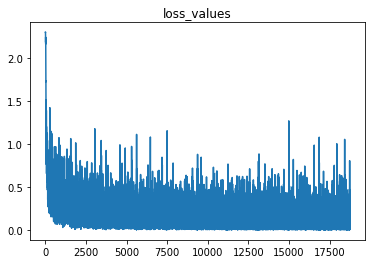

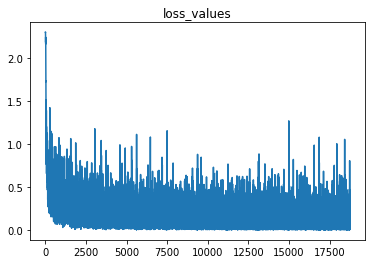

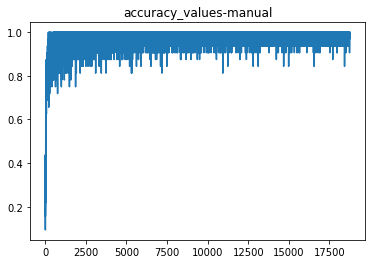

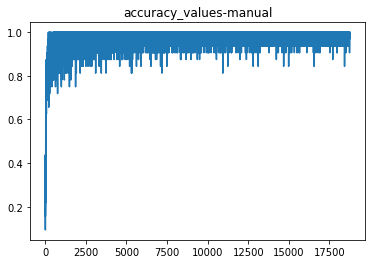

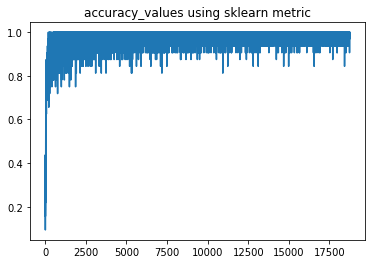

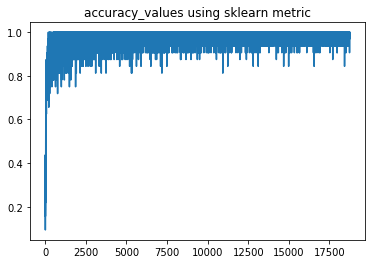

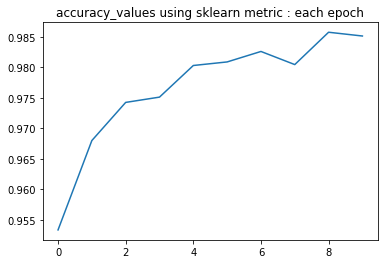

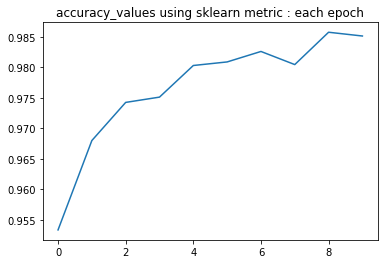

In [16]:
#plot loss values
plt.figure()
plt.title('loss_values')
plt.plot(loss_values)


plt.figure()
plt.title('accuracy_values-manual')
plt.plot(acc_values_m)


plt.figure()
plt.title('accuracy_values using sklearn metric')
plt.plot(acc_values_a)


plt.figure()
plt.title('accuracy_values using sklearn metric : each epoch')
plt.plot(acc_values_e)
